# Multilayer Perceptron for Risk Classification of Life Insurance Applicants

## Introduction

Traditionally, underwriters in insurance companies have collaborated closely with pricing actuaries to evaluate and manage risks, establishing prices (pure risk premium) in line with the company's risk management policies. This process required underwriters to manually review extensive information to determine pricing, including identifying insurable perils, defining policy coverage, and assessing the level of risk posed to the insured.

Nowadays, the underwriting process is becoming increasingly automated, enabling insurers to make rapid decisions regarding underwriting and pricing while providing tailored coverage specific to each client's risk profile. However, in a world where on-demand services are the norm, the life insurance application process remains outdated. Customers still need to provide extensive information for risk classification and eligibility, including scheduling medical exams —a process that typically takes an average of 30 days. [[1]](#R-1)


In the coming years, it is anticipated that the underwriting process will be reduced to just a few seconds, thanks to automation supported by machine learning and deep learning models integrated into the technology framework. These models will utilize both internal data from companies and a wide range of external data accessed through application programming interfaces and analytics providers. [[11]](#R-11) To contribute to this evolving process, it is essential to evaluate the suitability of the most promising deep learning models for these tasks, considering their acute predictive abilities for extensive datasets.

## Objective

The aim of this project is to build a neural network model to predict risk ratings for life insurance applicants, and to evaluate and compare its performance against other machine learning models. This will determine its suitability for the task of risk assessment, supporting the modernization of the underwriting process. We will use the dataset featured in the Prudential Life Insurance Assessment competition previously hosted on Kaggle. [[1]](#R-1)


## Project Outline

In this project, we will:

1. Explore, preprocess, and encode the dataset of life insurance applicants following the procedure at [[10]](#R-10).
2. Select, build, and optimize our neural network model for this task following an iterative development process.
3. Evaluate its performance and compare it to other machine learning models.


## Table of Contents

- [1 - Data preparation](#1)
   - [1.1 - Import data](#1.1)
   - [1.2 - Exploratory data analysis](#1.2)
   - [1.3 - Train-validation-test split of the dataset](#1.3)
   - [1.4 - Handling missing values](#1.4)
- [2 - Feature Engenieering](#2)
   - [2.1 - One hot encoding](#2.1)
   - [2.2 - Normalization](#2.2)
   - [2.3 - K-means clustering](#2.3)
   - [2.4 - Feature selection](#2.4)
- [3 - Model development](#3)
   - [3.1 QWK metric implementation](#3.1)
   - [3.2 Hyperparametr Optimization](#3.2)
     - [3.2.1 Model 1: Multilayer perceptron](#3.2.1)
     - [3.2.2 Model 2: CORN multilayer perceptron](#3.2.2)
   - [3.3 Model Selection](#3.3)
- [4 -  Evaluating model performance](#5)
- [7 - Bibliography](#6)

<a name='1'></a>
# 1. Data Preparation

<a name='1.1'></a>
## 1.1 Import the Data

First we'll start by importing the necessary libaries for the preprocessing and feature engenieering part of our data.

In [1]:
# Import key modules that will be used throughout the project.

import sys
import math
import pickle
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # graphs/plotting
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
import keras_tuner as kt
from sklearn.preprocessing import LabelEncoder
from scikitplot.metrics import plot_roc, plot_confusion_matrix
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import log_loss
!{sys.executable} -m pip install git+https://github.com/ck37/coral-ordinal/
import coral_ordinal as coral
from IPython.display import display, HTML
def print_colored(text, color='black'):
    display(HTML(f'<text style=color:{color}>{text}</text>'))

# Example usage:
print_colored("Hello, world!", color="blue")


# print("TensorFlow version:", tf.__version__)
# # Check to ensure that both CSV files are held in the correct (input) directory.
# from sklearn.metrics import cohen_kappa_score
# import os
# for dirname, _, filenames in os.walk('.\data_set'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/ck37/coral-ordinal/ to c:\users\ramos\appdata\local\temp\pip-req-build-d53vtpqd
  Resolved https://github.com/ck37/coral-ordinal/ to commit e42038b66705bcd6fb52152cf28ce8278a16912c
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/ck37/coral-ordinal/ 'C:\Users\Ramos\AppData\Local\Temp\pip-req-build-d53vtpqd'


In [2]:
# Load data
main_data = pd.read_csv('data_set/train.csv')
# Set 'id' as the index column.
main_data_index_set = main_data.set_index('Id')

Now we'll review a summary of our data, and visualize some of the risk features for the first applicants.

In [3]:
# Review the main characteristics of the Pandas dataframe.
print_colored("Columns datatypes:\n", color="purple")
print(main_data.dtypes)
print()
# Use select_dtypes to select columns with non-numeric data types
non_numeric_columns = main_data.select_dtypes(exclude=['number']).columns
print_colored("Columns with non-numeric values:\n", color="purple")
print(non_numeric_columns)
print()
# Analyze dataframe
print_colored("Data Summary:", color="purple")
main_data.describe()

Id                      int64
Product_Info_1          int64
Product_Info_2         object
Product_Info_3          int64
Product_Info_4        float64
                       ...   
Medical_Keyword_45      int64
Medical_Keyword_46      int64
Medical_Keyword_47      int64
Medical_Keyword_48      int64
Response                int64
Length: 128, dtype: object



Index(['Product_Info_2'], dtype='object')



Id  Product_Info_1  Product_Info_3  Product_Info_4  \
count  59381.000000    59381.000000    59381.000000    59381.000000   
mean   39507.211515        1.026355       24.415655        0.328952   
std    22815.883089        0.160191        5.072885        0.282562   
min        2.000000        1.000000        1.000000        0.000000   
25%    19780.000000        1.000000       26.000000        0.076923   
50%    39487.000000        1.000000       26.000000        0.230769   
75%    59211.000000        1.000000       26.000000        0.487179   
max    79146.000000        2.000000       38.000000        1.000000   

       Product_Info_5  Product_Info_6  Product_Info_7       Ins_Age  \
count    59381.000000    59381.000000    59381.000000  59381.000000   
mean         2.006955        2.673599        1.043583      0.405567   
std          0.083107        0.739103        0.291949      0.197190   
min          2.000000        1.000000        1.000000      0.000000   
25%          2.000000        3.000000        1.000000      0.238806   
50%          2.000000        3.000000        1.000000      0.402985   
75%          2.000000        3.000000        1.000000      0.567164   
max          3.000000        3.000000        3.000000      1.000000   

                 Ht            Wt  ...  Medical_Keyword_40  \
count  59381.000000  59381.000000  ...        59381.000000   
mean       0.707283      0.292587  ...            0.056954   
std        0.074239      0.089037  ...            0.231757   
min        0.000000      0.000000  ...            0.000000   
25%        0.654545      0.225941  ...            0.000000   
50%        0.709091      0.288703  ...            0.000000   
75%        0.763636      0.345188  ...            0.000000   
max        1.000000      1.000000  ...            1.000000   

       Medical_Keyword_41  Medical_Keyword_42  Medical_Keyword_43  \
count        59381.000000        59381.000000        59381.000000   
mean             0.010054            0.045536            0.010710   
std              0.099764            0.208479            0.102937   
min              0.000000            0.000000            0.000000   
25%              0.000000            0.000000            0.000000   
50%              0.000000            0.000000            0.000000   
75%              0.000000            0.000000            0.000000   
max              1.000000            1.000000            1.000000   

       Medical_Keyword_44  Medical_Keyword_45  Medical_Keyword_46  \
count        59381.000000        59381.000000        59381.000000   
mean             0.007528            0.013691            0.008488   
std              0.086436            0.116207            0.091737   
min              0.000000            0.000000            0.000000   
25%              0.000000            0.000000            0.000000   
50%              0.000000            0.000000            0.000000   
75%              0.000000            0.000000            0.000000   
max              1.000000            1.000000            1.000000   

       Medical_Keyword_47  Medical_Keyword_48      Response  
count        59381.000000        59381.000000  59381.000000  
mean             0.019905            0.054496      5.636837  
std              0.139676            0.226995      2.456833  
min              0.000000            0.000000      1.000000  
25%              0.000000            0.000000      4.000000  
50%              0.000000            0.000000      6.000000  
75%              0.000000            0.000000      8.000000  
max              1.000000            1.000000      8.000000  

[8 rows x 127 columns]

In [4]:
main_data_index_set.head()

Product_Info_1 Product_Info_2  Product_Info_3  Product_Info_4  \
Id                                                                  
2                1             D3              10        0.076923   
5                1             A1              26        0.076923   
6                1             E1              26        0.076923   
7                1             D4              10        0.487179   
8                1             D2              26        0.230769   

    Product_Info_5  Product_Info_6  Product_Info_7   Ins_Age        Ht  \
Id                                                                       
2                2               1               1  0.641791  0.581818   
5                2               3               1  0.059701  0.600000   
6                2               3               1  0.029851  0.745455   
7                2               3               1  0.164179  0.672727   
8                2               3               1  0.417910  0.654545   

          Wt  ...  Medical_Keyword_40  Medical_Keyword_41  Medical_Keyword_42  \
Id            ...                                                               
2   0.148536  ...                   0                   0                   0   
5   0.131799  ...                   0                   0                   0   
6   0.288703  ...                   0                   0                   0   
7   0.205021  ...                   0                   0                   0   
8   0.234310  ...                   0                   0                   0   

    Medical_Keyword_43  Medical_Keyword_44  Medical_Keyword_45  \
Id                                                               
2                    0                   0                   0   
5                    0                   0                   0   
6                    0                   0                   0   
7                    0                   0                   0   
8                    0                   0                   0   

    Medical_Keyword_46  Medical_Keyword_47  Medical_Keyword_48  Response  
Id                                                                        
2                    0                   0                   0         8  
5                    0                   0                   0         4  
6                    0                   0                   0         8  
7                    0                   0                   0         8  
8                    0                   0                   0         8  

[5 rows x 127 columns]

From the cell above, we observe that our dataset comprises approximately 60,000 applicants and their application details, encapsulated by over 100 variables. Our dataframe exhibits a diverse range of data types, including a non-numeric (character) variable. Among the numeric-valued features, some are normalized, while others are not. We will address this issues during the preprocessing and feature engineering stages.

Text(0.5, 1.0, 'Response Distribution')

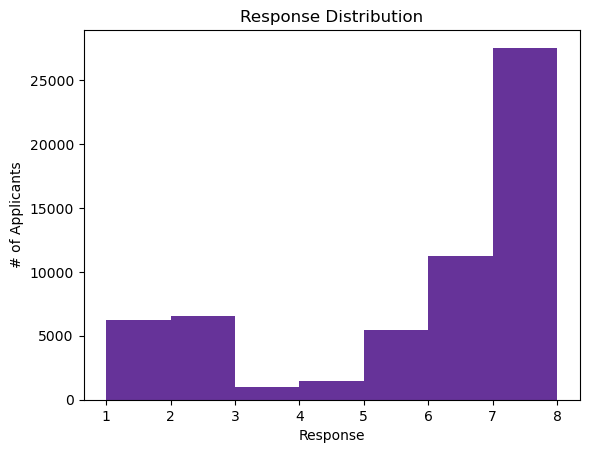

In [5]:
# Visualise the distribution of applicants' risk ratings in the full dataset.

plt.hist(main_data_index_set['Response'], bins=sorted(main_data_index_set['Response'].unique()),color='rebeccapurple')
plt.xlabel('Response')
plt.ylabel('# of Applicants')
plt.title('Response Distribution')

The histogram depicted above illustrates the distribution of applicants based on their assigned risk ratings (i.e., Response) for the complete dataset. It's noteworthy that the distribution is imbalanced, with a skew towards classes 6-8, although classes 1-2 also represent a significant portion of the dataset.

<a name='1.2'></a>

## 1.2 Conduct Exploratory Data Analysis (EDA) to Visualize Distributions and Correlations

In the subsequent cell, the features are organized into lists corresponding to each set of variables within the dataset. For example, all variables from Product_Info_1 to Product_Info_7 are grouped under the list ColSet1_ProdInfo. Variables not grouped under any particular category by name are included in the ColSet2_ApplicantInfo list.

In [6]:
# Split out the full set of the main dataset's columns into separate lists.

ColSet1_ProdInfo = ['Product_Info_1','Product_Info_2','Product_Info_3','Product_Info_4','Product_Info_5','Product_Info_6','Product_Info_7']
ColSet2_ApplicantInfo = ['Ins_Age','Ht','Wt','BMI']
ColSet3_EmploymentInfo = ['Employment_Info_1','Employment_Info_2','Employment_Info_3','Employment_Info_4','Employment_Info_5','Employment_Info_6']
ColSet4_InsuredInfo = ['InsuredInfo_1','InsuredInfo_2','InsuredInfo_3','InsuredInfo_4','InsuredInfo_5','InsuredInfo_6','InsuredInfo_7']
ColSet5_InsuranceHistoryInfo = ['Insurance_History_1','Insurance_History_2','Insurance_History_3','Insurance_History_4','Insurance_History_5','Insurance_History_7','Insurance_History_8','Insurance_History_9']
ColSet6_FamilyHistoryInfo = ['Family_Hist_1','Family_Hist_2','Family_Hist_3','Family_Hist_4','Family_Hist_5']

ColSet7_MedicalHistoryInfo = ['Medical_History_1','Medical_History_2','Medical_History_3','Medical_History_4','Medical_History_5','Medical_History_6','Medical_History_7','Medical_History_8',
                              'Medical_History_9','Medical_History_10','Medical_History_11','Medical_History_12','Medical_History_13','Medical_History_14','Medical_History_15',
                              'Medical_History_16','Medical_History_17','Medical_History_18','Medical_History_19','Medical_History_20','Medical_History_21','Medical_History_22',
                              'Medical_History_23','Medical_History_24','Medical_History_25','Medical_History_26','Medical_History_27','Medical_History_28','Medical_History_29',
                              'Medical_History_30','Medical_History_31','Medical_History_32','Medical_History_33','Medical_History_34','Medical_History_35','Medical_History_36',
                              'Medical_History_37','Medical_History_38','Medical_History_39','Medical_History_40','Medical_History_41']

ColSet8_MedicalKeywordInfo = ['Medical_Keyword_1','Medical_Keyword_2','Medical_Keyword_3','Medical_Keyword_4','Medical_Keyword_5','Medical_Keyword_6','Medical_Keyword_7','Medical_Keyword_8',
                              'Medical_Keyword_9','Medical_Keyword_10','Medical_Keyword_11','Medical_Keyword_12','Medical_Keyword_13','Medical_Keyword_14','Medical_Keyword_15','Medical_Keyword_16',
                              'Medical_Keyword_17','Medical_Keyword_18','Medical_Keyword_19','Medical_Keyword_20','Medical_Keyword_21','Medical_Keyword_22','Medical_Keyword_23','Medical_Keyword_24',
                              'Medical_Keyword_25','Medical_Keyword_26','Medical_Keyword_27','Medical_Keyword_28','Medical_Keyword_29','Medical_Keyword_30','Medical_Keyword_31','Medical_Keyword_32',
                              'Medical_Keyword_33','Medical_Keyword_34','Medical_Keyword_35','Medical_Keyword_36','Medical_Keyword_37','Medical_Keyword_38','Medical_Keyword_39','Medical_Keyword_40',
                              'Medical_Keyword_41','Medical_Keyword_42','Medical_Keyword_43','Medical_Keyword_44','Medical_Keyword_45','Medical_Keyword_46','Medical_Keyword_47','Medical_Keyword_48']

### Distribution plots

In this section, we will generate Kernel Density Estimate (KDE) plots for each feature - where Response is set as the hue of each curve - in order to compare distributions across each risk rating, and identify any potential trends or correlations within the dataset.

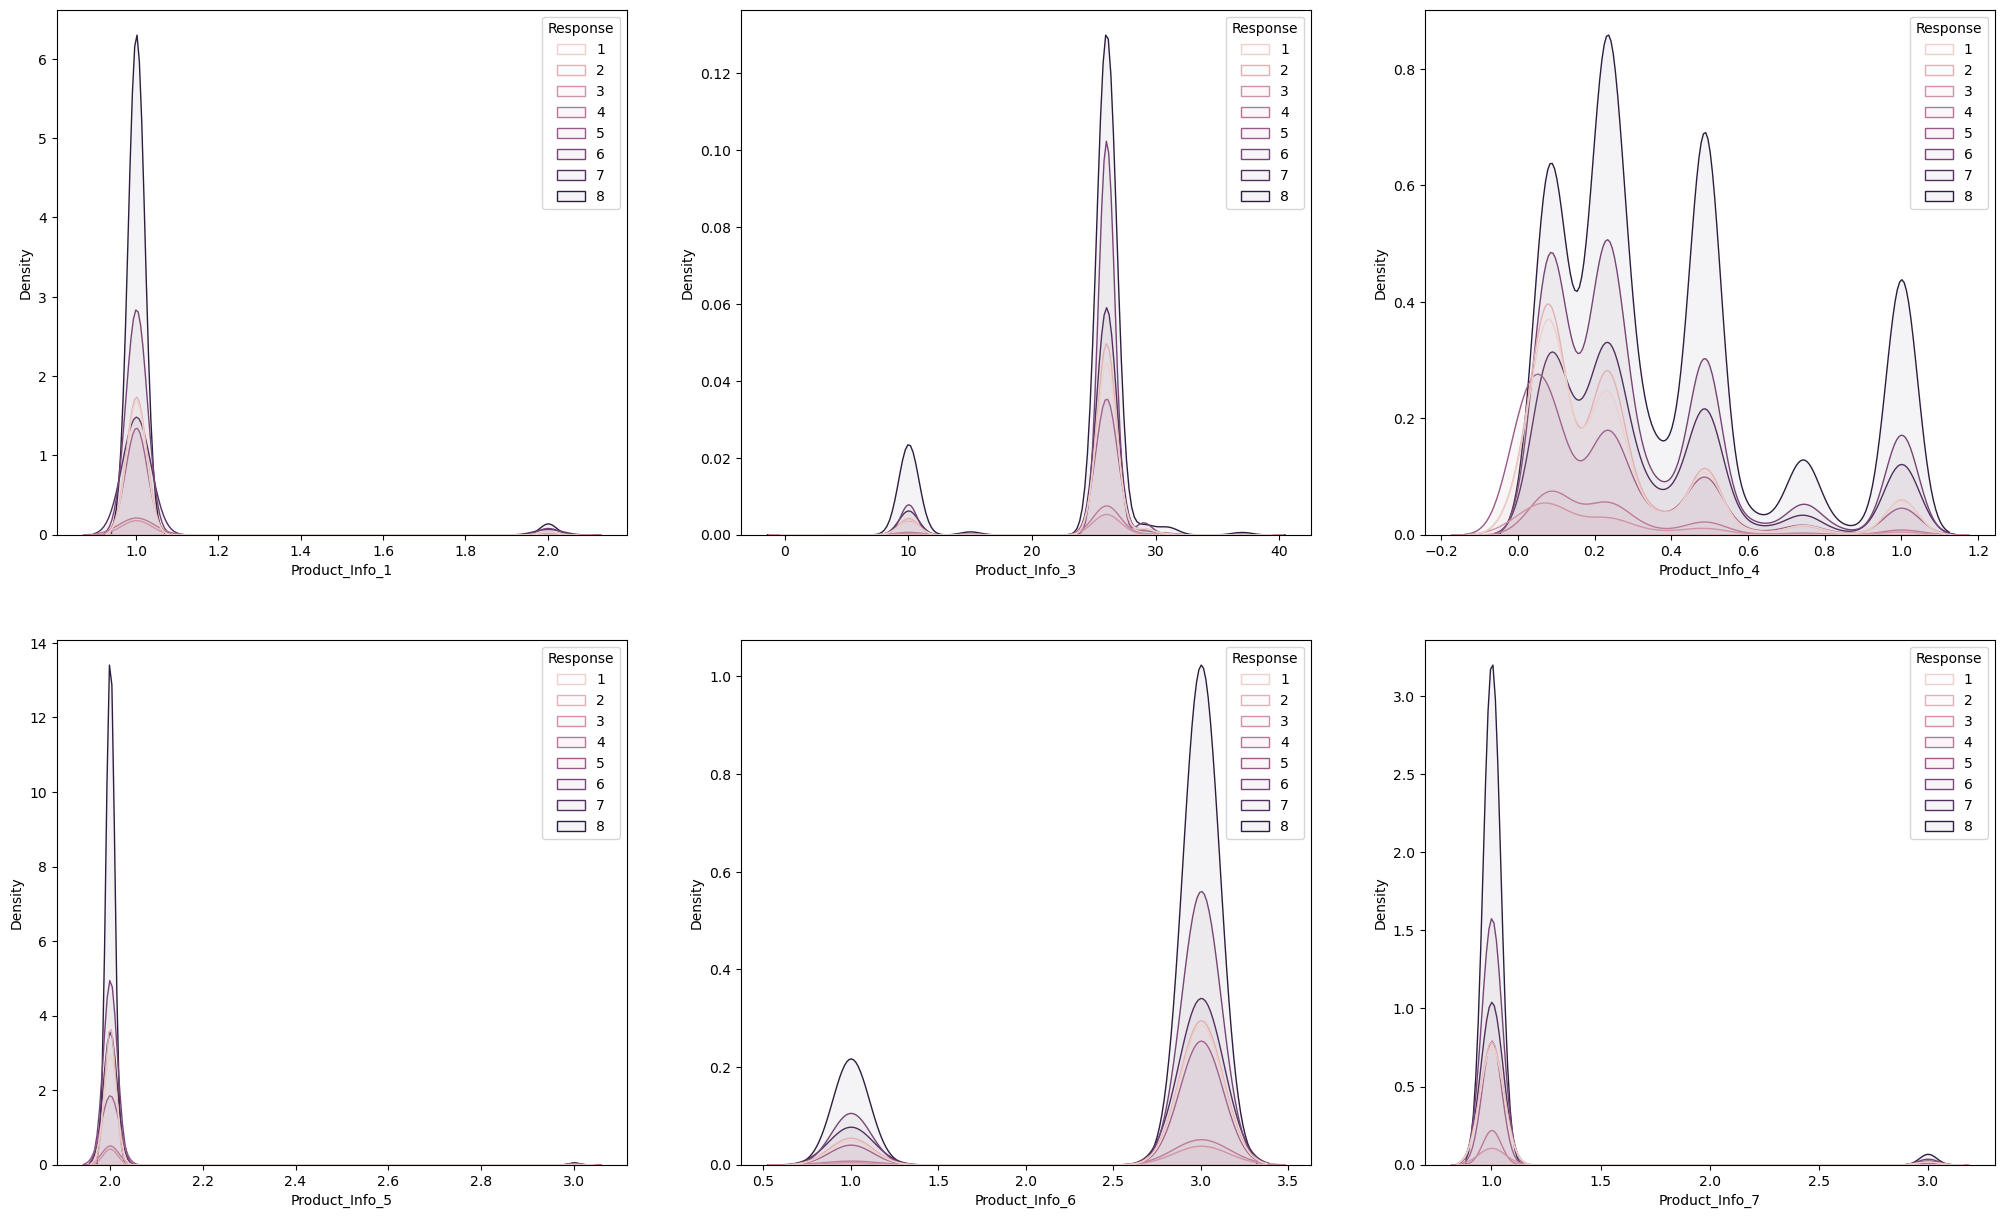

In [7]:
# Set up a subplot grid.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,15))

# Product_Info_2 has been excluded - as this has not yet been encoded into numeric values.
ColSet1_ProdInfo_kde = ['Product_Info_1','Product_Info_3','Product_Info_4','Product_Info_5','Product_Info_6','Product_Info_7']

# Produce kernel density estimate plots for each set of columns.
for i, column in enumerate(main_data_index_set[ColSet1_ProdInfo_kde].columns):
    sns.kdeplot(data=main_data_index_set,
                x=column,
                hue="Response", fill=True, common_norm=True, alpha=0.05,
                ax=axes[i//3,i%3])

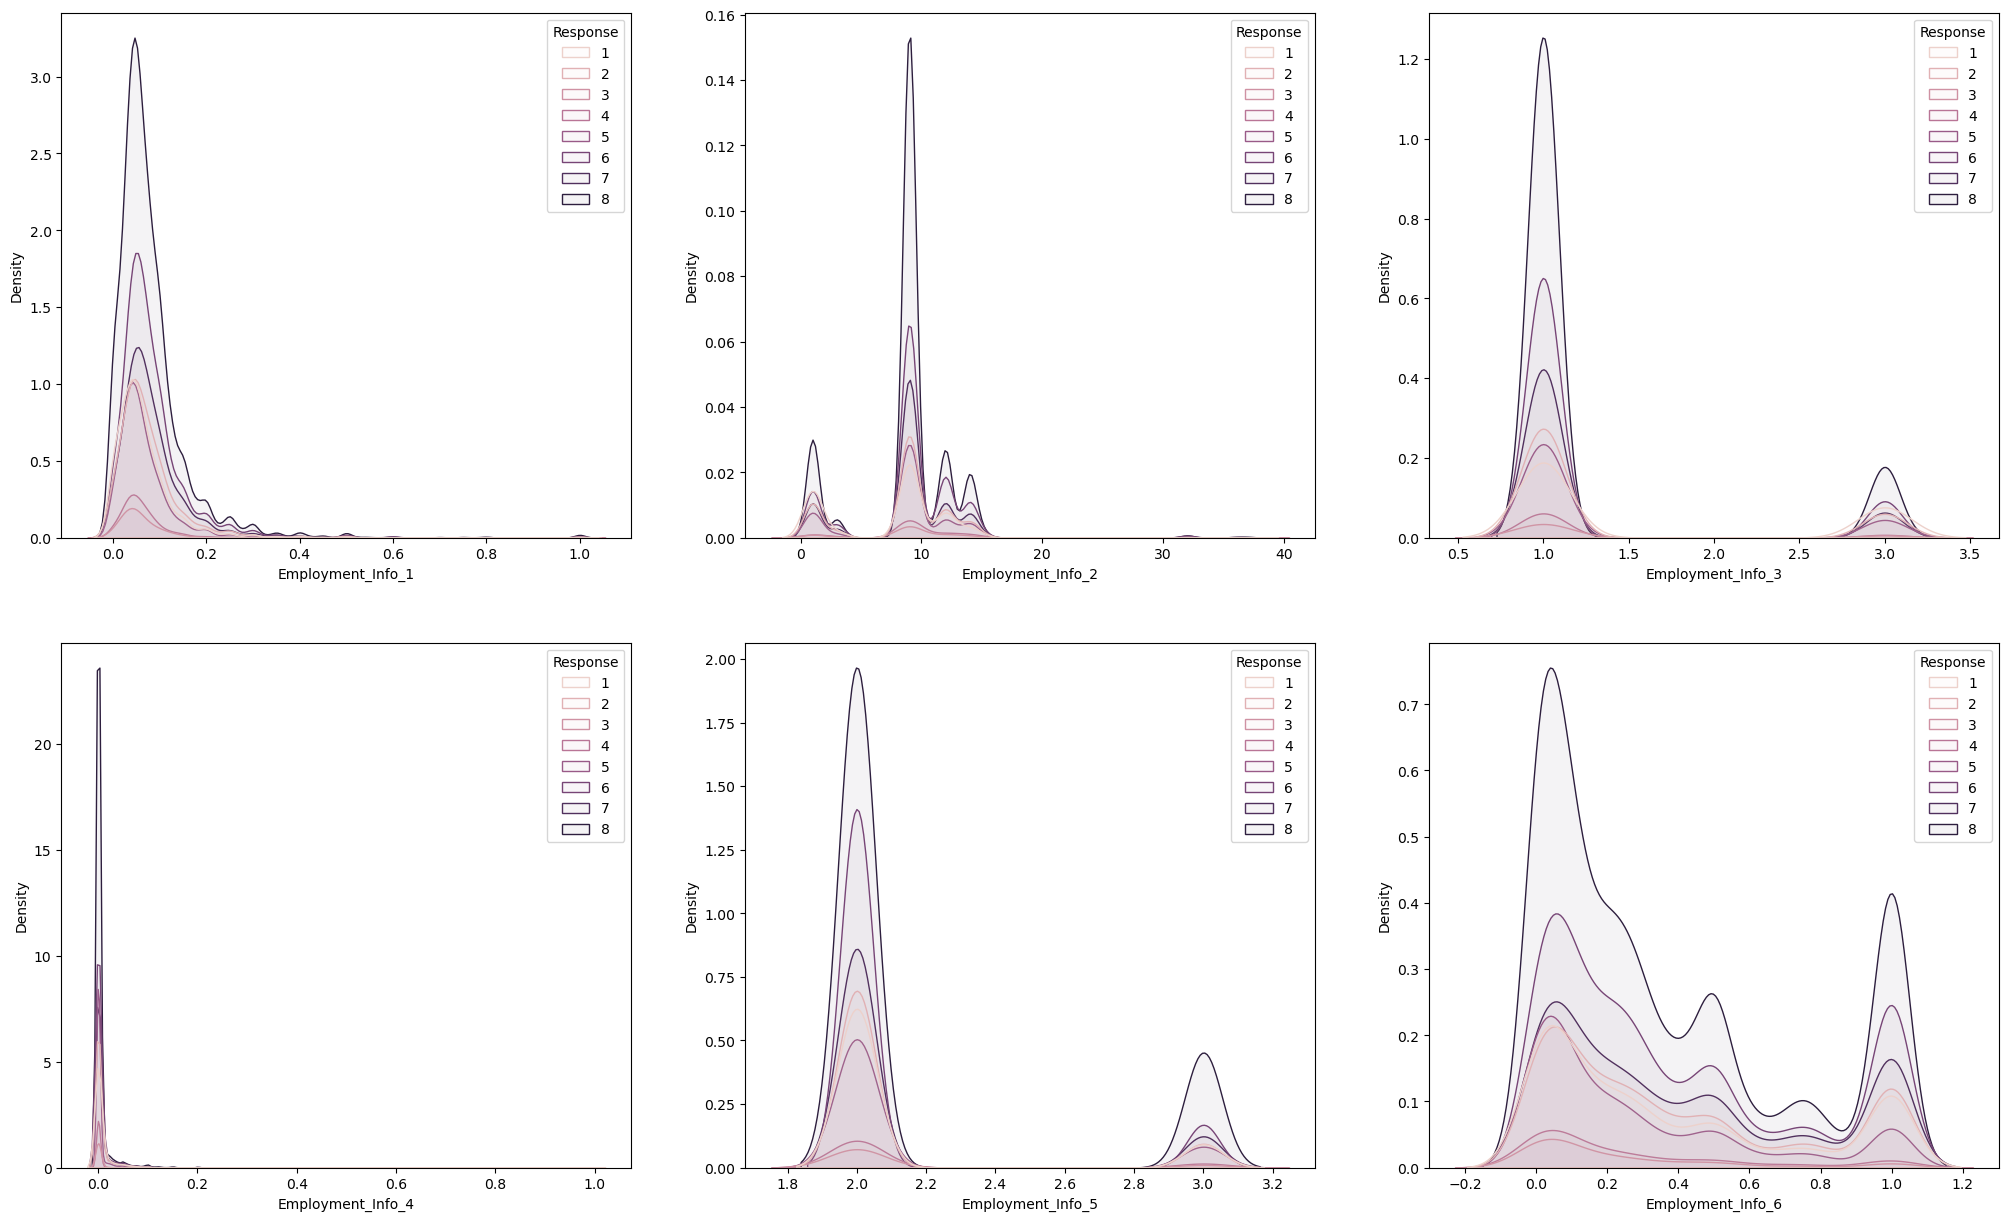

In [8]:
# Set up a subplot grid.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,15))

# Produce kernel density estimate plots for each set of columns.
for i, column in enumerate(main_data_index_set[ColSet3_EmploymentInfo].columns):
    sns.kdeplot(data=main_data_index_set,
                x=column,
                hue="Response", fill=True, common_norm=True, alpha=0.05,
                ax=axes[i//3,i%3])

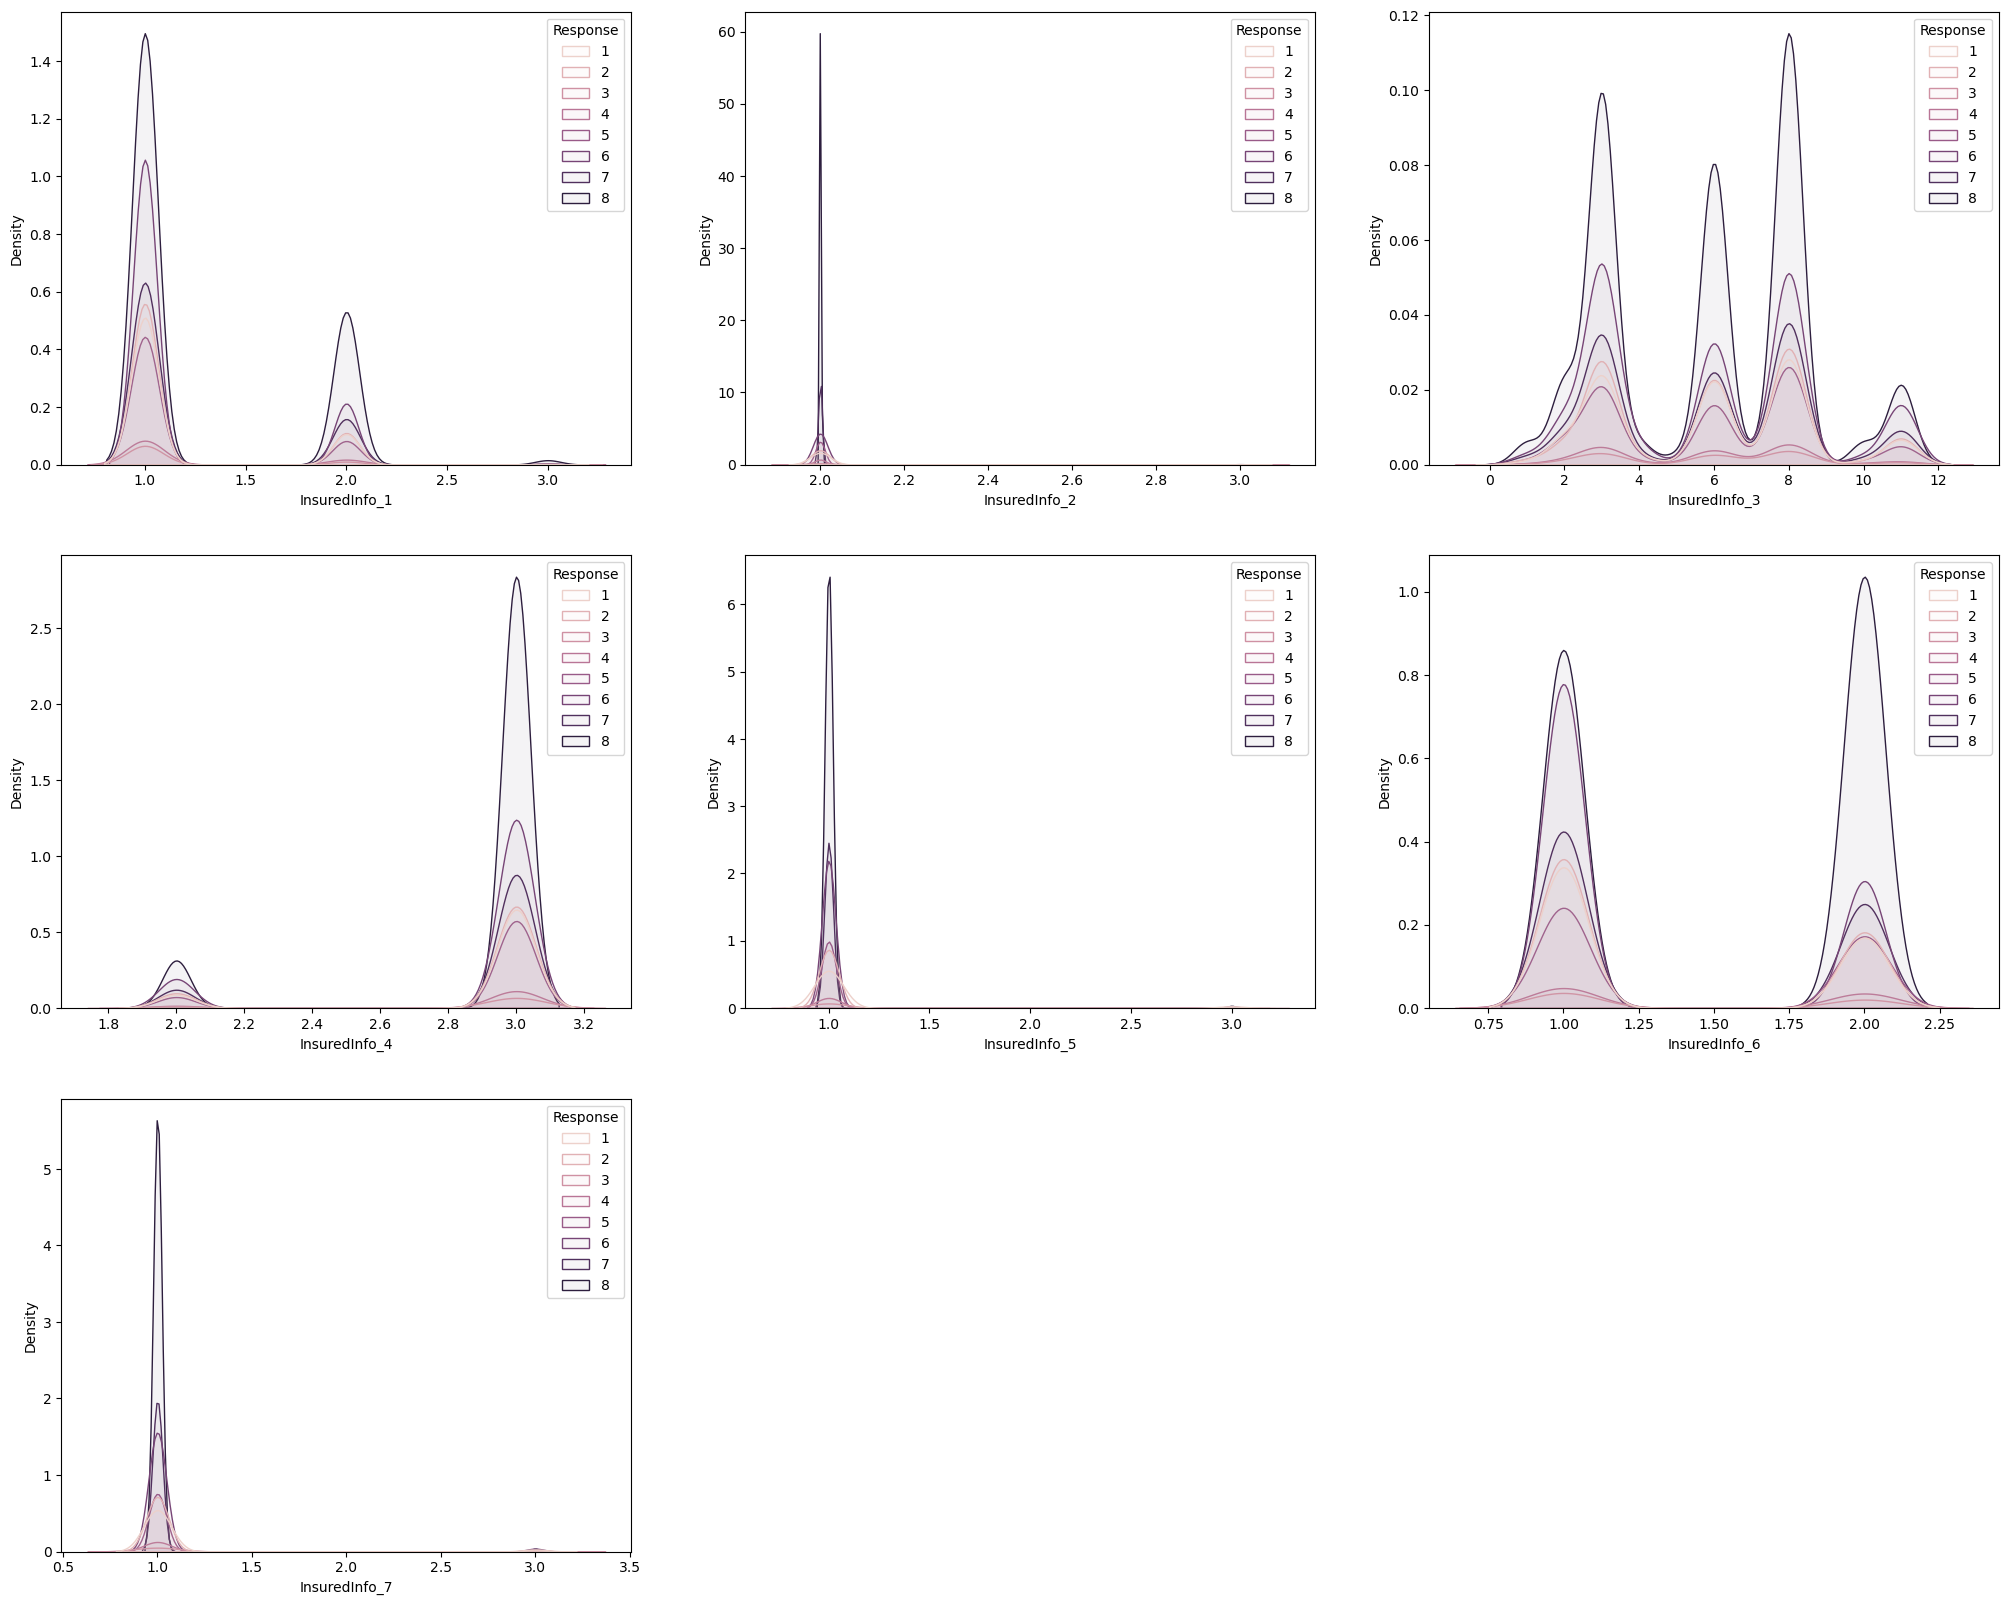

In [9]:
# Set up a subplot grid.
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25,20))

# Produce kernel density estimate plots for each set of columns.
for i, column in enumerate(main_data_index_set[ColSet4_InsuredInfo].columns):
    sns.kdeplot(data=main_data_index_set,
                x=column,
                hue="Response", fill=True, common_norm=True, alpha=0.05,
                ax=axes[i//3,i%3])

# Delete any unused sets of axes in the subplot grid.    
fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])

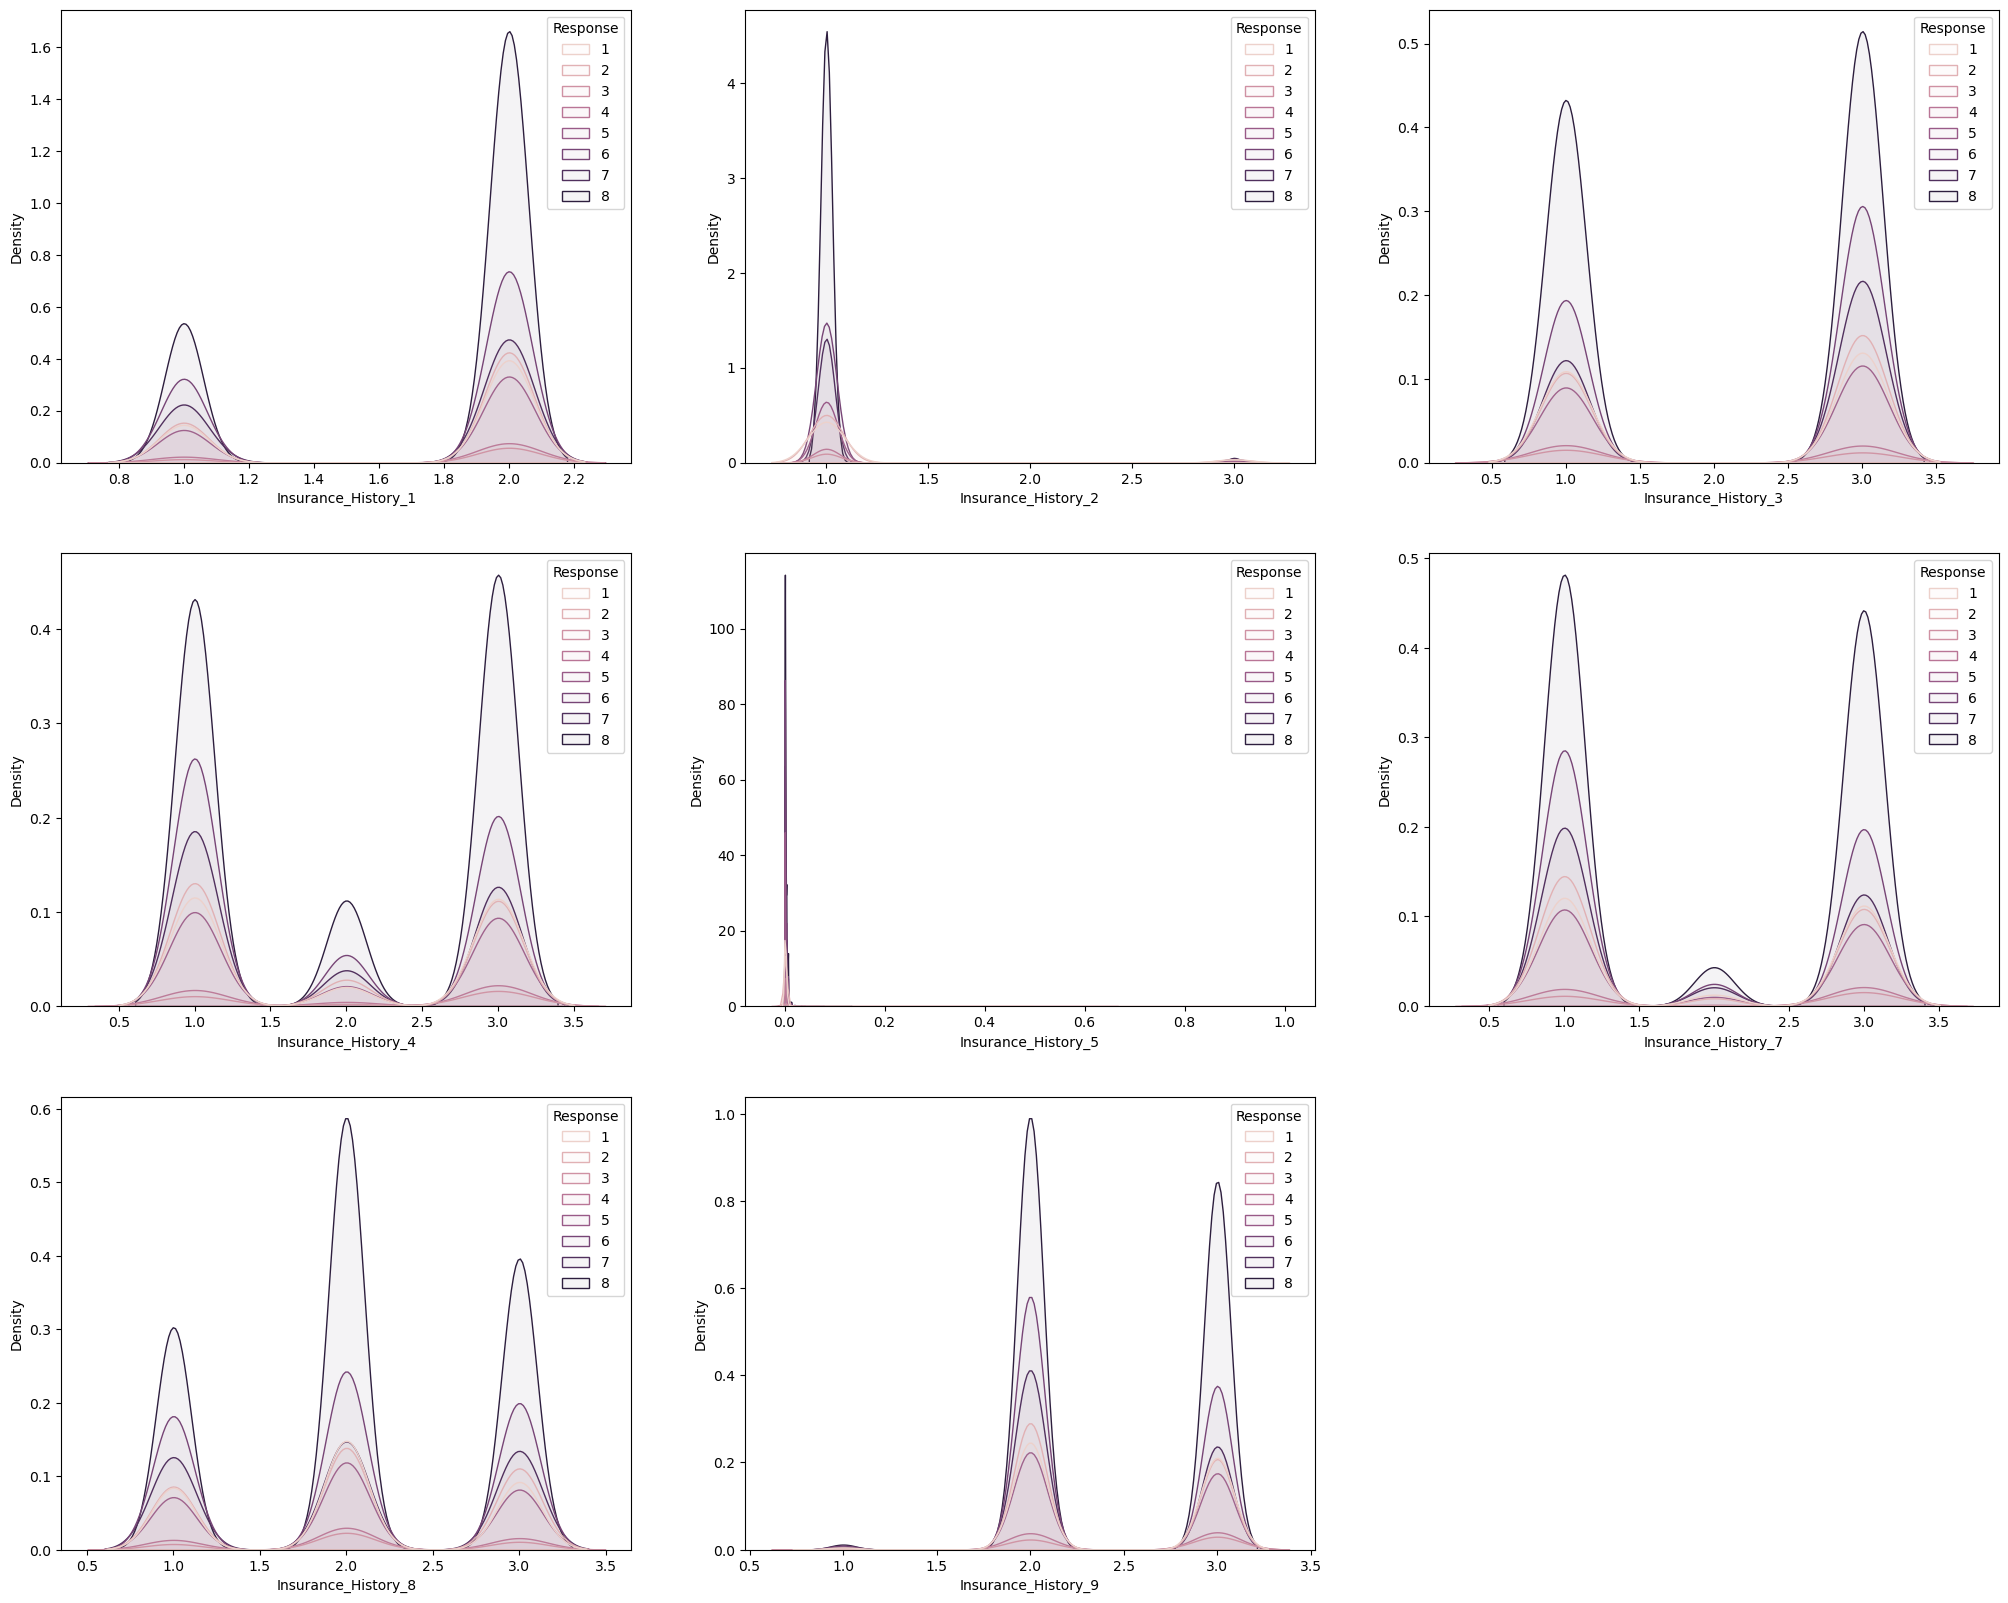

In [10]:
# Set up a subplot grid.
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25,20))

# Produce kernel density estimate plots for each set of columns.
for i, column in enumerate(main_data_index_set[ColSet5_InsuranceHistoryInfo].columns):
    sns.kdeplot(data=main_data_index_set,
                x=column,
                hue="Response", fill=True, common_norm=True, alpha=0.05,
                ax=axes[i//3,i%3])
    
# Delete any unused sets of axes in the subplot grid.    
fig.delaxes(axes[2,2])

C:\Users\Ramos\AppData\Local\Temp\ipykernel_8048\1793688068.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=main_data_index_set,


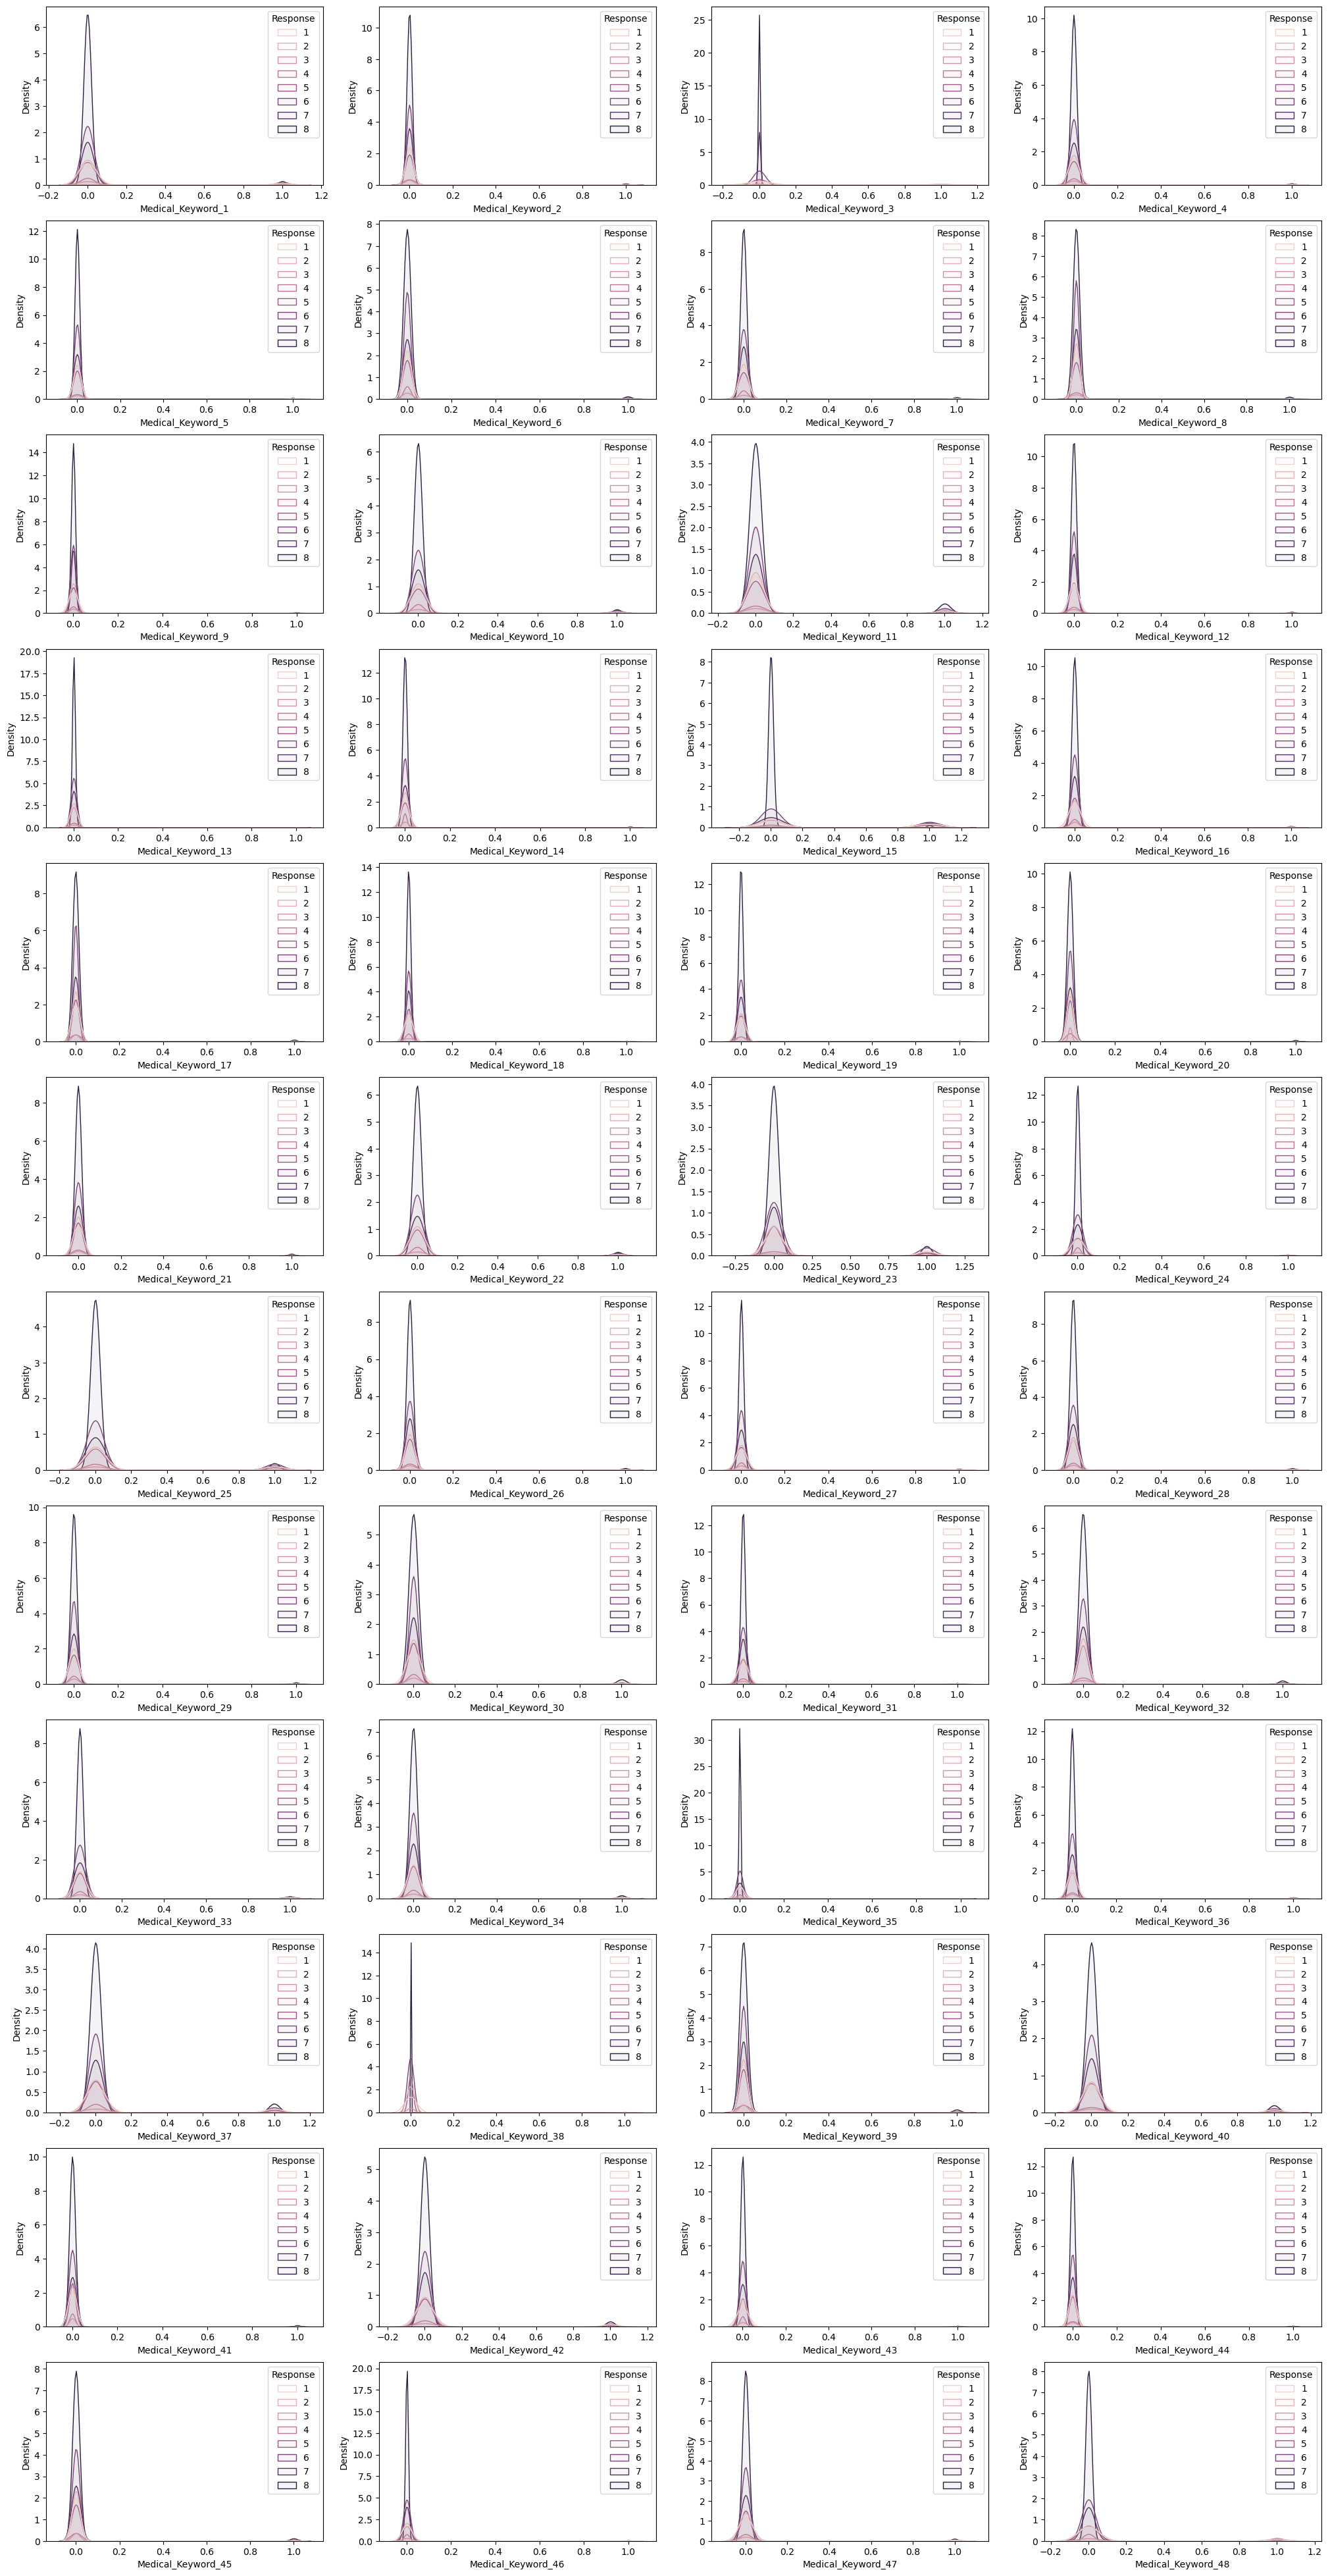

In [11]:
# Set up a subplot grid.
fig, axes = plt.subplots(nrows=12, ncols=4, figsize=(25,50))

# Produce kernel density estimate plots for each set of columns.
for i, column in enumerate(main_data_index_set[ColSet8_MedicalKeywordInfo].columns):
    sns.kdeplot(data=main_data_index_set,
                x=column,
                hue="Response", fill=True, common_norm=True, alpha=0.05,
                ax=axes[i//4,i%4])

The KDE plots for the feature sets including Product information, Insured information, Employment information, Medical Keywords, and Insurance History information reveal several distributions with differing modalities. However, a consistent observation across all these sets is the close overlap among the Response groups or cohorts of applicants, with no significant disparities in relative densities. Consequently, any divergence observed in these features is unlikely to contribute significantly to predicting an applicant's risk rating independently.

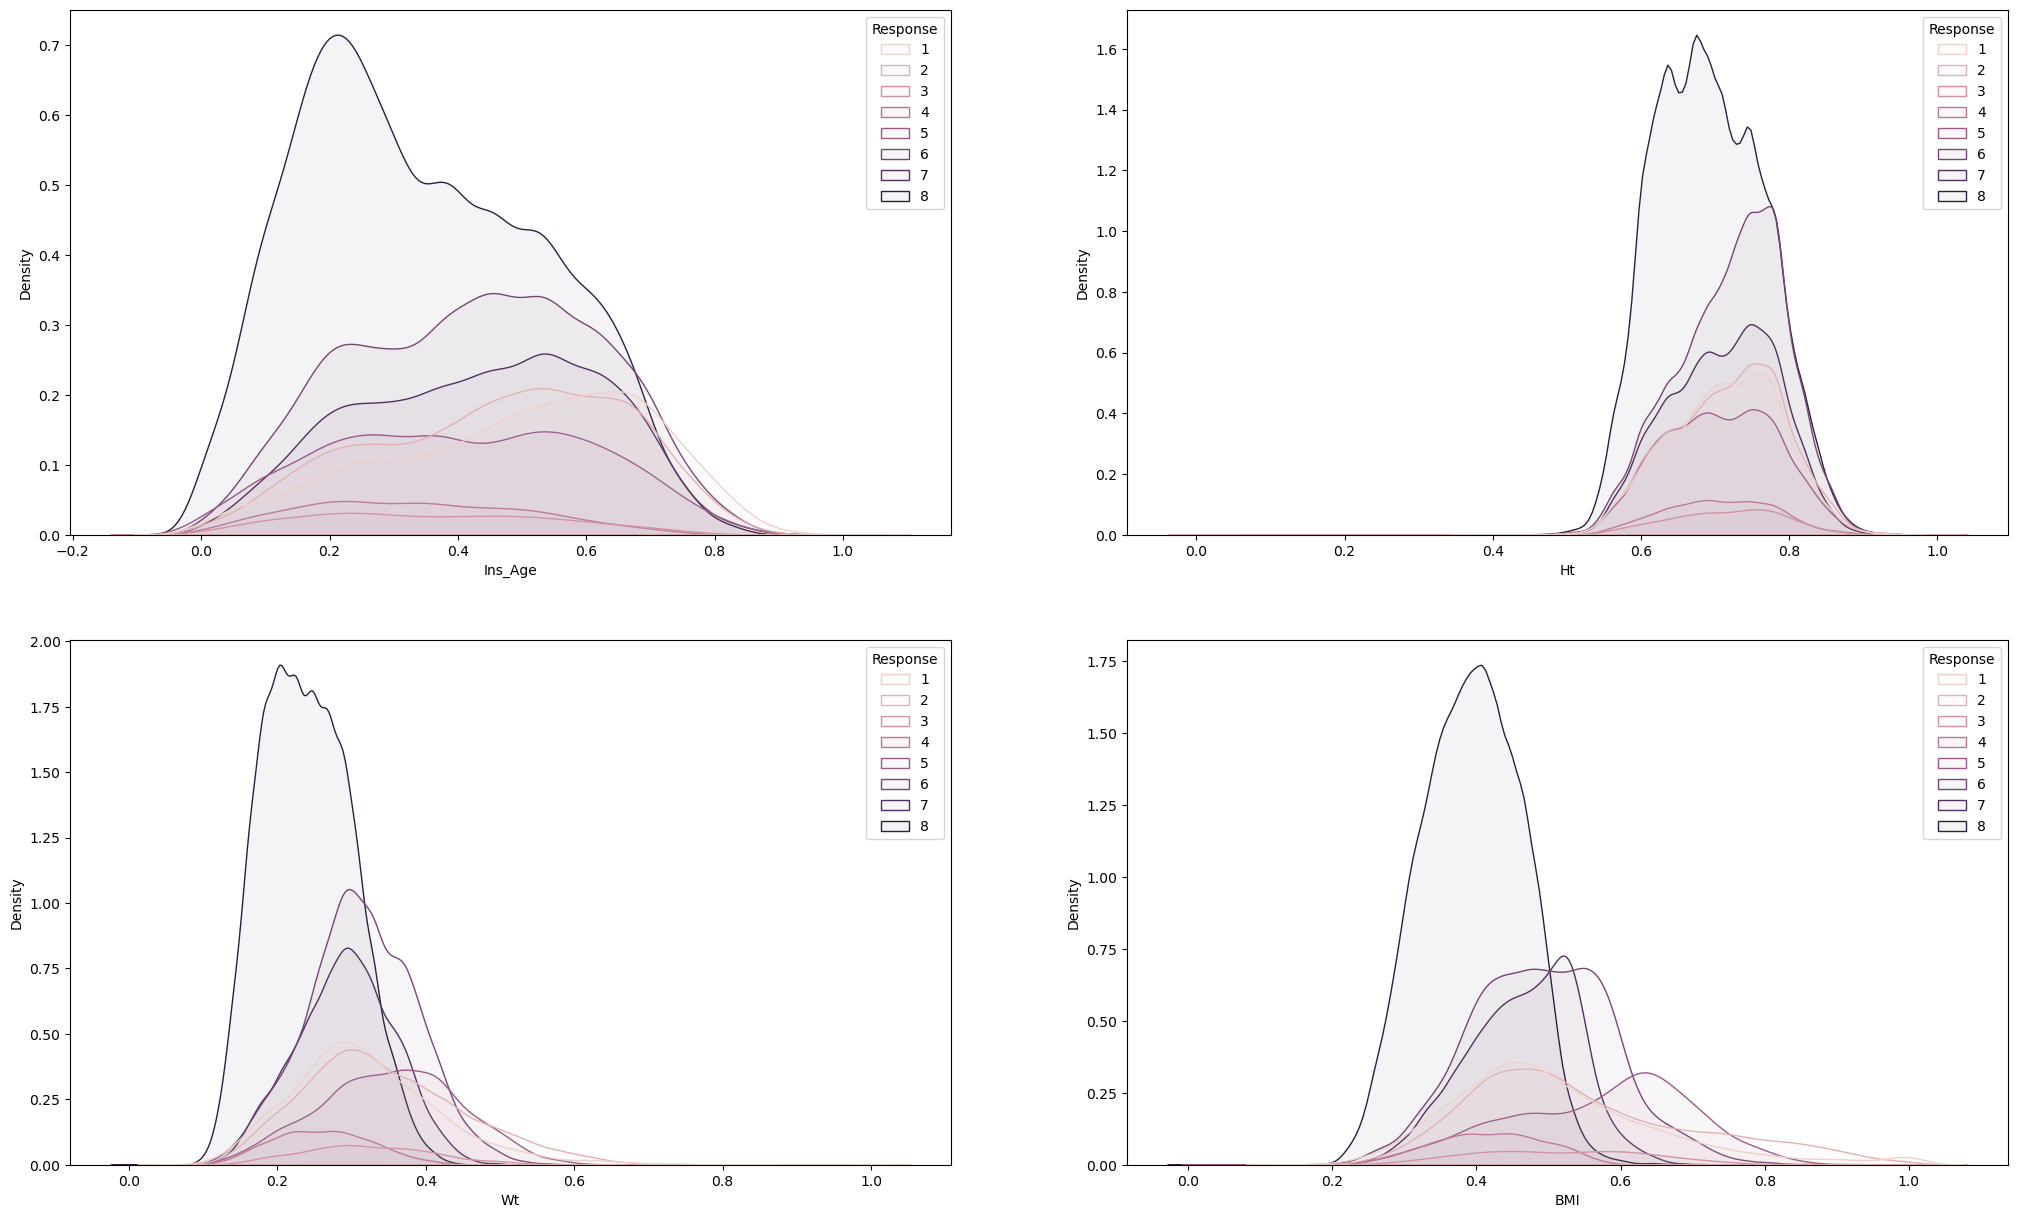

In [12]:
# Set up a subplot grid.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,15))

# Produce kernel density estimate plots for each set of columns.
for i, column in enumerate(main_data_index_set[ColSet2_ApplicantInfo].columns):
    sns.kdeplot(data=main_data_index_set,
                x=column,
                hue="Response", fill=True, common_norm=True, alpha=0.05,
                ax=axes[i//2,i%2])

The Kernel Density Estimate (KDE) plots for Ins_Age, Ht, Wt, and BMI illustrate significant variations in the composition and structure of each Response group's distribution. While the majority of the density is concentrated within specific ranges for each feature, there are noticeable differences in skewness among the Response groups. For instance, class 8 exhibits positive skewness in Ins_Age, Ht, Wt, and BMI, while most other classes display negative skewness. Additionally, class 8 presents distinct patterns, such as lower values in Wt and higher values in BMI compared to other classes, suggesting potential correlations with risk ratings. These observations align with expectations regarding health-related factors such as weight, BMI, and age.

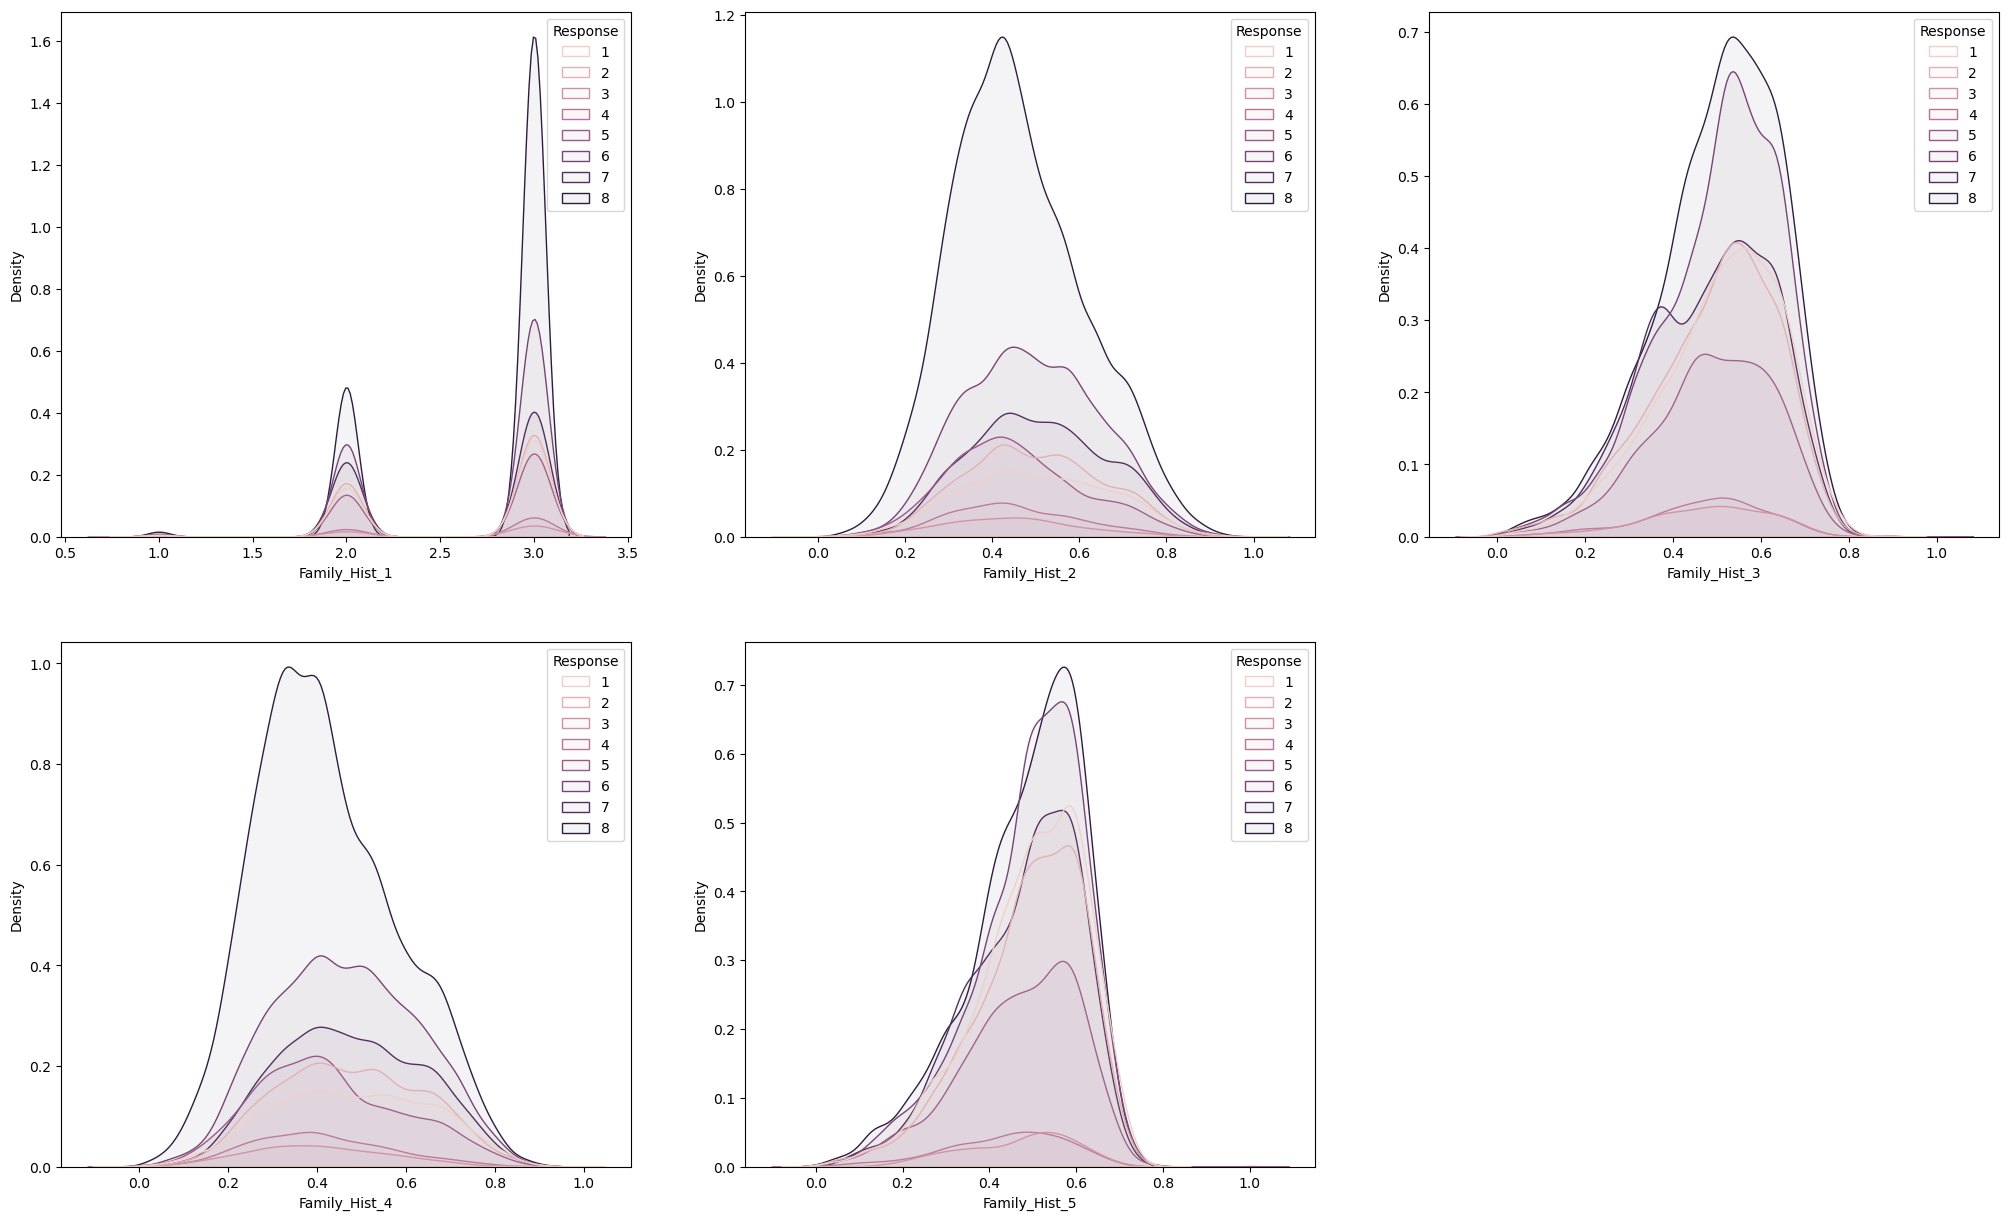

In [13]:
# Set up a subplot grid.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,15))

# Produce kernel density estimate plots for each set of columns.
for i, column in enumerate(main_data_index_set[ColSet6_FamilyHistoryInfo].columns):
    sns.kdeplot(data=main_data_index_set,
                x=column,
                hue="Response", fill=True, common_norm=True, alpha=0.05,
                ax=axes[i//3,i%3])

# Delete any unused sets of axes in the subplot grid.    
fig.delaxes(axes[1,2])

In [14]:
# Review the main characteristics of the Pandas dataframe.
print_colored("Family_Hist_1 datatype:\n", color="purple")
print(main_data["Family_Hist_1"].dtypes)
print()
# Analyze dataframe
print_colored("Family_Hist_1 Summary:", color="purple")
main_data["Family_Hist_1"].describe()

int64



count    59381.000000
mean         2.686230
std          0.483159
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          3.000000
Name: Family_Hist_1, dtype: float64

The Family_Hist_1 variable is integer type, constrained within values from 1 to 3, and its KDE shows a prominent density at 3, a medium at 2 and a very low one at 1. Howver, this feature shows minimal variation in relative densities across different Response classes, suggesting it may not significantly influence predicting an applicant's risk rating.

On the other hand, the KDE plots for Family_Hist_2 to Family_Hist_5 depict unimodal distributions, each displaying varying shapes and structures across Response groups. These distributions often show widening and shouldering of peaks, with the majority of densities concentrated between x=0.2 and x=0.8. While the shapes and skewness/kurtosis of these distributions differ among cohorts, class 8 generally demonstrates higher positive kurtosis compared to other classes, with broader density plots being characteristic of most other Response groups.

C:\Users\Ramos\AppData\Local\Temp\ipykernel_8048\217326378.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=main_data_index_set,


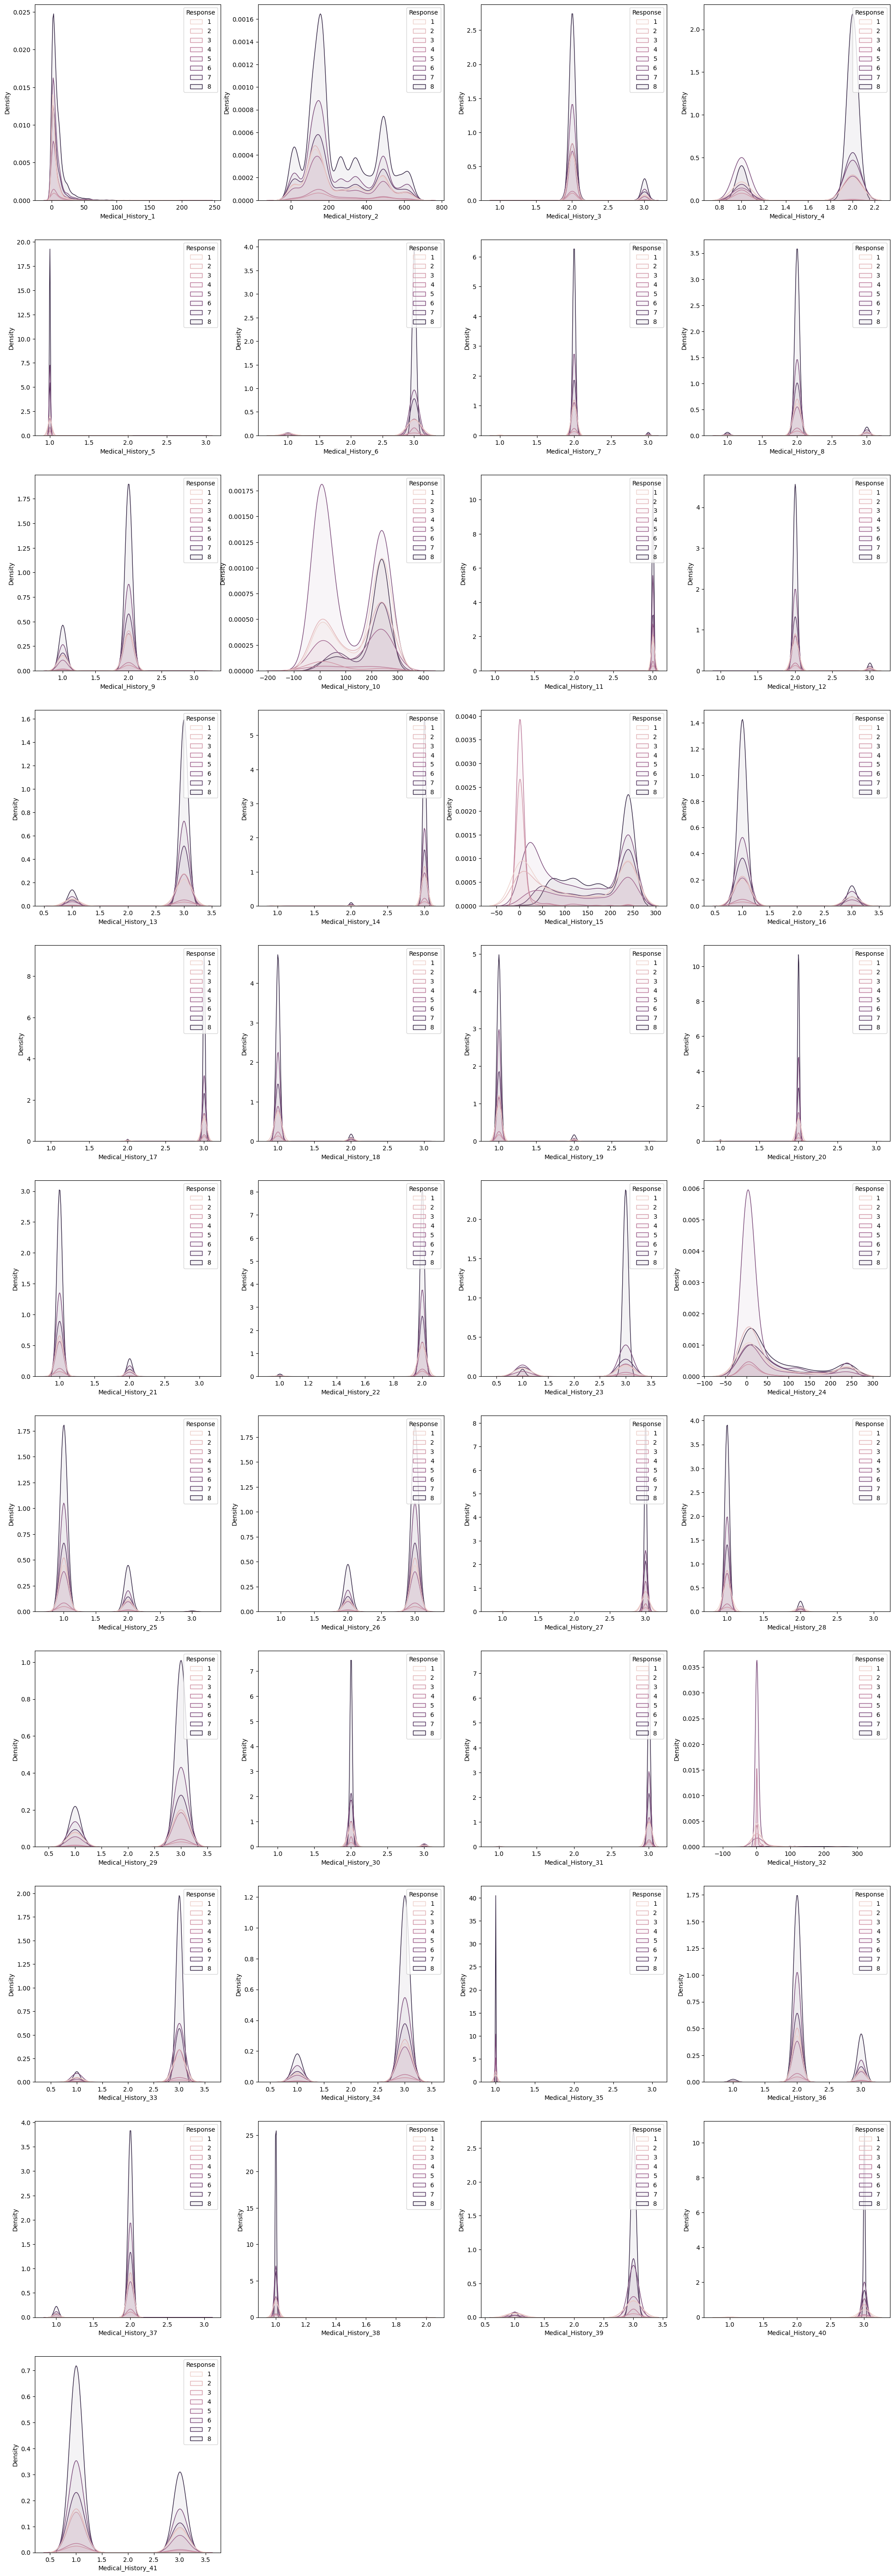

In [15]:
# Set up a subplot grid.
fig, axes = plt.subplots(nrows=11, ncols=4, figsize=(25,75))

# Produce kernel density estimate plots for each set of columns.
for i, column in enumerate(main_data_index_set[ColSet7_MedicalHistoryInfo].columns):
    sns.kdeplot(data=main_data_index_set,
                x=column,
                hue="Response", fill=True, common_norm=True, alpha=0.05,
                ax=axes[i//4,i%4])

# Delete any unused sets of axes in the subplot grid.    
fig.delaxes(axes[10,1])
fig.delaxes(axes[10,2])
fig.delaxes(axes[10,3])

The majority of these KDE plots demonstrate distributions that closely overlap among each Response group or cohort of applicants, indicating that variations in the underlying features are unlikely to provide significant predictive power individually for determining an applicant's risk rating. However, there are notable exceptions:

- Medical_History_2, Medical_History_15, Medical_History_24: These KDE plots display multimodal distributions with some degree of predictive distinction in terms of variance. The peaks of each Response group's distribution show varying levels of broadening and shouldering. However, it's crucial to consider the y-axis scales, as the densities for each underlying distribution are very small, limiting their individual predictive power.

- Medical_History_10: In the KDE plot, we observe that for cohorts of low-risk applicants, the distributions appear bimodal, whereas for higher risk levels, the distribution tends to have a single peak. However, it's important to note that this column contains a high proportion of missing values. Therefore, the distributions should not be considered highly predictive.

- Medical_History_23: This KDE plot suggests some potential predictive power. As the Response value or risk rating increases, each peak in the bimodal distribution becomes sharper, indicating more positive kurtosis. In simpler terms, values further away from the peak centers tend to correlate with lower risk ratings, while values closely overlapping with the peaks tend to represent applicants with higher risk ratings.

## Correlation plots/heatmaps

NextNext, we will generate a correlation heatmap plot for all features to better understand the correlations between each pair of features and uncover possible interactions within the data. 

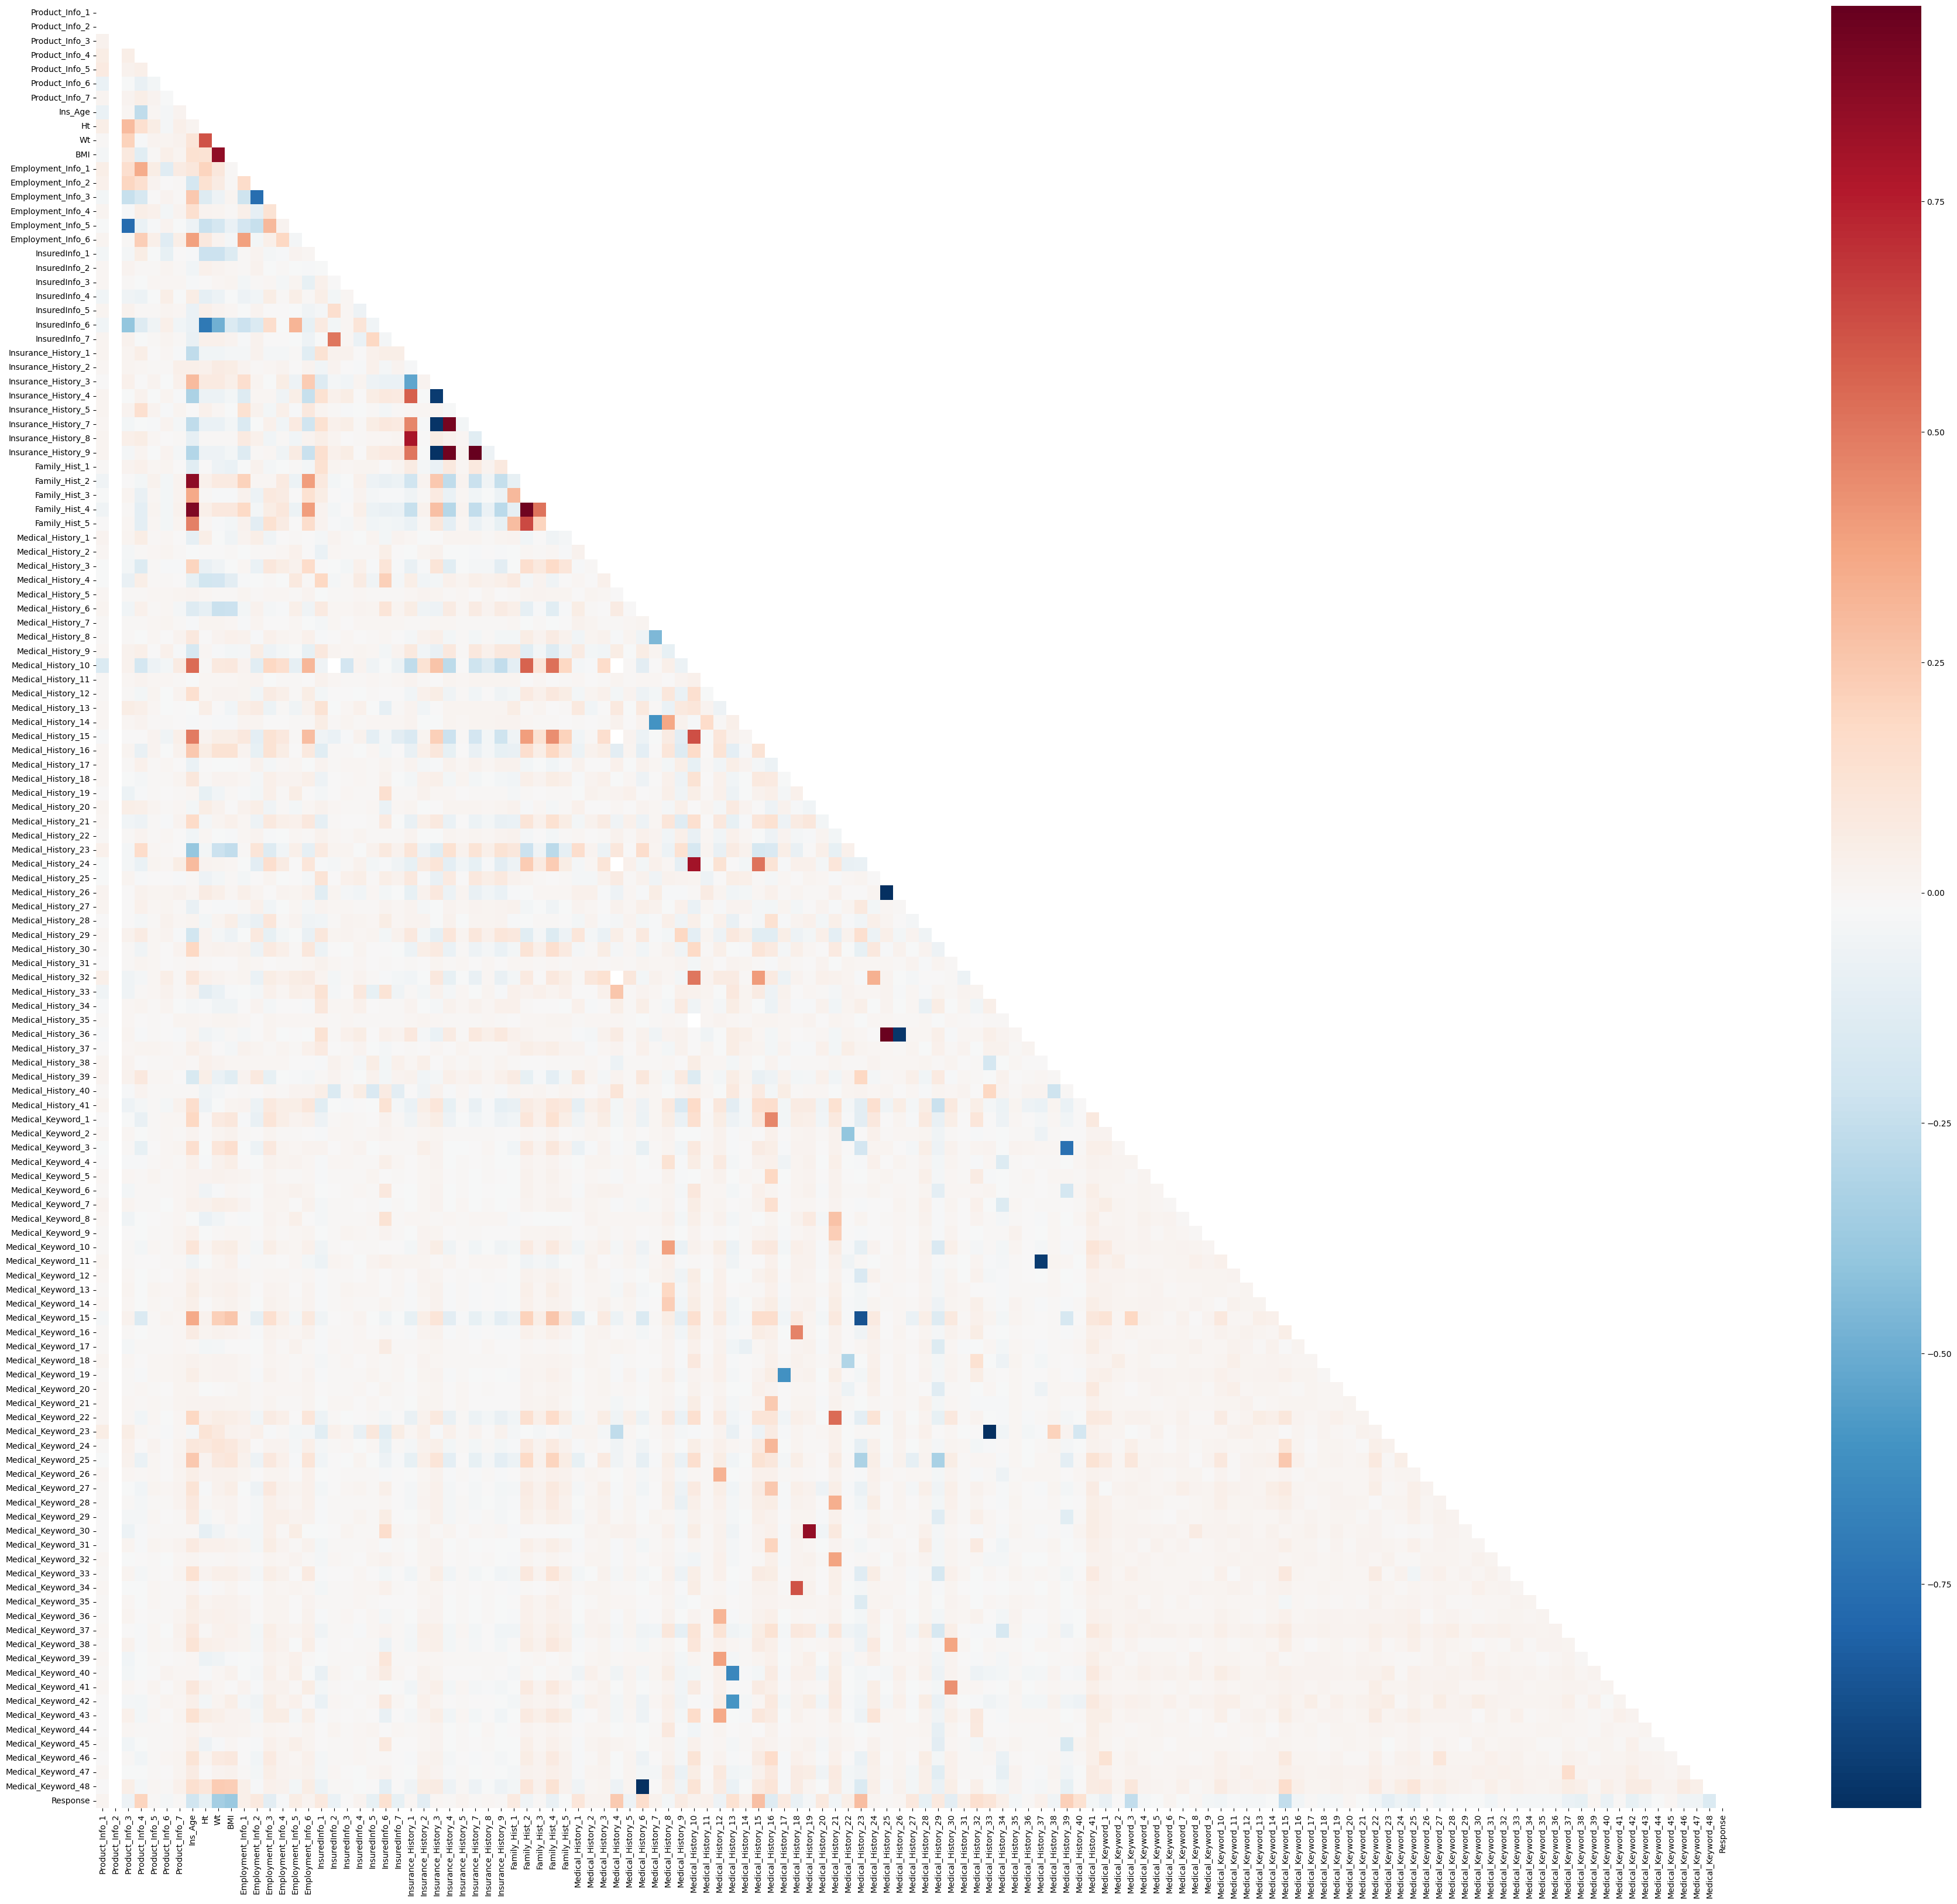

In [16]:
# Replace non-numeric values with NaN
main_data_index_set_numeric = main_data_index_set.apply(pd.to_numeric, errors='coerce')

# Produce a correlation matrix of the dataset
corrs = main_data_index_set_numeric.corr()

# Plot the correlation matrix as a heatmap using Seaborn
plt.figure(figsize=(45,40))
sns.heatmap(corrs, cmap='RdBu_r', mask=np.triu(corrs))
plt.show()


Based on the chart above, we can deduce the following insights regarding each column set:

- Column Set 1 - Product Info: These columns demonstrate minimal interaction or correlation with the majority of other feature sets. However, exceptions include Employment_Info_1, Employment_Info_5, and Insured_Info_6, which may directly correlate due to factors such as an applicant's employment or financial status influencing the type of policy or product they apply for.

- Column Set 2 - Applicant Info: These columns display a varied range of interactions with other feature sets. Notably, strong anti-/correlations (excluding those within the same column set) are observed between several Family_Hist columns and Insured_Info_6.

- Column Set 3 - Employment Info: Apart from two notable anti-correlations - between Employment_Info_2 and Employment_Info_3, and Employment_Info_5 and Product_Info_3 - and a few moderate interactions with Employment_Info_6 and Family_Hist_2 / Family_Hist_4, this column set exhibits relatively weak interactions with other features.

- Column Set 4 - Insured Info: The column InsuredInfo_2 shows a relatively strong correlation with InsuredInfo_7, and also strong anticorrelations with some Applicant Info columns. Otherwise, this column set shows limited interactions with other features.

- Column Set 5 - Insurance History Info: This feature set demonstrates several strong inter-correlations among other Insurance_History columns, but does not show significant interactions with other features.

- Column Set 6 - Family History Info: Family_Hist_2 and Family_Hist_4 exhibit a notably strong positive correlation with Ins_Age, as well as with Medical_History_10 and Medical_History_15 to a lesser extent.

- Column Set 7 - Medical History Info: This column set reveals several correlation hotspots with several Medical_Keyword columns, as well as with Ins_Age and some Family_Hist columns.

- Column Set 8 - Medical Keyword Info: These columns exhibit correlation hotspots with several Medical_History columns but do not show significant interactions with other features.

### Missing Values and Excess Zeroes

To avoid test-data leakage during our model validation and testing process, it is crucial to use only a "training" set of data to assess the completeness of our data. Therefore, we will split the full dataset into training, validation, and testing sets. We will then review the training set for missing values and excess zeroes.

<a name='1.3'></a>
## 1.3 Perform a train-validation-test split of the dataset

Here, we will create separate dataframes to store the features and target variables.

These dataframes will then be used with the train_test_split() function from scikit-learn to split the data into training, validation, and test subsets.

In [17]:
# Assign the features to their own dataframe.
X_full = main_data_index_set.drop(['Response'], axis=1)

# Assign the target variable to its own dataframe.
y_full = main_data_index_set.Response

# Perform a train-test split to obtain the training, validation and test data as separate dataframes.
from sklearn.model_selection import train_test_split

# Split out test/holdout set from full dataset.
# We will set the size of the X/y test datasets to be 20% of the original (full) X/y datasets, via the train_size/test_size parameters.
X_rem, X_test, y_rem, y_test = train_test_split(X_full, y_full, train_size=0.8, test_size=0.2, random_state=0, stratify=y_full)

# Split remaining portion into training/validation sets.
# We will set the size of the X/y train datasets to be 60% of the original (full) X/y datasets, via the train_size/test_size parameters.
X_train, X_valid, y_train, y_valid = train_test_split(X_rem, y_rem, train_size=0.75, test_size=0.25, random_state=0, stratify=y_rem)

<a name='1.4'></a>
## 1.4 Handling missing values

We will now review the training subset to identify where missing values occur. We assume that any missing data are Missing Completely at Random (MCAR) and that any subsequent analysis or imputation will not introduce implicit bias.

In [18]:
# Determine which columns contain nulls/missing values.
X_train_cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# Summarise how many missing values are present in each column.
X_train[X_train_cols_with_missing].isna().sum()

Employment_Info_1         16
Employment_Info_4       4002
Employment_Info_6       6518
Insurance_History_5    15196
Family_Hist_2          17141
Family_Hist_3          20591
Family_Hist_4          11458
Family_Hist_5          25107
Medical_History_1       5368
Medical_History_10     35299
Medical_History_15     26744
Medical_History_24     33312
Medical_History_32     34980
dtype: int64

In [19]:
## Calculate the proportion of zeroes relative to non-zero values.
for col in X_train_cols_with_missing:
    sum = X_train[col].isna().sum()
    length = len(X_train[col].index)
    ratio = sum/length
    print('Proportion of zeroes in', col, 'is: ', round(ratio*100,2), '%.')

Proportion of zeroes in Employment_Info_1 is:  0.04 %.
Proportion of zeroes in Employment_Info_4 is:  11.23 %.
Proportion of zeroes in Employment_Info_6 is:  18.29 %.
Proportion of zeroes in Insurance_History_5 is:  42.65 %.
Proportion of zeroes in Family_Hist_2 is:  48.11 %.
Proportion of zeroes in Family_Hist_3 is:  57.79 %.
Proportion of zeroes in Family_Hist_4 is:  32.16 %.
Proportion of zeroes in Family_Hist_5 is:  70.47 %.
Proportion of zeroes in Medical_History_1 is:  15.07 %.
Proportion of zeroes in Medical_History_10 is:  99.08 %.
Proportion of zeroes in Medical_History_15 is:  75.06 %.
Proportion of zeroes in Medical_History_24 is:  93.5 %.
Proportion of zeroes in Medical_History_32 is:  98.18 %.


Several columns have been identified in the code above with varying proportions of missing values. Some columns have manageable amounts of missing data and can be preprocessed using imputation methods. However, a few columns are highly incomplete. To avoid introducing significant bias into these features' distributions, we will delete columns where the proportion of missing values in the training subset exceeds 40%.

In [20]:
# These columns have been selected as they contain a high proportion of blanks/missing values (deemed here as >40%) in the TRAINING dataset.
cols_to_delete_due_to_missing_data = ['Insurance_History_5',
                                      'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_5',
                                      'Medical_History_10', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32']

# Delete columns from ALL datasets where the proportion of zeroes in the TRAINING dataset exceeds a stipulated threshold.
X_train = X_train.drop(cols_to_delete_due_to_missing_data, axis=1)
X_valid = X_valid.drop(cols_to_delete_due_to_missing_data, axis=1)
X_test = X_test.drop(cols_to_delete_due_to_missing_data, axis=1)

In [21]:
# These columns still contain missing values, and require imputation before they can be supplied as inputs to each ML classifier.
cols_to_impute = ['Employment_Info_1', 'Employment_Info_4', 'Employment_Info_6',
                 'Family_Hist_4',
                 'Medical_History_1']

In [22]:
# Import the IterativeImputer class from sklearn - NOTE: enable_iterative_imputer also needs to be imported as this is an experimental feature. 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Take a copy of each dataset before transforming.
copy_X_train = X_train.copy()
copy_X_valid = X_valid.copy()
copy_X_test = X_test.copy()

# Filter the splits down to the columns that require imputation.
X_train_pre_impute = copy_X_train[cols_to_impute]
X_valid_pre_impute = copy_X_valid[cols_to_impute]
X_test_pre_impute = copy_X_test[cols_to_impute]

# Save the other columns into separate dataframes, for re-joining later on.
X_train_no_impute = copy_X_train.drop(cols_to_impute, axis=1)
X_valid_no_impute = copy_X_valid.drop(cols_to_impute, axis=1)
X_test_no_impute = copy_X_test.drop(cols_to_impute, axis=1)

# Initialise the IterativeImputer transformer.
X_imputer = IterativeImputer(random_state=0)

# Transform the train/val/test datasets using iterative imputation.
X_train_post_impute = pd.DataFrame(X_imputer.fit_transform(X_train_pre_impute), columns=X_train_pre_impute.columns)
X_valid_post_impute = pd.DataFrame(X_imputer.transform(X_valid_pre_impute), columns=X_valid_pre_impute.columns)
X_test_post_impute = pd.DataFrame(X_imputer.transform(X_test_pre_impute), columns=X_train_pre_impute.columns)

# Reset the indexes of each dataset, as they are dropped during imputation.
X_train_post_impute.index = X_train_pre_impute.index
X_valid_post_impute.index = X_valid_pre_impute.index
X_test_post_impute.index = X_test_pre_impute.index

# Re-join the imputed columns with the remaining columns in each dataset.
X_train_imputed = pd.concat([X_train_no_impute, X_train_post_impute], axis=1)
X_valid_imputed = pd.concat([X_valid_no_impute, X_valid_post_impute], axis=1)
X_test_imputed = pd.concat([X_test_no_impute, X_test_post_impute], axis=1)

### Checks - before/after iterative imputation
We will now review the dataset both before and after iterative imputation to understand how each column's distribution has been affected.

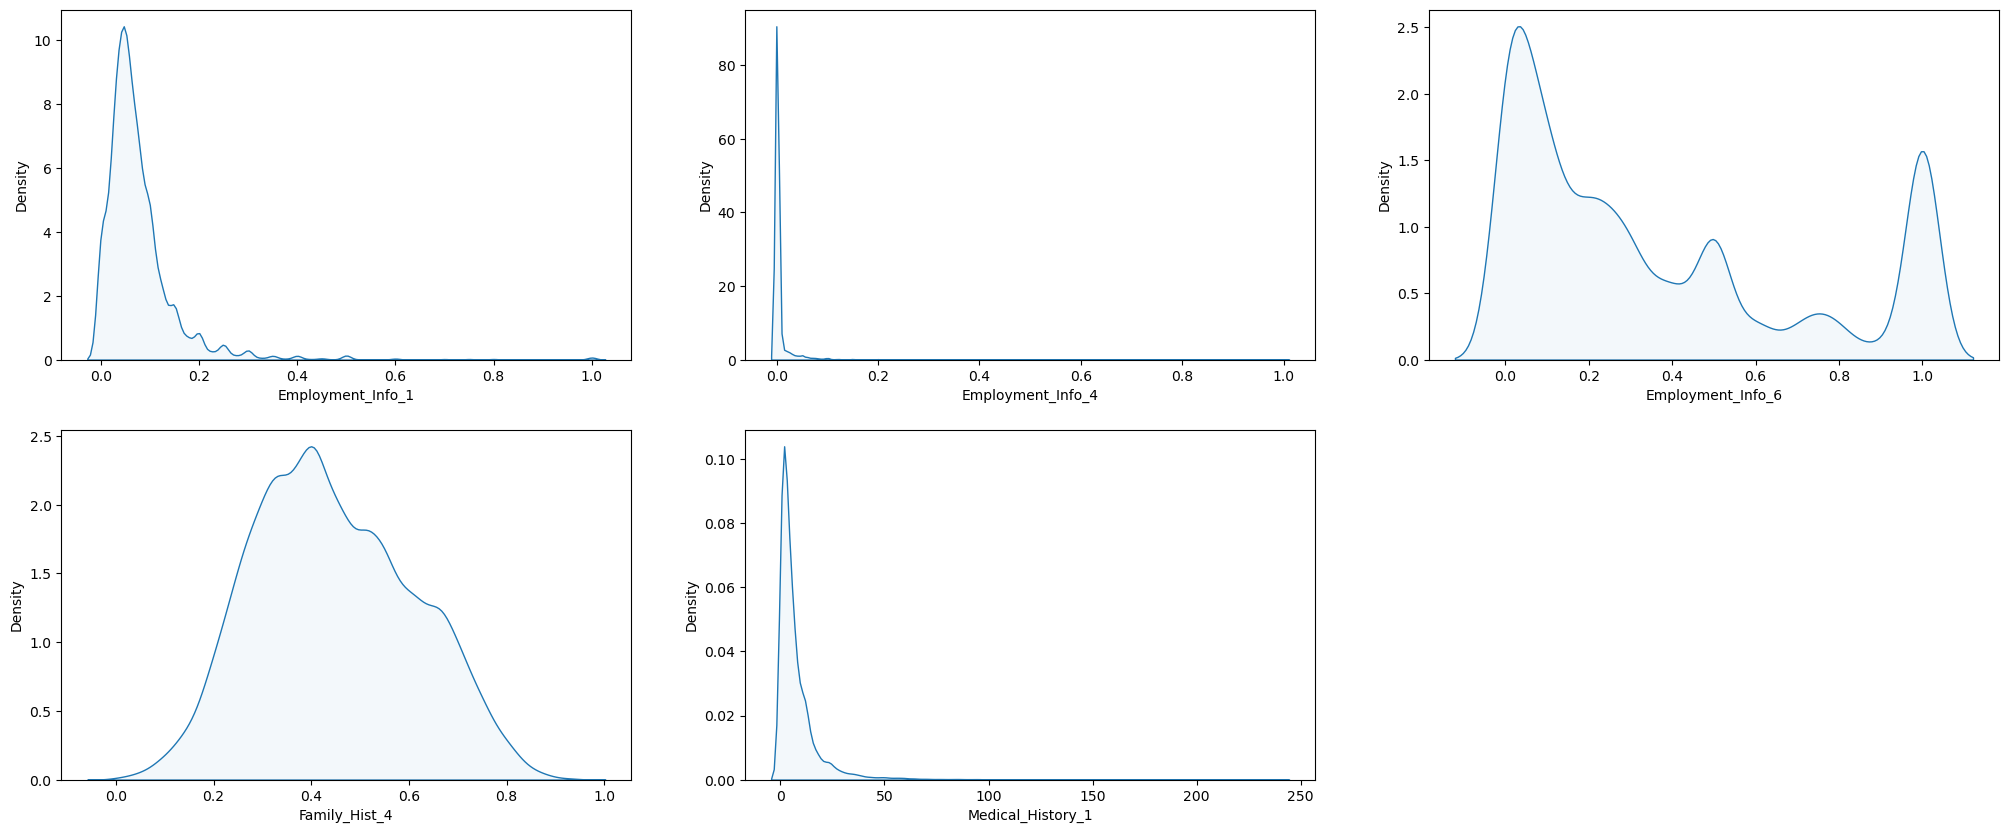

In [23]:
# KDE Plots - Before imputation.

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,10))

for i, column in enumerate(main_data_index_set[X_train_post_impute.columns].columns):
    sns.kdeplot(data=main_data_index_set[X_train_post_impute.columns],
                x=column,
                fill=True, common_norm=True, alpha=0.05,
                ax=axes[i//3,i%3])
    
fig.delaxes(axes[1,2])

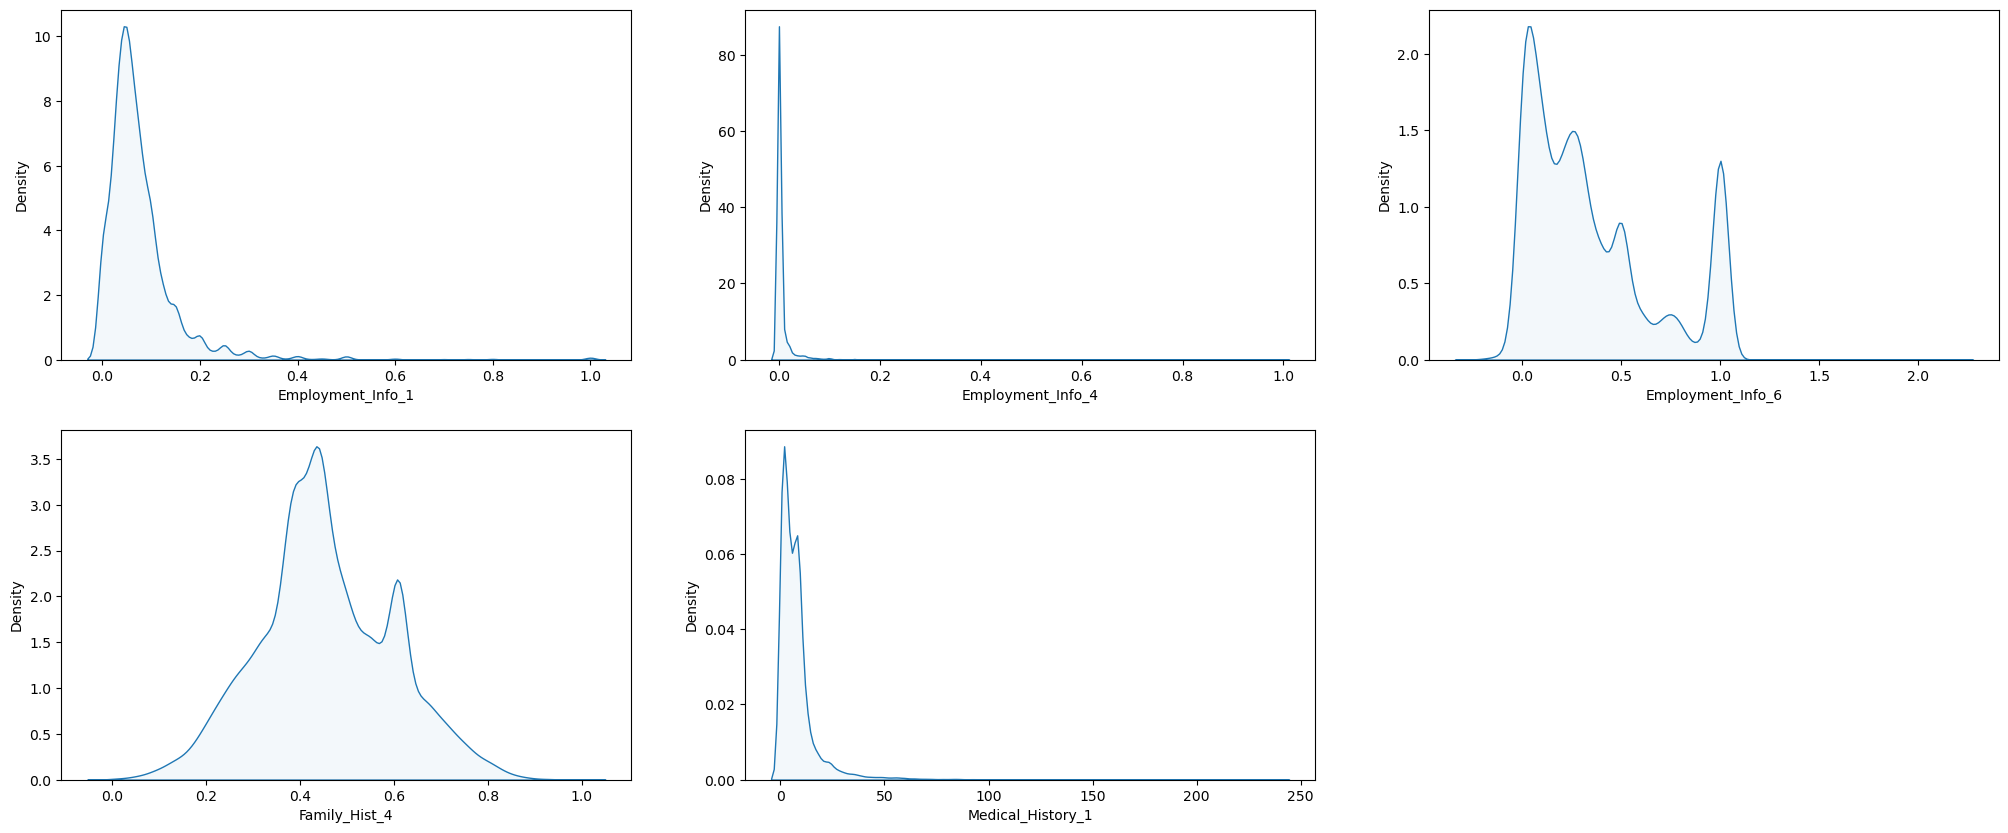

In [24]:
# KDE Plots - After imputation.

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,10))

for i, column in enumerate(X_train_post_impute.columns):
    sns.kdeplot(data=X_train_post_impute,
                x=column,
                fill=True, common_norm=True, alpha=0.05,
                ax=axes[i//3,i%3])
    
fig.delaxes(axes[1,2])

As shown above, three of the five columns' distributions appear to be mostly unchanged. However, we have introduced additional probability density and peak splitting in Family_Hist_4 (at approximately x=0.4 and x=0.6) and Medical_History_1 (at approximately x=10).

<a name='2'></a>
# 2. Perform feature engineering (using training data)

In this section, we will normalise the data, implement categorical encoding and K-means clustering in order to create new features within our dataset that our model can be fitted to.

In [25]:
# Create a clone copy of each imputed dataset to avoid changing any original data.
copy_X_train_imputed = X_train_imputed.copy()
copy_X_valid_imputed = X_valid_imputed.copy()
copy_X_test_imputed = X_test_imputed.copy()

<a name='2.1'></a>
### 2.1. One-Hot Encoding

We will one-hot encode the Product_Info_2 column to convert categorical inputs into numerical, machine-interpretable values.

In [26]:
from sklearn.preprocessing import OneHotEncoder

# Initialise a one-hot encoder to columns that contain categorical data.
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_col = ['Product_Info_2']

## We set handle_unknown='ignore' to avoid errors when the validation data contains classes that aren't represented
## in the training data, and setting sparse=False ensures that the encoded columns are returned as a numpy array
## (instead of a sparse matrix).

# Use the one-hot encoder to transform the categorical data columns. 
OH_col_train = pd.DataFrame(OH_encoder.fit_transform(copy_X_train_imputed[OH_col]))
OH_col_valid = pd.DataFrame(OH_encoder.transform(copy_X_valid_imputed[OH_col]))
OH_col_test = pd.DataFrame(OH_encoder.transform(copy_X_test_imputed[OH_col]))

# One-hot encoding removes the index; re-assign the original index.
OH_col_train.index = copy_X_train_imputed.index
OH_col_valid.index = copy_X_valid_imputed.index
OH_col_test.index = copy_X_test_imputed.index

# Add column-labelling back in, using the get_feature_names() function. 
OH_col_train.columns = OH_encoder.get_feature_names_out(OH_col)
OH_col_valid.columns = OH_encoder.get_feature_names_out(OH_col)
OH_col_test.columns = OH_encoder.get_feature_names_out(OH_col)

# Create dataframes that only include the numerical features/columns (these will be concatenated with the one-hot encoded dataframes).
copy_X_train_imputed_no_OH_col = copy_X_train_imputed.drop(OH_col, axis=1)
copy_X_valid_imputed_no_OH_col = copy_X_valid_imputed.drop(OH_col, axis=1)
copy_X_test_imputed_no_OH_col = copy_X_test_imputed.drop(OH_col, axis=1)

# Concatenate the one-hot encoded columns with the existing numerical features/columns.
X_train_enc = pd.concat([copy_X_train_imputed_no_OH_col, OH_col_train], axis=1)
X_valid_enc = pd.concat([copy_X_valid_imputed_no_OH_col, OH_col_valid], axis=1)
X_test_enc = pd.concat([copy_X_test_imputed_no_OH_col, OH_col_test], axis=1)

<a name='2.2'></a>
### 2.2 Normalization
Next, we will perform min-max normalization on the encoded datasets, ensuring that all features lie between 0 and 1.

In [27]:
from sklearn.preprocessing import MinMaxScaler

# Initialise the MinMaxScaler model, then fit it to the (encoded) training dataset.
MM_scaler = MinMaxScaler()
MM_scaler.fit(X_train_enc)

# Then, normalise/transform the training, validation and test datasets.
X_train_scale = pd.DataFrame(MM_scaler.transform(X_train_enc),
                             index=X_train_enc.index,
                             columns=X_train_enc.columns)

X_valid_scale = pd.DataFrame(MM_scaler.transform(X_valid_enc),
                             index=X_valid_enc.index,
                             columns=X_valid_enc.columns)

X_test_scale = pd.DataFrame(MM_scaler.transform(X_test_enc),
                             index=X_test_enc.index,
                             columns=X_test_enc.columns)

<a name='2.3'></a>
### 2.3 K-means clustering

In [28]:
# Create copies of the scaled datasets, prior to performing K-Means clustering.
copy_X_train_scale = X_train_scale.copy()
copy_X_valid_scale = X_valid_scale.copy()
copy_X_test_scale = X_test_scale.copy()

from sklearn.cluster import KMeans

In [29]:
# Determine the optimal number of clusters.
# Method: Cluster the dataset into k clusters, then calculate the inertia/sum of squared distances.
# Repeat this by looping through k=1 to k=30.

Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k, n_init='auto')
    km = km.fit(copy_X_train_scale)
    Sum_of_squared_distances.append(km.inertia_)

In [30]:
# Determine the optimal number of clusters.
# Method: Cluster the dataset into k clusters, then calculate the inertia/sum of squared distances.
# Repeat this by looping through k=1 to k=30.

Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k, n_init='auto')
    km = km.fit(copy_X_train_scale)
    Sum_of_squared_distances.append(km.inertia_)

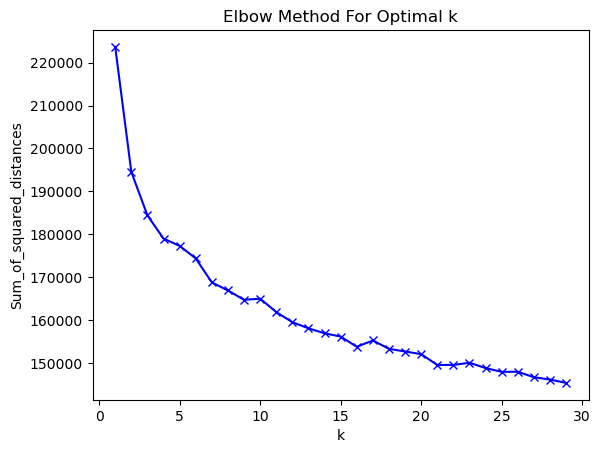

In [31]:
# Create a plot of K-values versus their respective inertias/sums of squared distances.
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

As shown above, the "elbow" of the curve begins to form at k=15.

Increasing k beyond this value does not yield a significant benefit in the rate of reduction in the training dataset's inertia - hence, we will set k=15 when initialising the KMeans() clustering algorithm below.

In [32]:
# Set n_clusters=15, as derived from the elbow-method analysis above:
kmeans = KMeans(n_clusters=15, n_init=10, random_state=0)

# Fit the K-Means clustering algorithm to the training dataset, then predict the train/valid/test datasets.
copy_X_train_scale["Cluster"] = kmeans.fit_predict(copy_X_train_scale)
copy_X_valid_scale["Cluster"] = kmeans.predict(copy_X_valid_scale)
copy_X_test_scale["Cluster"] = kmeans.predict(copy_X_test_scale)

# Convert the cluster labels into one-hot encoded variants.
X_train_cluster_OH_enc = pd.get_dummies(copy_X_train_scale.Cluster).add_prefix('KMeansCluster_')
X_valid_cluster_OH_enc = pd.get_dummies(copy_X_valid_scale.Cluster).add_prefix('KMeansCluster_')
X_test_cluster_OH_enc = pd.get_dummies(copy_X_test_scale.Cluster).add_prefix('KMeansCluster_')

# Re-join the K-Means clustering labels onto the original dataframes.
X_train_KMeans = pd.concat([copy_X_train_scale, X_train_cluster_OH_enc], axis=1)
X_valid_KMeans = pd.concat([copy_X_valid_scale, X_valid_cluster_OH_enc], axis=1)
X_test_KMeans = pd.concat([copy_X_test_scale, X_test_cluster_OH_enc], axis=1)

# Remove the initially derived "Cluster" columns from each dataset.
X_train_KMeans = X_train_KMeans.drop(['Cluster'], axis=1)
X_valid_KMeans = X_valid_KMeans.drop(['Cluster'], axis=1)
X_test_KMeans = X_test_KMeans.drop(['Cluster'], axis=1)

<a name='2.4'></a>
### 2.4 Feature selection 

We will perform feature selection using validation data via L1 (lasso) regularisation using functions that are readily available in sklearn - for more information, see this link: Feature Selection via scikit-learn.

In [33]:
# Import key modules in order to perform LASSO-based feature selection.
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# Establish the Lasso (L1) Regularisation model that will perform feature selection.
linearsvc = LinearSVC(penalty="l1", dual=False, tol=1e-3, C=1e-2, random_state=0).fit(X_valid_KMeans, y_valid)
model = SelectFromModel(linearsvc, prefit=True)

# Reduce the dataset to the most important features, using the regularisation model above.
X_valid_L1 = model.transform(X_valid_KMeans)

# Convert the transformed dataset into a dataframe with the same size/shape as the original dataset.
# For features that were previously removed, this dataset will now include zeroes instead of their original values.
selected_features = pd.DataFrame(model.inverse_transform(X_valid_L1),
                                 index=X_valid_KMeans.index,
                                 columns=X_valid_KMeans.columns)

# Drop columns from the dataframe where features are deemed unimportant in capturing the dataset's variance.
# To achieve this, we selectively drop columns where their variance is equal to 0 (i.e. where a column only contains zeroes).
X_valid_L1reg = selected_features.drop(selected_features.columns[selected_features.var() == 0], axis=1)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [34]:
# Determine the number of columns that are kept after L1 regularisation.

len(selected_features.columns[selected_features.var() != 0])

57

In [35]:
# Produce a separate list containing the columns preserved after L1 regularisation.
selected_columns = selected_features.columns[selected_features.var() != 0]

# Reduce the training/test datasets to the same set of columns.
X_train_L1reg = X_train_KMeans[selected_columns]
X_test_L1reg = X_test_KMeans[selected_columns]


In [36]:
# Label-encode each dataset for compatibility with the XGBoost classifier (model 12) - "use_label_encoder" has since become deprecated.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


# Convert each set of class labels (1-8) into encoded labels (0-7).
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

In [37]:
#Save Preprocessed Datasets 
X_train_L1reg.to_csv('X_train_preprocessed.csv')
X_valid_L1reg.to_csv('X_valid_preprocessed.csv')
X_test_L1reg.to_csv('X_test_preprocessed.csv')

In [38]:
# Convert pandas dataframes to numpy arrays for hyperparameter tuning

X_train_L1reg_np=X_train_L1reg.to_numpy().astype('float32')
X_test_L1reg_np=X_test_L1reg.to_numpy().astype('float32')
X_valid_L1reg_np=X_valid_L1reg.to_numpy().astype('float32')


<a name='3'></a>
# 3. Model Development


The basic model architecture we have selected is the standard model for tabular data: a multilayer perceptron. To avoid the vanishing gradients problem, each hidden layer will have RELU as the activation function, and the optimization algorithm will be backpropagation.

$$Input -> (Linear -> RELU) x #Hidden Layers -> Output$$

During the iterative development of our model, following the strategy at [(#)], we will explore, optimize, and evaluate two variations of this architecture.

- ### Model 1: Regular Multilayer Perceptron
The output layer of this model uses the softmax activation function, and the loss function is cross-entropy, as is standard for multi-classification problems.

$$Input -> (Linear -> RELU) x #Hidden Layers -> SOFTMAX$$

- ### Model 2: Ordinal Multilayer Perceptron
The structure of the hidden layers is the same as the previous model, but the last layer is a logits layer with 7 units, each representing a conditional probability score - the probability of the data point belonging to a class greater than the unit's class given that it belongs to a class greater or equal to it. The loss function will be the CoRan Loss function as presented in the paper [()]. This method accounts for the ordinal nature of the classification problem.

$$Input -> (Linear -> RELU) x #Hidden Layers -> LOGITS$$

We will also consider batch normalization for more rapid convergence of the model and for its regularizing effects. Additionally, we'll employ dropout layers as a regularization method, exploring different rates if a model exhibits significant variance.

$$Input -> ( (Batch_Norm ->) Linear -> (Dropout ->) RELU ) x #Hidden Layers -> Output$$

We will utilize the TensorFlow Keras Sequential API to construct the multilayer perceptron models and leverage the TensorFlow KerasTuner API for efficient hyperparameter tuning of the models. We'll employ the hyperband search method to tune the number of layers, units per layer, learning rate, and mini-batch size hyperparameters, choosing them to minimize the loss function of each model.

The metric that will ultimately decide the best model will be the Quadratic Weighted Kappa metric, tailored for ordinal classification tasks and used in the Prudential Financial Kaggle competition to evaluate performance. We will consider a performance of 0.679 in this metric as our baseline, as it was the best performance in the competition.

<a name='3.1'></a>
## 3.1 Quadratic Weighted Kappa Metric Implementation

We have implemented the quadratic weighted kappa metric for tensors to use it with the Keras Tuner API.

In [39]:
# Metric for the hyperparameter optimization of ordinal classification tasks
@keras.saving.register_keras_serializable(package="custom_package", name="QuadraticWeightedKappa")
def QuadraticWeightedKappa(y_true, y_pred_probs, N=8):
    
    """
    Calculate quadratic weighted kappa metric.

    Args:
    - y_true: tf.Tensor of true labels (actual risk) 
    - y_pred_probs: tf.Tensor of predicted probabilities (predicted risk) 
    - N: number of possible ratings

    Returns:
    - Quadratic weighted kappa score
    """

    # Convert probabilities to class predictions        
    y_pred = tf.argmax(y_pred_probs, axis=1)
    
    # Calculate the histogram matrix O
    O = tf.math.confusion_matrix(y_true, y_pred, num_classes=N)
    
    # Calculate the weights matrix w
    i, j = tf.meshgrid(tf.range(N), tf.range(N), indexing='ij')
    w = tf.cast((i - j) ** 2, tf.float32) / tf.cast((N - 1) ** 2, tf.float32)

    # Calculate the histogram matrix of expected ratings E
    hist_true = tf.math.bincount(tf.cast(y_true, tf.int32), minlength=N)
    hist_pred = tf.math.bincount(tf.cast(y_pred, tf.int32), minlength=N)
    E = tf.linalg.matmul(tf.expand_dims(hist_true, axis=-1), tf.expand_dims(hist_pred, axis=0))
    E = tf.cast(E, tf.float32)  # Cast E to float32
    E *= tf.cast(tf.reduce_sum(O),tf.float32)/ tf.reduce_sum(E) 
    
    # Calculate quadratic weighted kappa
    numerator = tf.reduce_sum(w * tf.cast(O, tf.float32))
    denominator = tf.reduce_sum(w * E)
    kappa = 1 - (numerator / denominator)

    return kappa

<a name='3.2'></a>
## 3.2 Hyperparameter Optimization 

<a name='3.2.1'></a>
### 3.2.1 Model 1: Regular Multilayer Perceptron (MLP)

We will start by constructing the hypermodel to define all hyperparameters and variations of the softmax multilayer perceptron model.

In [40]:
# Set Random seed for reproducibility of initializers
keras.utils.set_random_seed(5)

In [41]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        
        feature_size= 57
        output_size= 8
        
        model = keras.Sequential()
        
        #Hyperparams definition
        hp_layers = hp.Int('hidden_layers', 1, 5, default = 2)
        hp_bn = hp.Boolean('batch_norm', default = False)
        hp_dropout = hp.Boolean('dropout', default = False)
        hp_do_rate= hp.Float('dropout_rate', min_value = 0.1, max_value = 0.5, default = 0.2)
        hp_learning_rate = hp.Float("learning_rate", min_value = 1e-4, max_value = 1e-1, sampling = "log")

        for i in range(1,1+hp_layers):  
            
             model.add(
                 keras.layers.Dense(                      
                     units=hp.Int('units_'+str(i), min_value = 2*output_size,
                     max_value=2*feature_size, step=32), kernel_initializer = 'he_normal'                    
                 )
             )
                
             if hp_bn:   
                model.add(
                   keras.layers.BatchNormalization()
                )
                
             model.add(
                keras.layers.Activation('relu'),                     
             )
               
             if hp_dropout:   
                model.add(
                   keras.layers.Dropout(rate=hp_do_rate)
                )
                
        model.add(keras.layers.Dense(8, activation='softmax'))        
        
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      loss=keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy', QuadraticWeightedKappa])  

        return model
    
    
    def fit(self, hp, model, *args, **kwargs):
            return model.fit(
                *args,
                batch_size = hp.Choice("batch_size", [16, 32, 64, 128, 256, 512, 1024], default = 32),               
                **kwargs,
            )

#### MLP Tuning
We will begin by tuning the hyperparameters that have consistently shown to be the most relevant in the literature: learning rate and batch size, with the fixed values for hidden layers and units per layer set to 2 and 16, respectively. We will not apply batch normalization or dropout at this stage.

In [42]:
# Tune only the learning rate and the mini-batch size hyperparameters

hp_mlp_1 = kt.HyperParameters()
hp_mlp_1.Float("learning_rate", min_value=1e-4, max_value=1e-1, sampling="log")
hp_mlp_1.Choice("batch_size", [16, 32, 64, 128, 256, 512, 1024])

tuner_mlp_1 = kt.Hyperband(
hypermodel = MyHyperModel(),
hyperparameters = hp_mlp_1,
tune_new_entries = False,
objective = 'val_accuracy',
directory = "Tuners/Tuner_MLP_1",
project_name = "Search_1",
seed = 5,
)

Reloading Tuner from Tuners/Tuner_MLP_1\Search_1\tuner0.json


In [43]:
tuner_mlp_1.search_space_summary()

Search space summary
Default search space size: 2
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
batch_size (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512, 1024], 'ordered': True}


In [44]:
tuner_mlp_1.search(X_train_L1reg_np, y_train, validation_data=(X_valid_L1reg_np, y_valid), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights= True)])

In [45]:
tuner_mlp_1.results_summary()

Results summary
Results in Tuners/Tuner_MLP_1\Search_1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0146 summary
Hyperparameters:
learning_rate: 0.001526017960390335
batch_size: 16
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
hidden_layers: 2
batch_norm: False
dropout: False
do_rate: 0.2
units_1: 16
units_2: 16
tuner/trial_id: 0143
Score: 0.5291343927383423

Trial 0235 summary
Hyperparameters:
learning_rate: 0.0016978251488635758
batch_size: 16
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
hidden_layers: 2
batch_norm: False
dropout: False
do_rate: 0.2
units_1: 16
units_2: 16
tuner/trial_id: 0230
Score: 0.5267766714096069

Trial 0147 summary
Hyperparameters:
learning_rate: 0.004426737982217423
batch_size: 64
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
hidden_layers: 2
batch_norm: False
dropout: False
do_rate: 0.2
units_1: 16
units_2: 16
tuner/trial_id: 0142
Score: 0.52

In [47]:
# Get the optimal hyperparameters
hyps_mlp_1 = tuner_mlp_1.get_best_hyperparameters(num_trials=1)[0]
print(hyps_mlp_1.values)

{'learning_rate': 0.001526017960390335, 'batch_size': 16, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 4, 'tuner/round': 4, 'hidden_layers': 2, 'batch_norm': False, 'dropout': False, 'do_rate': 0.2, 'units_1': 16, 'units_2': 16, 'tuner/trial_id': '0143'}


Now that we have the optimal values of the learning rate and batch size, let's look for the optimal size of the network.

In [48]:
hp_mlp_2 = kt.HyperParameters()

# Fix

hp_mlp_2.Fixed("learning_rate", value = hyps_mlp_1["learning_rate"])
hp_mlp_2.Fixed("batch_size", value = hyps_mlp_1["batch_size"])
hp_mlp_2.Fixed("batch_norm", value = False)
hp_mlp_2.Fixed("dropout", value = False)
hp_mlp_2.Fixed("dropout_rate", value = 0.2)

tuner_mlp_2 = kt.Hyperband(
MyHyperModel(),
hyperparameters = hp_mlp_2,
tune_new_entries = True,
objective = 'val_accuracy',
directory = "Tuners/Tuner_MLP_2",
project_name = "Search_1",
seed = 5,
)

Reloading Tuner from Tuners/Tuner_MLP_2\Search_1\tuner0.json


In [47]:
tuner_mlp_2.search_space_summary()

Search space summary
Default search space size: 11
learning_rate (Fixed)
{'conditions': [], 'value': 0.001526017960390335}
batch_size (Fixed)
{'conditions': [], 'value': 16}
batch_norm (Fixed)
{'conditions': [], 'value': False}
dropout (Fixed)
{'conditions': [], 'value': False}
do_rate (Fixed)
{'conditions': [], 'value': 0.2}
hidden_layers (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value'

In [48]:
tuner_mlp_2.search(X_train_L1reg_np, y_train, validation_data=(X_valid_L1reg_np, y_valid), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights= True)])

In [49]:
tuner_mlp_2.results_summary()

Results summary
Results in Tuner_MLP_2\Search_1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0247 summary
Hyperparameters:
learning_rate: 0.001526017960390335
batch_size: 16
batch_norm: False
dropout: False
do_rate: 0.2
hidden_layers: 2
units_1: 16
units_2: 16
units_3: 112
units_4: 16
units_5: 112
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0236
Score: 0.525934636592865

Trial 0252 summary
Hyperparameters:
learning_rate: 0.001526017960390335
batch_size: 16
batch_norm: False
dropout: False
do_rate: 0.2
hidden_layers: 3
units_1: 16
units_2: 16
units_3: 16
units_4: 16
units_5: 48
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.5246716141700745

Trial 0196 summary
Hyperparameters:
learning_rate: 0.001526017960390335
batch_size: 16
batch_norm: False
dropout: False
do_rate: 0.2
hidden_layers: 2
units_1: 48
units_2: 112
units_3: 112
units_4: 48
units_5: 48
tuner/epochs: 12
tuner/in

In [50]:
# Get the optimal hyperparameters
hyps_mlp_2 = tuner_mlp_2.get_best_hyperparameters(num_trials=1)[0]
model_mlp_2 = tuner_mlp_2.hypermodel.build(hyps_mlp_2)

print(hyps_mlp_2.values)

{'learning_rate': 0.001526017960390335, 'batch_size': 16, 'batch_norm': False, 'dropout': False, 'do_rate': 0.2, 'hidden_layers': 2, 'units_1': 16, 'units_2': 16, 'units_3': 112, 'units_4': 16, 'units_5': 112, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0236', 'dropout_rate': 0.2}


Now, we will train the model with the optimized hyperparameters.

In [51]:
# monitor='loss', patience=20, epochs=240
# history_model_mlp_2 = model_mlp_2.fit(x=X_train_L1reg_np, y=y_train, epochs=300, validation_data=(X_valid_L1reg_np, y_valid), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights= True)])
# model_mlp_2.save("Models/model_mlp_2/model.keras")
# with open('Models/model_mlp_2/trainHistoryDict', 'wb') as file_pi:
#     pickle.dump(history_model_mlp_2.history, file_pi)

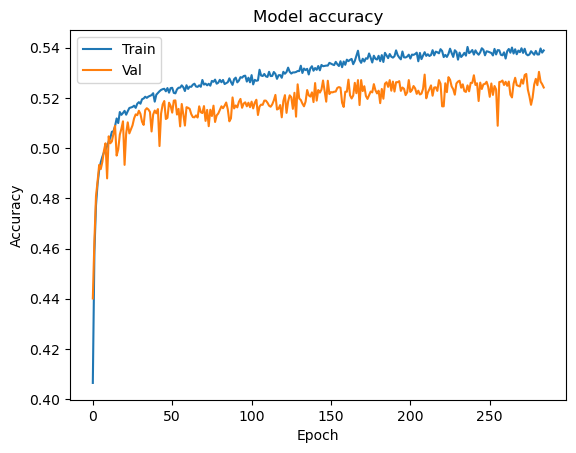

In [52]:
model_mlp_2 = keras.models.load_model("Models/model_mlp_2/model.keras")
with open('Models/model_mlp_2/trainHistoryDict', "rb") as file_pi:
    history_model_mlp_2 = pickle.load(file_pi)

plt.plot(history_model_mlp_2['accuracy'])
plt.plot(history_model_mlp_2['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

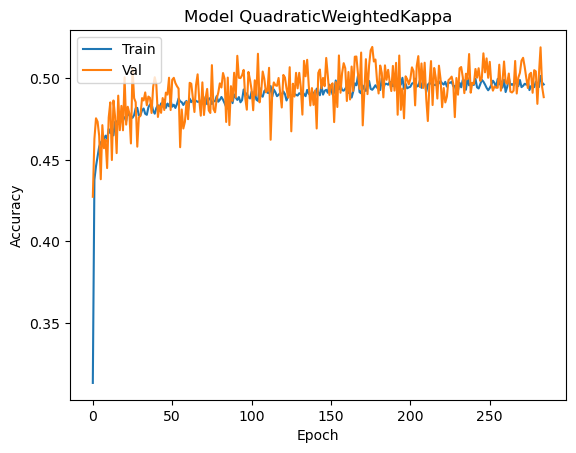

In [53]:
plt.plot(history_model_mlp_2['QuadraticWeightedKappa'])
plt.plot(history_model_mlp_2['val_QuadraticWeightedKappa'])
plt.title('Model QuadraticWeightedKappa')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [54]:
# Performance on training set
print("Train evaluation")
print()
print("[Loss, Accuracy, Average QWK] :", model_mlp_2.evaluate(X_train_L1reg_np, y_train))
qwk_train_model_mlp_2 = QuadraticWeightedKappa(y_train, model_mlp_2.predict(X_train_L1reg_np)).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_train_model_mlp_2)

Train evaluation

1114/1114 [==============================] - 2s 904us/step - loss: 1.2725 - accuracy: 0.5339 - QuadraticWeightedKappa: 0.4847
[Loss, Accuracy, Average QWK] : [1.2724558115005493, 0.5339059233665466, 0.4846748113632202]
1114/1114 [==============================] - 1s 730us/step
Quadratic Weighted Kappa on training set: 0.4950829


In [55]:
# Performance on validation set
print("Validation evaluation")
print()
print("[Loss, Accuracy, Average QWK]:",  model_mlp_2.evaluate(X_valid_L1reg_np, y_valid))
qwk_valid_model_mlp_2 = QuadraticWeightedKappa(y_valid, model_mlp_2.predict(X_valid_L1reg_np)).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_valid_model_mlp_2)

Validation evaluation

372/372 [==============================] - 0s 880us/step - loss: 1.3155 - accuracy: 0.5202 - QuadraticWeightedKappa: 0.4913
[Loss, Accuracy, Average QWK]: [1.3155001401901245, 0.5202088356018066, 0.4912799596786499]
372/372 [==============================] - 0s 719us/step
Quadratic Weighted Kappa on training set: 0.49835402


We observe that there is a high bias and no variance for this model. We won't be trying a larger arquitecture this time since the hyperparameter space of the number of hidden layers was from 1 to 5, and the optimal value found was 2, so its unlikely that the model would favor from a larger arquitecture. We'll therefore opt for optimizing and evaluate the regular multilayer perceptron model adding batch normalization. 

#### MLP + Batch Normalization Tuning

In [56]:
# Tune only the learning rate and the mini-batch size hyperparameters

hp_mlp_1_bn = kt.HyperParameters()
hp_mlp_1_bn.Float("learning_rate", min_value=1e-4, max_value=1e-1, sampling="log")
hp_mlp_1_bn.Choice("batch_size", [16, 32, 64, 128, 256, 512, 1024])

tuner_mlp_1_bn = kt.Hyperband(
hypermodel = MyHyperModel(),
hyperparameters = hp_mlp_1_bn,
tune_new_entries = False,
objective = 'val_accuracy',
directory = "Tuners/Tuner_MLP_BN_1",
project_name = "Search_1",
seed = 5,
)

Reloading Tuner from Tuner_MLP_BN_1\Search_1\tuner0.json


In [57]:
tuner_mlp_1_bn.search_space_summary()

Search space summary
Default search space size: 2
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
batch_size (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512, 1024], 'ordered': True}


In [58]:
tuner_mlp_1_bn.search(X_train_L1reg_np, y_train, validation_data=(X_valid_L1reg_np, y_valid), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights= True)])

In [59]:
tuner_mlp_1_bn.results_summary()

Results summary
Results in Tuner_MLP_BN_1\Search_1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0143 summary
Hyperparameters:
learning_rate: 0.01894635097944879
batch_size: 64
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 4
tuner/round: 3
hidden_layers: 2
batch_norm: True
dropout: False
do_rate: 0.2
units_1: 16
units_2: 16
tuner/trial_id: 0131
Score: 0.5310710668563843

Trial 0234 summary
Hyperparameters:
learning_rate: 0.004940941354973656
batch_size: 32
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
hidden_layers: 2
batch_norm: True
dropout: False
do_rate: 0.2
units_1: 16
units_2: 16
tuner/trial_id: 0229
Score: 0.5305658578872681

Trial 0245 summary
Hyperparameters:
learning_rate: 0.03881688009650394
batch_size: 256
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
hidden_layers: 2
batch_norm: True
dropout: False
do_rate: 0.2
units_1: 16
units_2: 16
tuner/trial_id: 0240
Score: 0.530313253402

In [60]:
# Get the optimal hyperparameters
hyps_mlp_1_bn = tuner_mlp_1_bn.get_best_hyperparameters(num_trials=1)[0]
print(hyps_mlp_1_bn.values)

{'learning_rate': 0.01894635097944879, 'batch_size': 64, 'tuner/epochs': 34, 'tuner/initial_epoch': 12, 'tuner/bracket': 4, 'tuner/round': 3, 'hidden_layers': 2, 'batch_norm': True, 'dropout': False, 'do_rate': 0.2, 'units_1': 16, 'units_2': 16, 'tuner/trial_id': '0131'}


Now that we have the optimal values of the learning rate and batch size, let's look for the optimal size of the network.

In [61]:
hp_mlp_2_bn = kt.HyperParameters()
hp_mlp_2_bn.Fixed("learning_rate", value = hyps_mlp_1_bn["learning_rate"])
hp_mlp_2_bn.Fixed("batch_size", value = hyps_mlp_1_bn["batch_size"])
hp_mlp_2_bn.Fixed("batch_norm", value = True)
hp_mlp_2_bn.Fixed("dropout", value = False)
hp_mlp_2_bn.Fixed("dropout_rate", value = 0.2)

tuner_mlp_2_bn = kt.Hyperband(
MyHyperModel(),
hyperparameters = hp_mlp_2_bn,
tune_new_entries = True,
objective = 'val_accuracy',
directory = "Tuners/Tuner_MLP_BN_2",
project_name = "Search_1",
seed = 5,
)

Reloading Tuner from Tuner_MLP_BN_2\Search_1\tuner0.json


In [62]:
tuner_mlp_2_bn.search_space_summary()

Search space summary
Default search space size: 11
learning_rate (Fixed)
{'conditions': [], 'value': 0.01894635097944879}
batch_size (Fixed)
{'conditions': [], 'value': 64}
batch_norm (Fixed)
{'conditions': [], 'value': True}
dropout (Fixed)
{'conditions': [], 'value': False}
do_rate (Fixed)
{'conditions': [], 'value': 0.2}
hidden_layers (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 

In [63]:
tuner_mlp_2_bn.search(X_train_L1reg_np, y_train, validation_data=(X_valid_L1reg_np, y_valid), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights= True)])

In [64]:
tuner_mlp_2_bn.results_summary()

Results summary
Results in Tuner_MLP_BN_2\Search_1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0245 summary
Hyperparameters:
learning_rate: 0.01894635097944879
batch_size: 64
batch_norm: True
dropout: False
do_rate: 0.2
hidden_layers: 5
units_1: 16
units_2: 80
units_3: 16
units_4: 112
units_5: 16
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0240
Score: 0.5301448106765747

Trial 0252 summary
Hyperparameters:
learning_rate: 0.01894635097944879
batch_size: 64
batch_norm: True
dropout: False
do_rate: 0.2
hidden_layers: 3
units_1: 16
units_2: 16
units_3: 16
units_4: 16
units_5: 48
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.5282081365585327

Trial 0240 summary
Hyperparameters:
learning_rate: 0.01894635097944879
batch_size: 64
batch_norm: True
dropout: False
do_rate: 0.2
hidden_layers: 5
units_1: 16
units_2: 80
units_3: 16
units_4: 112
units_5: 16
tuner/epochs: 34
tuner/initia

In [65]:
# Get the optimal hyperparameters
hyps_mlp_2_bn = tuner_mlp_2_bn.get_best_hyperparameters(num_trials=1)[0]
model_mlp_2_bn = tuner_mlp_2_bn.hypermodel.build(hyps_mlp_2_bn)

print(hyps_mlp_2_bn.values)

{'learning_rate': 0.01894635097944879, 'batch_size': 64, 'batch_norm': True, 'dropout': False, 'do_rate': 0.2, 'hidden_layers': 5, 'units_1': 16, 'units_2': 80, 'units_3': 16, 'units_4': 112, 'units_5': 16, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0240', 'dropout_rate': 0.2}


Now, we will train the model with the optimized hyperparameters.

In [66]:
# monitor='loss', patience=20, epochs=300
# history_model_mlp_2_bn = model_mlp_2_bn.fit(x=X_train_L1reg_np, y=y_train, epochs=300, validation_data=(X_valid_L1reg_np, y_valid), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights= True)])
# model_mlp_2_bn.save("Models/model_mlp_2_bn/model.keras")
# with open('Models/model_mlp_2_bn/trainHistoryDict', 'wb') as file_pi:
#     pickle.dump(history_model_mlp_2_bn.history, file_pi)

In [67]:
model_mlp_2_bn = keras.models.load_model("Models/model_mlp_2_bn/model.keras")
with open('Models/model_mlp_2_bn/trainHistoryDict', "rb") as file_pi:
    history_model_mlp_2_bn = pickle.load(file_pi)

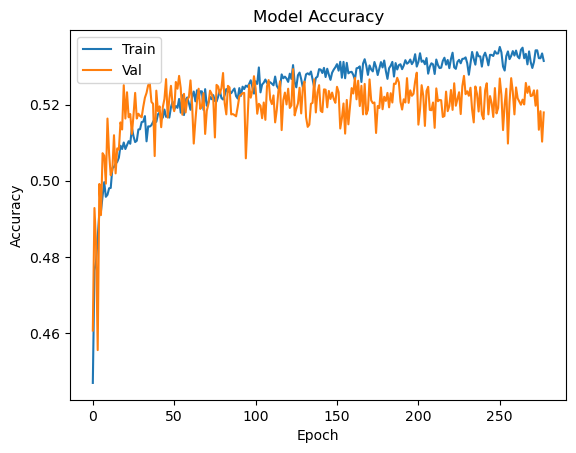

In [68]:
plt.plot(history_model_mlp_2_bn['accuracy'])
plt.plot(history_model_mlp_2_bn['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

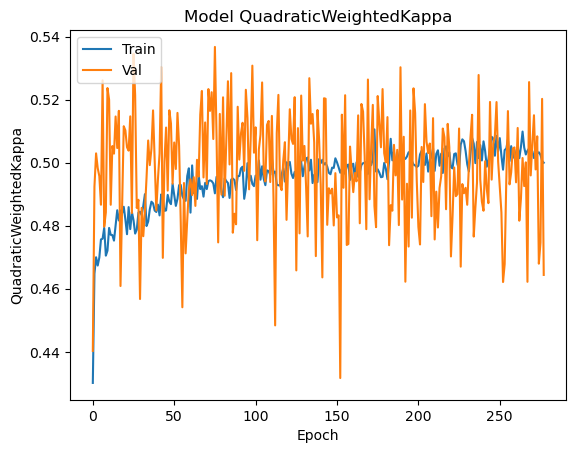

In [69]:
plt.plot(history_model_mlp_2_bn['QuadraticWeightedKappa'])
plt.plot(history_model_mlp_2_bn['val_QuadraticWeightedKappa'])
plt.title('Model QuadraticWeightedKappa')
plt.ylabel('QuadraticWeightedKappa')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [70]:
# Performance on training set
print("Train evaluation")
print()
print("[Loss, Accuracy, Average QWK] :", model_mlp_2_bn.evaluate(X_train_L1reg_np, y_train))
qwk_train_model_mlp_2_bn = QuadraticWeightedKappa(y_train, model_mlp_2_bn.predict(X_train_L1reg_np)).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_train_model_mlp_2_bn)

Train evaluation

1114/1114 [==============================] - 2s 967us/step - loss: 1.2186 - accuracy: 0.5544 - QuadraticWeightedKappa: 0.5039
[Loss, Accuracy, Average QWK] : [1.2186065912246704, 0.5543673634529114, 0.503919243812561]
1114/1114 [==============================] - 1s 809us/step
Quadratic Weighted Kappa on training set: 0.51428294


In [71]:
# Performance on validation set
print("Validation evaluation")
print()
print("[Loss, Accuracy, Average QWK]:",  model_mlp_2_bn.evaluate(X_valid_L1reg_np, y_valid))
qwk_valid_model_mlp_2_bn = QuadraticWeightedKappa(y_valid, model_mlp_2_bn.predict(X_valid_L1reg_np)).numpy()
print("Quadratic Weighted Kappa on validation set:", qwk_valid_model_mlp_2_bn)

Validation evaluation

372/372 [==============================] - 0s 969us/step - loss: 1.3173 - accuracy: 0.5269 - QuadraticWeightedKappa: 0.4969
[Loss, Accuracy, Average QWK]: [1.317258596420288, 0.5269451141357422, 0.4969393312931061]
372/372 [==============================] - 0s 845us/step
Quadratic Weighted Kappa on validation set: 0.50315464


In [72]:
baseline = 0.67938
model_mlp_2_bn_bias = baseline-qwk_train_model_mlp_2_bn
model_mlp_2_bn_var = qwk_train_model_mlp_2_bn-qwk_valid_model_mlp_2_bn
print("Bias / Variance of the model: ")
print(round(model_mlp_2_bn_bias,3),"/",round(model_mlp_2_bn_var,3))

Bias / Variance of the model: 
0.165 / 0.011


Since there's a larger bias than variance, and the optimal number of layers found in the last search was the largest value of the hyperparameter search space, we'll attempt to reduce the bias by increasing the number of layers, for which we will be tuning them from 6 to 8.

In [73]:
hp_mlp_3_bn = kt.HyperParameters()
hp_mlp_3_bn.Fixed("learning_rate", value = hyps_mlp_1_bn["learning_rate"])
hp_mlp_3_bn.Fixed("batch_size", value = hyps_mlp_1_bn["batch_size"])
hp_mlp_3_bn.Fixed("batch_norm", value = True)
hp_mlp_3_bn.Fixed("dropout", value = False)
hp_mlp_3_bn.Fixed("dropout_rate", value = 0.2)
hp_mlp_3_bn.Int('hidden_layers', min_value=6, max_value=8)

tuner_mlp_3_bn = kt.Hyperband(
MyHyperModel(),
hyperparameters = hp_mlp_3_bn,
tune_new_entries = True,
objective = 'val_accuracy',
directory = "Tuners/Tuner_MLP_BN_2",
project_name = "Search_2",
seed = 5,
)

Reloading Tuner from Tuner_MLP_BN_2\Search_2\tuner0.json


In [74]:
tuner_mlp_3_bn.search_space_summary()

Search space summary
Default search space size: 14
learning_rate (Fixed)
{'conditions': [], 'value': 0.01894635097944879}
batch_size (Fixed)
{'conditions': [], 'value': 64}
batch_norm (Fixed)
{'conditions': [], 'value': True}
dropout (Fixed)
{'conditions': [], 'value': False}
dropout_rate (Fixed)
{'conditions': [], 'value': 0.2}
hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 6, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_

In [75]:
tuner_mlp_3_bn.search(X_train_L1reg_np, y_train, validation_data=(X_valid_L1reg_np, y_valid), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights= True)])

In [76]:
tuner_mlp_3_bn.results_summary()

Results summary
Results in Tuner_MLP_BN_2\Search_2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0244 summary
Hyperparameters:
learning_rate: 0.01894635097944879
batch_size: 64
batch_norm: True
dropout: False
dropout_rate: 0.2
hidden_layers: 7
units_1: 16
units_2: 16
units_3: 48
units_4: 48
units_5: 80
units_6: 80
units_7: 112
units_8: 80
tuner/epochs: 34
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5286291837692261

Trial 0245 summary
Hyperparameters:
learning_rate: 0.01894635097944879
batch_size: 64
batch_norm: True
dropout: False
dropout_rate: 0.2
hidden_layers: 7
units_1: 16
units_2: 16
units_3: 48
units_4: 48
units_5: 80
units_6: 80
units_7: 112
units_8: 80
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0244
Score: 0.5281239748001099

Trial 0209 summary
Hyperparameters:
learning_rate: 0.01894635097944879
batch_size: 64
batch_norm: True
dropout: False
dropout_rate: 0.2
hidden_layers: 8
uni

In [77]:
# Get the optimal hyperparameters
hyps_mlp_3_bn = tuner_mlp_3_bn.get_best_hyperparameters(num_trials=1)[0]
model_mlp_3_bn = tuner_mlp_3_bn.hypermodel.build(hyps_mlp_2_bn)

print(hyps_mlp_3_bn.values)

{'learning_rate': 0.01894635097944879, 'batch_size': 64, 'batch_norm': True, 'dropout': False, 'dropout_rate': 0.2, 'hidden_layers': 7, 'units_1': 16, 'units_2': 16, 'units_3': 48, 'units_4': 48, 'units_5': 80, 'units_6': 80, 'units_7': 112, 'units_8': 80, 'tuner/epochs': 34, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


Now, we will train the model with the optimized hyperparameters.

In [78]:
# monitor='loss', patience=20, epochs=242
# history_model_mlp_3_bn = model_mlp_3_bn.fit(x=X_train_L1reg_np, y=y_train, epochs=300, validation_data=(X_valid_L1reg_np, y_valid), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights= True)])
# model_mlp_3_bn.save("Models/model_mlp_3_bn/model.keras")
# with open('Models/model_mlp_3_bn/trainHistoryDict', 'wb') as file_pi:
#     pickle.dump(history_model_mlp_3_bn.history, file_pi)

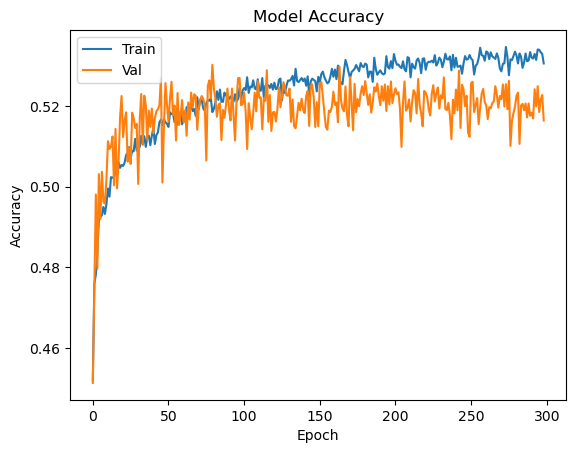

In [79]:
model_mlp_3_bn = keras.models.load_model("Models/model_mlp_3_bn/model.keras")
with open('Models/model_mlp_3_bn/trainHistoryDict', "rb") as file_pi:
    history_model_mlp_3_bn = pickle.load(file_pi)
plt.plot(history_model_mlp_3_bn['accuracy'])
plt.plot(history_model_mlp_3_bn['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

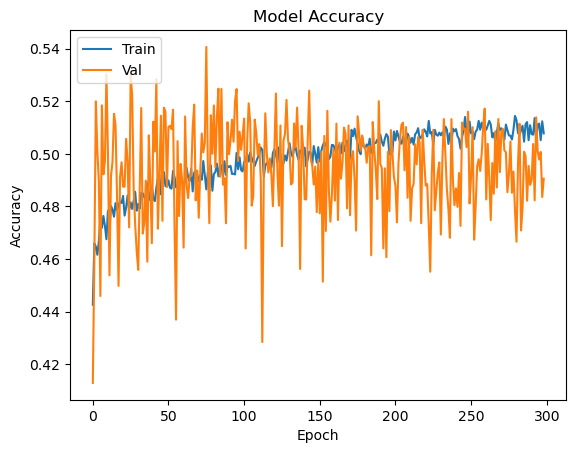

In [80]:
plt.plot(history_model_mlp_3_bn['QuadraticWeightedKappa'])
plt.plot(history_model_mlp_3_bn['val_QuadraticWeightedKappa'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [81]:
# Performance on training set
print("Train evaluation")
print()
print("[Loss, Accuracy, Average QWK] :", model_mlp_3_bn.evaluate(X_train_L1reg_np, y_train))
qwk_train_model_mlp_3_bn = QuadraticWeightedKappa(y_train, model_mlp_3_bn.predict(X_train_L1reg_np)).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_train_model_mlp_3_bn)

Train evaluation

1114/1114 [==============================] - 2s 960us/step - loss: 1.2154 - accuracy: 0.5558 - QuadraticWeightedKappa: 0.5216
[Loss, Accuracy, Average QWK] : [1.2154409885406494, 0.5558269023895264, 0.5215981602668762]
1114/1114 [==============================] - 1s 779us/step
Quadratic Weighted Kappa on training set: 0.53277755


In [82]:
# Performance on validation set
print("Validation evaluation")
print()
print("[Loss, Accuracy, Average QWK]:",  model_mlp_3_bn.evaluate(X_valid_L1reg_np, y_valid))
qwk_valid_model_mlp_3_bn = QuadraticWeightedKappa(y_valid, model_mlp_3_bn.predict(X_valid_L1reg_np)).numpy()
print("Quadratic Weighted Kappa on validation set:", qwk_valid_model_mlp_3_bn)

Validation evaluation

372/372 [==============================] - 0s 1ms/step - loss: 1.3323 - accuracy: 0.5183 - QuadraticWeightedKappa: 0.4933
[Loss, Accuracy, Average QWK]: [1.3323301076889038, 0.5182721614837646, 0.4932715594768524]
372/372 [==============================] - 0s 725us/step
Quadratic Weighted Kappa on validation set: 0.50054276


In [83]:
model_mlp_3_bn_bias = baseline-qwk_train_model_mlp_3_bn
model_mlp_3_bn_var = qwk_train_model_mlp_3_bn-qwk_valid_model_mlp_3_bn
print("Bias / Variance of the model: ")
print(round(model_mlp_3_bn_bias,3),"/",round(model_mlp_3_bn_var,3))

Bias / Variance of the model: 
0.147 / 0.032


The performance with more layers decreased slightly on the validation set and didn't improve significantly on the training set, so for now the version of the MLP with softmax as activation function of the last layer model is the one without batch normalization or dropout with hyperparameters found in the second search (model_mlp_2_bn), we select the multilayer perceptron with batch normalization as the best one so far. Now we'll explore the second model proposed, the CORN model integrated to our multilayer perceptron.

<a name='3.2.2'></a>
### 3.2.2 Model 2: Corn Multilayer Perceptron

In this section, we will discuss the process of developing and optimizing the Ordinal Multilayer Perceptron (CORN MLP). First, we construct the hypermodel of the CORN MLP model, defining the hyperparameters.

In [84]:
class CornHyperModel(kt.HyperModel):
    def build(self, hp):
        
        feature_size = 57
        output_size = 8
        
        model = keras.Sequential()
        
        # Hyperparams definition
        
        hp_learning_rate = hp.Float("learning_rate", min_value = 1e-4, max_value = 1e-1, sampling = "log")
        hp_layers = hp.Int('hidden_layers', 1, 5, default = 2)
        hp_bn = hp.Boolean('batch_norm', default = True)
        hp_dropout = hp.Boolean('dropout', default = False)
        hp_do_rate = hp.Float('dropout_rate', min_value = 0.1, max_value = 0.5, default = 0.2)
        hp_learning_rate = hp.Float("learning_rate", min_value = 1e-4, max_value = 1e-1, sampling = "log")

        for i in range(1,1+hp_layers):
            
             model.add(
                 keras.layers.Dense(                      
                     units = hp.Int('units_'+str(i), min_value = 2*output_size,
                     max_value = 2*feature_size, step = 32), kernel_initializer = 'he_normal'                    
                 )
             )
                
             if hp_bn:   
                model.add(
                   keras.layers.BatchNormalization()
                )
                
             model.add(
                 keras.layers.Activation('relu'),                     
                 )
               
             if hp_dropout:   
                model.add(
                   keras.layers.Dropout(rate = hp_do_rate)
                )
        
        model.add(
            coral.CornOrdinal(output_size)
        )
        
        model.compile(optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      loss = coral.CornOrdinalCrossEntropy(),
                      metrics = coral.MeanAbsoluteErrorLabels())  

        return model
    
    
    def fit(self, hp, model, *args, **kwargs):
            return model.fit(
                *args,
                batch_size = hp.Choice("batch_size", [16, 32, 64, 128, 256, 512, 1024], default= 32),               
                **kwargs,
            )

We will now conduct our search, just as before, starting with the learning rate and batch size.

In [85]:
hp_corn_only = kt.HyperParameters()
hp_corn_only.Float("learning_rate", min_value = 1e-4, max_value = 1e-1, sampling = "log")
hp_corn_only.Choice("batch_size", [16, 32, 64, 128, 256, 512, 1024])
hp_corn_only.Fixed("batch_norm", value = False)


tuner_corn_only = kt.Hyperband(
CornHyperModel(),
hyperparameters = hp_corn_only,
tune_new_entries = False,
objective = kt.Objective("val_mean_absolute_error_labels", "min"), 
directory = "Tuners/Corn_Only_Tuner",
project_name = "Search_01",
seed = 5,
)
print()
tuner_corn_only.search_space_summary()

Reloading Tuner from Corn_Only_Tuner\Search_01\tuner0.json

Search space summary
Default search space size: 3
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
batch_size (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512, 1024], 'ordered': True}
batch_norm (Fixed)
{'conditions': [], 'value': False}


In [86]:
# monitor='loss', patience=10, epochs=
tuner_corn_only.search(X_train_L1reg_np, y_train, validation_data=(X_valid_L1reg_np, y_valid), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10,restore_best_weights= True )])

Here the results of the hyperparameter search are displayed.

In [87]:
tuner_corn_only.results_summary()

Results summary
Results in Corn_Only_Tuner\Search_01
Showing 10 best trials
Objective(name="val_mean_absolute_error_labels", direction="min")

Trial 0114 summary
Hyperparameters:
learning_rate: 0.0031089211420179527
batch_size: 32
batch_norm: False
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 4
tuner/round: 1
hidden_layers: 2
dropout: False
dropout_rate: 0.2
units_1: 16
units_2: 16
tuner/trial_id: 0015
Score: 1.443800449371338

Trial 0234 summary
Hyperparameters:
learning_rate: 0.023013853538234333
batch_size: 64
batch_norm: False
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
hidden_layers: 2
dropout: False
dropout_rate: 0.2
units_1: 16
units_2: 16
tuner/trial_id: 0233
Score: 1.4636163711547852

Trial 0059 summary
Hyperparameters:
learning_rate: 0.002270897833857743
batch_size: 16
batch_norm: False
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
hidden_layers: 2
dropout: False
dropout_rate: 0.2
units_1: 16
units_2: 16
Score: 1

In [88]:
# Get the optimal hyperparameters
hyps_corn_only = tuner_corn_only.get_best_hyperparameters()[0]
print(hyps_corn_only.values)

{'learning_rate': 0.0031089211420179527, 'batch_size': 32, 'batch_norm': False, 'tuner/epochs': 4, 'tuner/initial_epoch': 2, 'tuner/bracket': 4, 'tuner/round': 1, 'hidden_layers': 2, 'dropout': False, 'dropout_rate': 0.2, 'units_1': 16, 'units_2': 16, 'tuner/trial_id': '0015'}


We will proceed with tuning the number of layers and units per layer of the CORN Multilayer Perceptron (CORN MLP), using the learning rate and batch size identified in our previous search.

In [89]:
hp_corn_no_bn_2 = kt.HyperParameters()

# Fix

hp_corn_no_bn_2.Fixed("learning_rate", value = hyps_corn_only["learning_rate"])
hp_corn_no_bn_2.Fixed("batch_size", value = hyps_corn_only["batch_size"])
hp_corn_no_bn_2.Fixed("batch_norm", value = False)
hp_corn_no_bn_2.Fixed("dropout", value = False)
hp_corn_no_bn_2.Fixed("dropout_rate", value = 0.2)

tuner_corn_only_2 = kt.Hyperband(
CornHyperModel(),
hyperparameters = hp_corn_no_bn_2,
tune_new_entries = True,
objective = kt.Objective("val_mean_absolute_error_labels", "min"), 
directory = "Tuners/Corn_Only_Tuner",
project_name = "Search_02",
seed = 5,
)

Reloading Tuner from Corn_Only_Tuner\Search_02\tuner0.json


In [90]:
tuner_corn_only_2.search_space_summary()

Search space summary
Default search space size: 11
learning_rate (Fixed)
{'conditions': [], 'value': 0.0031089211420179527}
batch_size (Fixed)
{'conditions': [], 'value': 32}
batch_norm (Fixed)
{'conditions': [], 'value': False}
dropout (Fixed)
{'conditions': [], 'value': False}
dropout_rate (Fixed)
{'conditions': [], 'value': 0.2}
hidden_layers (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_

In [91]:
tuner_corn_only_2.search(X_train_L1reg_np, y_train, validation_data=(X_valid_L1reg_np, y_valid), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights= True)])

In [92]:
tuner_corn_only_2.results_summary()

Results summary
Results in Corn_Only_Tuner\Search_02
Showing 10 best trials
Objective(name="val_mean_absolute_error_labels", direction="min")

Trial 0241 summary
Hyperparameters:
learning_rate: 0.0031089211420179527
batch_size: 32
batch_norm: False
dropout: False
dropout_rate: 0.2
hidden_layers: 2
units_1: 80
units_2: 16
units_3: 112
units_4: 16
units_5: 48
tuner/epochs: 34
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1.4579132795333862

Trial 0234 summary
Hyperparameters:
learning_rate: 0.0031089211420179527
batch_size: 32
batch_norm: False
dropout: False
dropout_rate: 0.2
hidden_layers: 2
units_1: 112
units_2: 16
units_3: 48
units_4: 16
units_5: 16
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0228
Score: 1.4688340425491333

Trial 0172 summary
Hyperparameters:
learning_rate: 0.0031089211420179527
batch_size: 32
batch_norm: False
dropout: False
dropout_rate: 0.2
hidden_layers: 2
units_1: 48
units_2: 16
units_3: 48
units_4: 1

In [93]:
# Get the optimal hyperparameters
hyps_corn_only_2 = tuner_corn_only_2.get_best_hyperparameters()[0]
model_corn_only_2 = tuner_corn_only_2.hypermodel.build(hyps_corn_only_2)
print(hyps_corn_only_2.values)

{'learning_rate': 0.0031089211420179527, 'batch_size': 32, 'batch_norm': False, 'dropout': False, 'dropout_rate': 0.2, 'hidden_layers': 2, 'units_1': 80, 'units_2': 16, 'units_3': 112, 'units_4': 16, 'units_5': 48, 'tuner/epochs': 34, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


The optimized model is now deeper and wider, with three hidden layers. Let's fit the fully optimized CORN MLP.

In [94]:
# monitor='loss', patience=20, Epochs: 300
history_model_corn_only_2 = model_corn_only_2.fit(x=X_train_L1reg_np, y=y_train, epochs=300, validation_data=(X_valid_L1reg_np, y_valid), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights= True)])
# model_corn_only_2.save("Models/model_corn_only_2/model.keras")
# with open('Models/model_corn_only_2/trainHistoryDict', 'wb') as file_pi:
#     pickle.dump(history_model_corn_only_2.history, file_pi)

Epoch 1/300
1114/1114 [==============================] - 3s 1ms/step - loss: 0.1937 - mean_absolute_error_labels: 1.8017 - val_loss: 0.1793 - val_mean_absolute_error_labels: 1.6034
Epoch 2/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1770 - mean_absolute_error_labels: 1.5993 - val_loss: 0.1807 - val_mean_absolute_error_labels: 1.4951
Epoch 3/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1748 - mean_absolute_error_labels: 1.5804 - val_loss: 0.1750 - val_mean_absolute_error_labels: 1.6343
Epoch 4/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1731 - mean_absolute_error_labels: 1.5718 - val_loss: 0.1716 - val_mean_absolute_error_labels: 1.5183
Epoch 5/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1712 - mean_absolute_error_labels: 1.5539 - val_loss: 0.1767 - val_mean_absolute_error_labels: 1.5076
Epoch 6/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1701 - mean_abso

1114/1114 [==============================] - 1s 1ms/step - loss: 0.1554 - mean_absolute_error_labels: 1.5301 - val_loss: 0.1693 - val_mean_absolute_error_labels: 1.5727
Epoch 47/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1553 - mean_absolute_error_labels: 1.5322 - val_loss: 0.1701 - val_mean_absolute_error_labels: 1.5245
Epoch 48/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1552 - mean_absolute_error_labels: 1.5285 - val_loss: 0.1698 - val_mean_absolute_error_labels: 1.5326
Epoch 49/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1551 - mean_absolute_error_labels: 1.5338 - val_loss: 0.1688 - val_mean_absolute_error_labels: 1.5748
Epoch 50/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1552 - mean_absolute_error_labels: 1.5320 - val_loss: 0.1684 - val_mean_absolute_error_labels: 1.5727
Epoch 51/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1549 - mean_absolute_er

Epoch 136/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1501 - mean_absolute_error_labels: 1.5103 - val_loss: 0.1811 - val_mean_absolute_error_labels: 1.5184
Epoch 137/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1502 - mean_absolute_error_labels: 1.5129 - val_loss: 0.1843 - val_mean_absolute_error_labels: 1.5579
Epoch 138/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1501 - mean_absolute_error_labels: 1.5161 - val_loss: 0.1798 - val_mean_absolute_error_labels: 1.5438
Epoch 139/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1500 - mean_absolute_error_labels: 1.5173 - val_loss: 0.1808 - val_mean_absolute_error_labels: 1.5687
Epoch 140/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1500 - mean_absolute_error_labels: 1.5116 - val_loss: 0.1813 - val_mean_absolute_error_labels: 1.5901
Epoch 141/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1502

Epoch 181/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1490 - mean_absolute_error_labels: 1.5132 - val_loss: 0.1870 - val_mean_absolute_error_labels: 1.5559
Epoch 182/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1490 - mean_absolute_error_labels: 1.5148 - val_loss: 0.1865 - val_mean_absolute_error_labels: 1.5060
Epoch 183/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1489 - mean_absolute_error_labels: 1.5131 - val_loss: 0.1855 - val_mean_absolute_error_labels: 1.5315
Epoch 184/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1491 - mean_absolute_error_labels: 1.5171 - val_loss: 0.1866 - val_mean_absolute_error_labels: 1.5289
Epoch 185/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1486 - mean_absolute_error_labels: 1.5110 - val_loss: 0.1909 - val_mean_absolute_error_labels: 1.5551
Epoch 186/300
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1491

In [95]:
# model_corn_only_2 = keras.models.load_model("Models/model_corn_only_2/model.keras")
# with open('Models/model_corn_only_2/trainHistoryDict', "rb") as file_pi:
#     history_model_corn_only_2 = pickle.load(file_pi)
history_model_corn_only_2 = history_model_corn_only_2.history

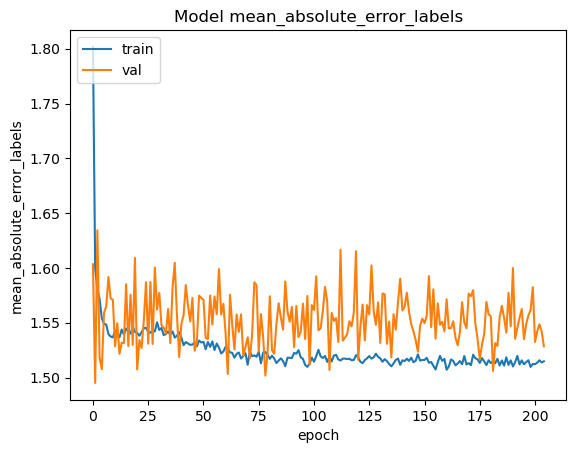

In [96]:
# monitor='loss', patience=20, Epochs: 300
plt.plot(history_model_corn_only_2['mean_absolute_error_labels'])
plt.plot(history_model_corn_only_2['val_mean_absolute_error_labels'])
plt.title('Model mean_absolute_error_labels')
plt.ylabel('mean_absolute_error_labels')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [97]:
# Note that these are ordinal (cumulative) logits, not probabilities or regular logits.
only_ordinal_logits_train_2 = model_corn_only_2.predict(X_train_L1reg_np)
only_ordinal_logits_valid_2 = model_corn_only_2.predict(X_valid_L1reg_np)

# Convert from logits to label probabilities. This is initially a tensorflow tensor.
only_tensor_probs_train_2 = coral.corn_ordinal_softmax(only_ordinal_logits_train_2)
only_tensor_probs_valid_2 = coral.corn_ordinal_softmax(only_ordinal_logits_valid_2)

# Obtain labels from probabilities
only_labels_train_2 = coral.cumprobs_to_label(only_tensor_probs_train_2)
only_labels_valid_2 = coral.cumprobs_to_label(only_tensor_probs_valid_2)

372/372 [==============================] - 0s 674us/step


In [98]:
# In train
# monitor='loss', patience=20, Took Epochs: 68
print("Train evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_corn_only_2.evaluate(X_train_L1reg_np, y_train))
qwk_train_model_corn_only_2=QuadraticWeightedKappa(y_train, only_tensor_probs_train_2).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_train_model_corn_only_2)

Train evaluation

1114/1114 [==============================] - 1s 820us/step - loss: 0.1479 - mean_absolute_error_labels: 1.5135
[Loss, Mean Absolute Error Labels] : [0.1478632092475891, 1.5135210752487183]
Quadratic Weighted Kappa on training set: 0.5253178


In [99]:
# In validation
# monitor='loss', patience=20, Took Epochs: 68

print("Validation evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_corn_only_2.evaluate(X_valid_L1reg_np, y_valid))
qwk_valid_model_corn_only_2 = QuadraticWeightedKappa(y_valid, only_tensor_probs_valid_2).numpy()
print("Quadratic Weighted Kappa on validation set:", qwk_valid_model_corn_only_2)

Validation evaluation

372/372 [==============================] - 0s 825us/step - loss: 0.1909 - mean_absolute_error_labels: 1.5551
[Loss, Mean Absolute Error Labels] : [0.19092506170272827, 1.5551074743270874]
Quadratic Weighted Kappa on validation set: 0.47058547


In [100]:
model_corn_only_2_bias = baseline-qwk_train_model_corn_only_2
model_corn_only_2_var = qwk_train_model_corn_only_2-qwk_valid_model_mlp_3_bn
print("Bias / Variance of the model: ")
print(round(model_corn_only_2_bias,3),"/",round(model_corn_only_2_var,3))

Bias / Variance of the model: 
0.154 / 0.025


For now, we observe that the CORN model presents higher bias than variance. Let's try training it longer, we won't try a deeper arquitecture since in the conducted search where the space allowed for up to 5 hidden layers, the optimal value found was 2.

In [101]:
# monitor='loss', patience=20, Epochs: 300
history_model_corn_only_2 = model_corn_only_2.fit(x=X_train_L1reg_np, y=y_train, epochs=100, validation_data=(X_valid_L1reg_np, y_valid), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights= True)])
#with open('Models/model_corn_only_2/trainHistoryDict', 'wb') as file_pi:
#    pickle.dump(history_model_corn_only_2.history, file_pi)

Epoch 1/100
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1491 - mean_absolute_error_labels: 1.5185 - val_loss: 0.1855 - val_mean_absolute_error_labels: 1.5572
Epoch 2/100
1114/1114 [==============================] - 2s 1ms/step - loss: 0.1490 - mean_absolute_error_labels: 1.5191 - val_loss: 0.1905 - val_mean_absolute_error_labels: 1.5460
Epoch 3/100
1114/1114 [==============================] - 2s 1ms/step - loss: 0.1491 - mean_absolute_error_labels: 1.5144 - val_loss: 0.1909 - val_mean_absolute_error_labels: 1.5511
Epoch 4/100
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1489 - mean_absolute_error_labels: 1.5151 - val_loss: 0.1872 - val_mean_absolute_error_labels: 1.5447
Epoch 5/100
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1491 - mean_absolute_error_labels: 1.5134 - val_loss: 0.1911 - val_mean_absolute_error_labels: 1.5470
Epoch 6/100
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1489 - mean_abso

1114/1114 [==============================] - 1s 1ms/step - loss: 0.1480 - mean_absolute_error_labels: 1.5124 - val_loss: 0.1960 - val_mean_absolute_error_labels: 1.5685
Epoch 47/100
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1483 - mean_absolute_error_labels: 1.5084 - val_loss: 0.1949 - val_mean_absolute_error_labels: 1.5781
Epoch 48/100
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1483 - mean_absolute_error_labels: 1.5142 - val_loss: 0.1902 - val_mean_absolute_error_labels: 1.5291
Epoch 49/100
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1482 - mean_absolute_error_labels: 1.5155 - val_loss: 0.1910 - val_mean_absolute_error_labels: 1.5769
Epoch 50/100
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1481 - mean_absolute_error_labels: 1.5104 - val_loss: 0.1895 - val_mean_absolute_error_labels: 1.5626
Epoch 51/100
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1481 - mean_absolute_er

In [102]:
history_model_corn_only_2=history_model_corn_only_2.history

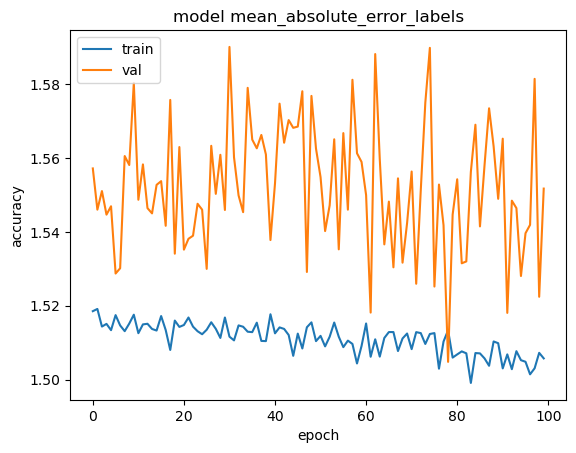

In [103]:
plt.plot(history_model_corn_only_2['mean_absolute_error_labels'])
plt.plot(history_model_corn_only_2['val_mean_absolute_error_labels'])
plt.title('model mean_absolute_error_labels')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [104]:
# Note that these are ordinal (cumulative) logits, not probabilities or regular logits.
only_ordinal_logits_train_2 = model_corn_only_2.predict(X_train_L1reg_np)
only_ordinal_logits_valid_2 = model_corn_only_2.predict(X_valid_L1reg_np)

# Convert from logits to label probabilities. This is initially a tensorflow tensor.
only_tensor_probs_train_2 = coral.corn_ordinal_softmax(only_ordinal_logits_train_2)
only_tensor_probs_valid_2 = coral.corn_ordinal_softmax(only_ordinal_logits_valid_2)

# Obtain labels from probabilities
only_labels_train_2 = coral.cumprobs_to_label(only_tensor_probs_train_2)
only_labels_valid_2 = coral.cumprobs_to_label(only_tensor_probs_valid_2)

372/372 [==============================] - 0s 674us/step


In [105]:
# In train
# monitor='loss', patience=20, Took Epochs: 68
print("Train evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_corn_only_2.evaluate(X_train_L1reg_np, y_train))
qwk_train_model_corn_only_2=QuadraticWeightedKappa(y_train, only_tensor_probs_train_2).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_train_model_corn_only_2)

Train evaluation

1114/1114 [==============================] - 1s 844us/step - loss: 0.1469 - mean_absolute_error_labels: 1.5007
[Loss, Mean Absolute Error Labels] : [0.14687839150428772, 1.5006732940673828]
Quadratic Weighted Kappa on training set: 0.5365197


In [106]:
# In validation
# monitor='loss', patience=20, Took Epochs: 68

print("Validation evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_corn_only_2.evaluate(X_valid_L1reg_np, y_valid))
qwk_valid_model_corn_only_2 = QuadraticWeightedKappa(y_valid, only_tensor_probs_valid_2).numpy()
print("Quadratic Weighted Kappa on validation set:", qwk_valid_model_corn_only_2)

Validation evaluation

372/372 [==============================] - 0s 853us/step - loss: 0.1964 - mean_absolute_error_labels: 1.5517
[Loss, Mean Absolute Error Labels] : [0.19643265008926392, 1.5517473220825195]
Quadratic Weighted Kappa on validation set: 0.48341852


In [107]:
model_corn_only_2_bias = baseline-qwk_train_model_corn_only_2
model_corn_only_2_var = qwk_train_model_corn_only_2-qwk_valid_model_mlp_3_bn
print("Bias / Variance of the model: ")
print(round(model_corn_only_2_bias,3),"/",round(model_corn_only_2_var,3))

Bias / Variance of the model: 
0.143 / 0.036


Let's explore the model's performance when adding batch normalization.

### CORN + Batch Normalization
Next, we will adjust and evaluate the CORN model with the addition of batch normalization layers. Similar to before, we will begin by tuning the learning rate and batch size hyperparameters.

In [108]:
# Tune only the learning rate and the mini-batch size hyperparameters

hp_corn_1 = kt.HyperParameters()
hp_corn_1.Float("learning_rate", min_value=1e-4, max_value=1e-1, sampling="log")
hp_corn_1.Choice("batch_size", [16, 32, 64, 128, 256, 512, 1024])

tuner_corn_1 = kt.Hyperband(
hypermodel = CornHyperModel(),
hyperparameters = hp_corn_1,
tune_new_entries = False,
objective = kt.Objective("mean_absolute_error_labels", "min"),
directory = "Tuners/Corn_Tuner_1",
project_name = "Search_1",
seed = 5,
)

Reloading Tuner from Corn_Tuner_1\Search_1\tuner0.json


In [109]:
tuner_corn_1.search_space_summary()

Search space summary
Default search space size: 2
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
batch_size (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512, 1024], 'ordered': True}


In [110]:
tuner_corn_1.search(X_train_L1reg_np, y_train, validation_data=(X_valid_L1reg_np, y_valid), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights= True)])

In [111]:
tuner_corn_1.results_summary()

Results summary
Results in Corn_Tuner_1\Search_1
Showing 10 best trials
Objective(name="mean_absolute_error_labels", direction="min")

Trial 0208 summary
Hyperparameters:
learning_rate: 0.08589776192716679
batch_size: 1024
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 3
tuner/round: 3
hidden_layers: 2
batch_norm: True
dropout: False
dropout_rate: 0.2
units_1: 16
units_2: 16
tuner/trial_id: 0204
Score: 1.494624376296997

Trial 0204 summary
Hyperparameters:
learning_rate: 0.08589776192716679
batch_size: 1024
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 3
tuner/round: 2
hidden_layers: 2
batch_norm: True
dropout: False
dropout_rate: 0.2
units_1: 16
units_2: 16
tuner/trial_id: 0198
Score: 1.5036402940750122

Trial 0146 summary
Hyperparameters:
learning_rate: 0.00683801702224548
batch_size: 256
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
hidden_layers: 2
batch_norm: True
dropout: False
dropout_rate: 0.2
units_1: 16
units_2: 16
tuner/trial_i

In [112]:
# Get and display the optimal hyperparameters of first search
hyps_corn_1 = tuner_corn_1.get_best_hyperparameters(num_trials=1)[0]
print(hyps_corn_1.values)

{'learning_rate': 0.08589776192716679, 'batch_size': 1024, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 3, 'tuner/round': 3, 'hidden_layers': 2, 'batch_norm': True, 'dropout': False, 'dropout_rate': 0.2, 'units_1': 16, 'units_2': 16, 'tuner/trial_id': '0204'}


In [113]:
hp_corn_2 = kt.HyperParameters()

# Fix

hp_corn_2.Fixed("learning_rate", value = hyps_corn_1["learning_rate"])
hp_corn_2.Fixed("batch_size", value = hyps_corn_1["batch_size"])
hp_corn_2.Fixed("batch_norm", value = True)
hp_corn_2.Fixed("dropout", value = False)
hp_corn_2.Fixed("dropout_rate", value = 0.2)

tuner_corn_2 = kt.Hyperband(
CornHyperModel(),
hyperparameters = hp_corn_2,
tune_new_entries = True,
objective = kt.Objective("val_mean_absolute_error_labels", "min"),
directory = "Tuners/Corn_Tuner_2",
project_name = "Search_1",
seed = 5,
)

Reloading Tuner from Corn_Tuner_2\Search_1\tuner0.json


In [114]:
tuner_corn_2.search_space_summary()

Search space summary
Default search space size: 11
learning_rate (Fixed)
{'conditions': [], 'value': 0.08589776192716679}
batch_size (Fixed)
{'conditions': [], 'value': 1024}
batch_norm (Fixed)
{'conditions': [], 'value': True}
dropout (Fixed)
{'conditions': [], 'value': False}
dropout_rate (Fixed)
{'conditions': [], 'value': 0.2}
hidden_layers (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_v

In [115]:
tuner_corn_2.search(X_train_L1reg_np, y_train, validation_data=(X_valid_L1reg_np, y_valid), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights= True)])

In [116]:
tuner_corn_2.results_summary()

Results summary
Results in Corn_Tuner_2\Search_1
Showing 10 best trials
Objective(name="val_mean_absolute_error_labels", direction="min")

Trial 0234 summary
Hyperparameters:
learning_rate: 0.08589776192716679
batch_size: 1024
batch_norm: True
dropout: False
dropout_rate: 0.2
hidden_layers: 4
units_1: 112
units_2: 112
units_3: 112
units_4: 48
units_5: 80
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0229
Score: 1.4245988130569458

Trial 0238 summary
Hyperparameters:
learning_rate: 0.08589776192716679
batch_size: 1024
batch_norm: True
dropout: False
dropout_rate: 0.2
hidden_layers: 2
units_1: 48
units_2: 48
units_3: 48
units_4: 80
units_5: 80
tuner/epochs: 34
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1.4344884157180786

Trial 0203 summary
Hyperparameters:
learning_rate: 0.08589776192716679
batch_size: 1024
batch_norm: True
dropout: False
dropout_rate: 0.2
hidden_layers: 3
units_1: 48
units_2: 80
units_3: 48
units_4: 80
unit

In [117]:
# Get the optimal model and hyperparameters
hyps_corn_2 = tuner_corn_2.get_best_hyperparameters(num_trials=1)[0]
model_corn_2 = tuner_corn_2.hypermodel.build(hyps_corn_2)
print(hyps_corn_2.values)

{'learning_rate': 0.08589776192716679, 'batch_size': 1024, 'batch_norm': True, 'dropout': False, 'dropout_rate': 0.2, 'hidden_layers': 4, 'units_1': 112, 'units_2': 112, 'units_3': 112, 'units_4': 48, 'units_5': 80, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0229'}


We observe that the optimized learning rate and batch size hyperparameters of the network with batch normalization have increased. This is consistent with the known effects of batch normalization, as a higher learning rate allows for faster convergence. Now, let's fit and evaluate the model's performance.

In [118]:
# monitor='loss', patience=20, Epochs: 136
history_model_corn_2 = model_corn_2.fit(x=X_train_L1reg_np, y=y_train, epochs=300, validation_data=(X_valid_L1reg_np, y_valid), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights= True)])

Epoch 1/300
1114/1114 [==============================] - 5s 2ms/step - loss: 0.1918 - mean_absolute_error_labels: 1.7166 - val_loss: 0.1853 - val_mean_absolute_error_labels: 1.5596
Epoch 2/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1830 - mean_absolute_error_labels: 1.6305 - val_loss: 0.1762 - val_mean_absolute_error_labels: 1.5419
Epoch 3/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1809 - mean_absolute_error_labels: 1.6142 - val_loss: 0.1827 - val_mean_absolute_error_labels: 1.6589
Epoch 4/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1802 - mean_absolute_error_labels: 1.6300 - val_loss: 0.1844 - val_mean_absolute_error_labels: 1.4994
Epoch 5/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1785 - mean_absolute_error_labels: 1.6244 - val_loss: 0.1788 - val_mean_absolute_error_labels: 1.5444
Epoch 6/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1777 - mean_abso

1114/1114 [==============================] - 2s 2ms/step - loss: 0.1677 - mean_absolute_error_labels: 1.5402 - val_loss: 0.1690 - val_mean_absolute_error_labels: 1.5248
Epoch 47/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1674 - mean_absolute_error_labels: 1.5415 - val_loss: 0.1733 - val_mean_absolute_error_labels: 1.5280
Epoch 48/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1674 - mean_absolute_error_labels: 1.5399 - val_loss: 0.1737 - val_mean_absolute_error_labels: 1.5947
Epoch 49/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1682 - mean_absolute_error_labels: 1.5487 - val_loss: 0.1712 - val_mean_absolute_error_labels: 1.6312
Epoch 50/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1671 - mean_absolute_error_labels: 1.5382 - val_loss: 0.1709 - val_mean_absolute_error_labels: 1.5211
Epoch 51/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1667 - mean_absolute_er

Epoch 136/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1629 - mean_absolute_error_labels: 1.5086 - val_loss: 0.1720 - val_mean_absolute_error_labels: 1.4718
Epoch 137/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1627 - mean_absolute_error_labels: 1.5051 - val_loss: 0.1770 - val_mean_absolute_error_labels: 1.4484
Epoch 138/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1624 - mean_absolute_error_labels: 1.5157 - val_loss: 0.1717 - val_mean_absolute_error_labels: 1.4947
Epoch 139/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1628 - mean_absolute_error_labels: 1.5045 - val_loss: 0.1749 - val_mean_absolute_error_labels: 1.5927
Epoch 140/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1628 - mean_absolute_error_labels: 1.5051 - val_loss: 0.1756 - val_mean_absolute_error_labels: 1.5588
Epoch 141/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1629

Epoch 181/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1610 - mean_absolute_error_labels: 1.4920 - val_loss: 0.1752 - val_mean_absolute_error_labels: 1.5007
Epoch 182/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1612 - mean_absolute_error_labels: 1.5008 - val_loss: 0.1732 - val_mean_absolute_error_labels: 1.4761
Epoch 183/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1620 - mean_absolute_error_labels: 1.5093 - val_loss: 0.1746 - val_mean_absolute_error_labels: 1.5102
Epoch 184/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1615 - mean_absolute_error_labels: 1.4972 - val_loss: 0.1713 - val_mean_absolute_error_labels: 1.4887
Epoch 185/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1609 - mean_absolute_error_labels: 1.5104 - val_loss: 0.1766 - val_mean_absolute_error_labels: 1.5223
Epoch 186/300
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1619

In [119]:
history_model_corn_2=history_model_corn_2.history

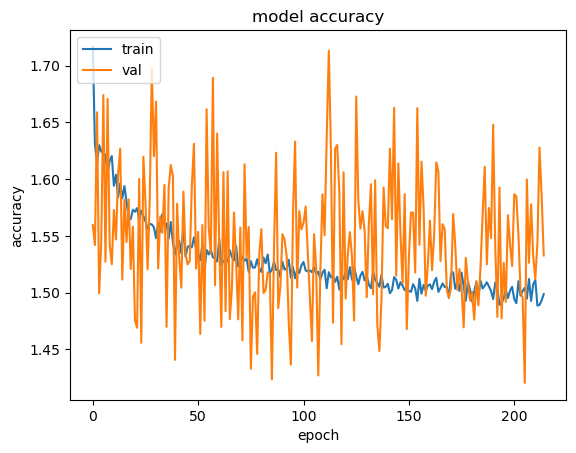

In [120]:
plt.plot(history_model_corn_2['mean_absolute_error_labels'])
plt.plot(history_model_corn_2['val_mean_absolute_error_labels'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [121]:
# Note that these are ordinal (cumulative) logits, not probabilities or regular logits.
ordinal_logits_train = model_corn_2.predict(X_train_L1reg_np)
ordinal_logits_valid = model_corn_2.predict(X_valid_L1reg_np)

# Convert from logits to label probabilities. This is initially a tensorflow tensor.
tensor_probs_train = coral.corn_ordinal_softmax(ordinal_logits_train)
tensor_probs_valid = coral.corn_ordinal_softmax(ordinal_logits_valid)

# Obtain labels from probabilities
labels_train = coral.cumprobs_to_label(tensor_probs_train)
labels_valid = coral.cumprobs_to_label(tensor_probs_valid)

372/372 [==============================] - 0s 827us/step


In [122]:
#In train
# monitor='loss', patience=20, Epochs: 136
print("Train evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_corn_2.evaluate(X_train_L1reg_np, y_train))
qwk_train_model_corn_2 = QuadraticWeightedKappa(y_train, tensor_probs_train).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_train_model_corn_2)

Train evaluation

1114/1114 [==============================] - 1s 929us/step - loss: 0.1490 - mean_absolute_error_labels: 1.4039
[Loss, Mean Absolute Error Labels] : [0.14901544153690338, 1.4039497375488281]
Quadratic Weighted Kappa on training set: 0.5731516


In [123]:
#In validation
# monitor='loss', patience=20, Epochs: 136

print("Validation evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_corn_2.evaluate(X_valid_L1reg_np, y_valid))
qwk_valid_model_corn_2 = QuadraticWeightedKappa(y_valid, tensor_probs_valid).numpy()
print("Quadratic Weighted Kappa on validation set:", qwk_valid_model_corn_2)

Validation evaluation

372/372 [==============================] - 0s 929us/step - loss: 0.1747 - mean_absolute_error_labels: 1.4772
[Loss, Mean Absolute Error Labels] : [0.17470628023147583, 1.4772346019744873]
Quadratic Weighted Kappa on validation set: 0.48575526


In [124]:
baseline = 0.67938
model_corn_2_bias = baseline-qwk_train_model_corn_2
model_corn_2_var = qwk_train_model_corn_2-qwk_valid_model_corn_2
print("Bias / Variance of the model: ")
print(round(model_corn_2_bias,3),"/",round(model_corn_2_var,3))

Bias / Variance of the model: 
0.106 / 0.087


The CORN multilayer perceptron with batch normalization layers showed significant improvement on the training set. However, it presents significant variance, which is larger than the bias. To address this, we will add dropout layers to the model, starting with a dropout rate of 0.2 and adjusting it as needed. Since we can see graphically that this model cam have a better performance on the validation set using early stopping, we will select it to test that later.

### CORN + Batch Normalization + 0.2 Dropout

Since dropout layers can affect optimal learning rates and mini-batch sizes, we will tune them accordingly. Additionally, we will increase the network's size in proportion to the dropout rate, following recommendations from [(#)].

In [125]:
hp_corn_do = kt.HyperParameters()

# Fix

hp_corn_do.Fixed("batch_norm", value = True)
hp_corn_do.Fixed("hidden_layers", value = hyps_corn_2["hidden_layers"])
for i in range(hyps_corn_2["hidden_layers"]):
    hp_corn_do.Fixed("units_"+str(i+1),  value = int(hyps_corn_2["units_"+str(i+1)]/0.8))
hp_corn_do.Fixed("dropout", value = True)
hp_corn_do.Fixed("dropout_rate", value = 0.2)


tuner_corn_do_02 = kt.Hyperband(
CornHyperModel(),
hyperparameters = hp_corn_do,
tune_new_entries = True,
objective = kt.Objective("val_mean_absolute_error_labels", "min"), 
directory = "Tuners/Corn_Do_Tuner",
project_name = "DO_0.2",
seed = 5,
)

Reloading Tuner from Corn_Do_Tuner\DO_0.2\tuner0.json


In [126]:
tuner_corn_do_02.search_space_summary()

Search space summary
Default search space size: 11
batch_norm (Fixed)
{'conditions': [], 'value': True}
hidden_layers (Fixed)
{'conditions': [], 'value': 5}
units_1 (Fixed)
{'conditions': [], 'value': 140}
units_2 (Fixed)
{'conditions': [], 'value': 140}
units_3 (Fixed)
{'conditions': [], 'value': 140}
units_4 (Fixed)
{'conditions': [], 'value': 20}
units_5 (Fixed)
{'conditions': [], 'value': 140}
dropout (Fixed)
{'conditions': [], 'value': True}
dropout_rate (Fixed)
{'conditions': [], 'value': 0.2}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
batch_size (Choice)
{'default': 32, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512, 1024], 'ordered': True}


In [127]:
tuner_corn_do_02.search(X_train_L1reg_np, y_train, validation_data=(X_valid_L1reg_np, y_valid), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)])

In [128]:
tuner_corn_do_02.results_summary()

Results summary
Results in Corn_Do_Tuner\DO_0.2
Showing 10 best trials
Objective(name="val_mean_absolute_error_labels", direction="min")

Trial 0253 summary
Hyperparameters:
batch_norm: True
hidden_layers: 5
units_1: 140
units_2: 140
units_3: 140
units_4: 20
units_5: 140
dropout: True
dropout_rate: 0.2
learning_rate: 0.0862237597677526
batch_size: 1024
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 1.4072712659835815

Trial 0146 summary
Hyperparameters:
batch_norm: True
hidden_layers: 5
units_1: 140
units_2: 140
units_3: 140
units_4: 20
units_5: 140
dropout: True
dropout_rate: 0.2
learning_rate: 0.056639330364712887
batch_size: 128
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0143
Score: 1.4168548583984375

Trial 0235 summary
Hyperparameters:
batch_norm: True
hidden_layers: 5
units_1: 140
units_2: 140
units_3: 140
units_4: 20
units_5: 140
dropout: True
dropout_rate: 0.2
learning_rate: 0.07233914158355592
batc

In [129]:
# Get the optimal hyperparameters
hyps_corn_do_02 = tuner_corn_do_02.get_best_hyperparameters(num_trials=1)[0]
model_corn_do_02 = tuner_corn_do_02.hypermodel.build(hyps_corn_do_02)

print(hyps_corn_do_02.values)

{'batch_norm': True, 'hidden_layers': 5, 'units_1': 140, 'units_2': 140, 'units_3': 140, 'units_4': 20, 'units_5': 140, 'dropout': True, 'dropout_rate': 0.2, 'learning_rate': 0.0862237597677526, 'batch_size': 1024, 'tuner/epochs': 100, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


We can observe changes in the optimal learning rate and batch size hyperparameters compared to the same model without dropout regularization. Now, we will fit and evaluate the model's performance on the training and validation sets.

In [130]:
# monitor='loss', patience=20, Epochs=150
history_model_corn_do_02=model_corn_do_02.fit(x=X_train_L1reg_np, y=y_train, epochs=300, validation_data=(X_valid_L1reg_np, y_valid), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights= True)])

Epoch 1/300
1114/1114 [==============================] - 6s 3ms/step - loss: 0.2065 - mean_absolute_error_labels: 1.9012 - val_loss: 0.1921 - val_mean_absolute_error_labels: 1.6935
Epoch 2/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1990 - mean_absolute_error_labels: 1.8247 - val_loss: 0.1903 - val_mean_absolute_error_labels: 1.5512
Epoch 3/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1977 - mean_absolute_error_labels: 1.8243 - val_loss: 0.1914 - val_mean_absolute_error_labels: 1.7334
Epoch 4/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1971 - mean_absolute_error_labels: 1.8106 - val_loss: 0.1873 - val_mean_absolute_error_labels: 1.5550
Epoch 5/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1965 - mean_absolute_error_labels: 1.8035 - val_loss: 0.1859 - val_mean_absolute_error_labels: 1.6134
Epoch 6/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1963 - mean_abso

1114/1114 [==============================] - 3s 3ms/step - loss: 0.1915 - mean_absolute_error_labels: 1.7350 - val_loss: 0.1827 - val_mean_absolute_error_labels: 1.6852
Epoch 47/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1910 - mean_absolute_error_labels: 1.7319 - val_loss: 0.1834 - val_mean_absolute_error_labels: 1.6168
Epoch 48/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1911 - mean_absolute_error_labels: 1.7385 - val_loss: 0.1831 - val_mean_absolute_error_labels: 1.6282
Epoch 49/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1920 - mean_absolute_error_labels: 1.7499 - val_loss: 0.1821 - val_mean_absolute_error_labels: 1.7205
Epoch 50/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1911 - mean_absolute_error_labels: 1.7472 - val_loss: 0.1857 - val_mean_absolute_error_labels: 1.7608
Epoch 51/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1910 - mean_absolute_er

Epoch 136/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1896 - mean_absolute_error_labels: 1.7202 - val_loss: 0.1814 - val_mean_absolute_error_labels: 1.5559
Epoch 137/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1891 - mean_absolute_error_labels: 1.7150 - val_loss: 0.1830 - val_mean_absolute_error_labels: 1.5443
Epoch 138/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1890 - mean_absolute_error_labels: 1.7117 - val_loss: 0.1841 - val_mean_absolute_error_labels: 1.6420
Epoch 139/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1887 - mean_absolute_error_labels: 1.7118 - val_loss: 0.1826 - val_mean_absolute_error_labels: 1.5202
Epoch 140/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1893 - mean_absolute_error_labels: 1.7047 - val_loss: 0.1819 - val_mean_absolute_error_labels: 1.6455
Epoch 141/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1890

Epoch 181/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1881 - mean_absolute_error_labels: 1.7025 - val_loss: 0.1808 - val_mean_absolute_error_labels: 1.6187
Epoch 182/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1888 - mean_absolute_error_labels: 1.7034 - val_loss: 0.1836 - val_mean_absolute_error_labels: 1.5591
Epoch 183/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1888 - mean_absolute_error_labels: 1.7084 - val_loss: 0.1842 - val_mean_absolute_error_labels: 1.5360
Epoch 184/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1881 - mean_absolute_error_labels: 1.6919 - val_loss: 0.1822 - val_mean_absolute_error_labels: 1.5281
Epoch 185/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1877 - mean_absolute_error_labels: 1.6920 - val_loss: 0.1812 - val_mean_absolute_error_labels: 1.5822
Epoch 186/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1890

In [131]:
history_model_corn_do_02=history_model_corn_do_02.history

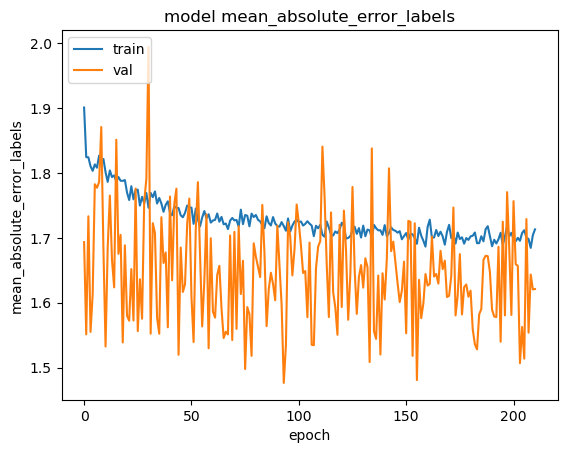

In [132]:
plt.plot(history_model_corn_do_02['mean_absolute_error_labels'])
plt.plot(history_model_corn_do_02['val_mean_absolute_error_labels'])
plt.title('model mean_absolute_error_labels')
plt.ylabel('mean_absolute_error_labels')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [133]:
print("Performance on datasets")

# Note that these are ordinal (cumulative) logits, not probabilities or regular logits.
do_ordinal_logits_train_02 = model_corn_do_02.predict(X_train_L1reg_np)
do_ordinal_logits_valid_02 = model_corn_do_02.predict(X_valid_L1reg_np)

# Convert from logits to label probabilities. This is initially a tensorflow tensor.
do_tensor_probs_train_02 = coral.corn_ordinal_softmax(do_ordinal_logits_train_02)
do_tensor_probs_valid_02 = coral.corn_ordinal_softmax(do_ordinal_logits_valid_02)

# Convert the tensor into a pandas dataframe.
do_labels_train_02 = coral.cumprobs_to_label(do_tensor_probs_train_02)
do_labels_valid_02 = coral.cumprobs_to_label(do_tensor_probs_valid_02)

Performance on datasets
372/372 [==============================] - 0s 854us/step


In [134]:
#In train
# monitor='loss', patience=20, Epochs=150
print("Train evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_corn_do_02.evaluate(X_train_L1reg_np, y_train))
qwk_train_model_corn_do_02 = QuadraticWeightedKappa(y_train, do_tensor_probs_train_02).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_train_model_corn_do_02)

Train evaluation

1114/1114 [==============================] - 1s 1ms/step - loss: 0.1701 - mean_absolute_error_labels: 1.5548
[Loss, Mean Absolute Error Labels] : [0.17013007402420044, 1.5547857284545898]
Quadratic Weighted Kappa on training set: 0.4257272


In [135]:
#In validation
# monitor='loss', patience=20, Epochs=150
print("Validation evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_corn_do_02.evaluate(X_valid_L1reg_np, y_valid))
qwk_valid_model_corn_do_02 = QuadraticWeightedKappa(y_valid, do_tensor_probs_valid_02).numpy()
print("Quadratic Weighted Kappa on validation set:", qwk_valid_model_corn_do_02)

Validation evaluation

372/372 [==============================] - 0s 1ms/step - loss: 0.1803 - mean_absolute_error_labels: 1.5892
[Loss, Mean Absolute Error Labels] : [0.18027986586093903, 1.5892137289047241]
Quadratic Weighted Kappa on validation set: 0.41253316


In [136]:
model_corn_do_02_bias = baseline-qwk_train_model_corn_do_02
model_corn_do_02_var = qwk_train_model_corn_do_02-qwk_valid_model_corn_do_02
print("Bias / Variance of the model: ")
print(round(model_corn_do_02_bias,3),"/",round(model_corn_do_02_var,3))

Bias / Variance of the model: 
0.254 / 0.013


After observing the regularization effects of the dropout layers, we noticed a larger bias than variance. Therefore, we will try a lower regularizing effect for the model.

### CORN + BN + 0.1 Dropout

Similar to before, we will tune the learning rates and mini-batch sizes and increase the network's size in proportion to the dropout rate.

In [137]:
hp_corn_do = kt.HyperParameters()

# Fix
hp_corn_do.Fixed("batch_norm", value = True)
hp_corn_do.Fixed("hidden_layers", value = hyps_corn_2["hidden_layers"])
for i in range(hyps_corn_2["hidden_layers"]):
    hp_corn_do.Fixed("units_"+str(i+1),  value = int(hyps_corn_2["units_"+str(i+1)]/0.9))
hp_corn_do.Fixed("dropout", value = True)
hp_corn_do.Fixed("dropout_rate", value = 0.1)


tuner_corn_do_01 = kt.Hyperband(
CornHyperModel(),
hyperparameters = hp_corn_do,
tune_new_entries = True,
objective = kt.Objective("val_mean_absolute_error_labels", "min"), 
directory = "Tuners/Corn_Do_Tuner",
project_name = "DO_0.1",
seed = 5,
)

Reloading Tuner from Corn_Do_Tuner\DO_0.1\tuner0.json


In [138]:
tuner_corn_do_01.search_space_summary()

Search space summary
Default search space size: 11
batch_norm (Fixed)
{'conditions': [], 'value': True}
hidden_layers (Fixed)
{'conditions': [], 'value': 5}
units_1 (Fixed)
{'conditions': [], 'value': 124}
units_2 (Fixed)
{'conditions': [], 'value': 124}
units_3 (Fixed)
{'conditions': [], 'value': 124}
units_4 (Fixed)
{'conditions': [], 'value': 17}
units_5 (Fixed)
{'conditions': [], 'value': 124}
dropout (Fixed)
{'conditions': [], 'value': True}
dropout_rate (Fixed)
{'conditions': [], 'value': 0.1}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
batch_size (Choice)
{'default': 32, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512, 1024], 'ordered': True}


In [139]:
tuner_corn_do_01.search(X_train_L1reg_np, y_train, validation_data=(X_valid_L1reg_np, y_valid), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)])

In [140]:
tuner_corn_do_01.results_summary()

Results summary
Results in Corn_Do_Tuner\DO_0.1
Showing 10 best trials
Objective(name="val_mean_absolute_error_labels", direction="min")

Trial 0147 summary
Hyperparameters:
batch_norm: True
hidden_layers: 5
units_1: 124
units_2: 124
units_3: 124
units_4: 17
units_5: 124
dropout: True
dropout_rate: 0.1
learning_rate: 0.04621726369179639
batch_size: 64
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0142
Score: 1.4079020023345947

Trial 0222 summary
Hyperparameters:
batch_norm: True
hidden_layers: 5
units_1: 124
units_2: 124
units_3: 124
units_4: 17
units_5: 124
dropout: True
dropout_rate: 0.1
learning_rate: 0.030567566286461307
batch_size: 32
tuner/epochs: 12
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 1.4173387289047241

Trial 0146 summary
Hyperparameters:
batch_norm: True
hidden_layers: 5
units_1: 124
units_2: 124
units_3: 124
units_4: 17
units_5: 124
dropout: True
dropout_rate: 0.1
learning_rate: 0.08369614236184733
batch_s

In [141]:
# Get the optimal hyperparameters
hyps_corn_do_01 = tuner_corn_do_01.get_best_hyperparameters(num_trials=1)[0]
model_corn_do_01 = tuner_corn_do_01.hypermodel.build(hyps_corn_do_01)
print(hyps_corn_do_01.values)

{'batch_norm': True, 'hidden_layers': 5, 'units_1': 124, 'units_2': 124, 'units_3': 124, 'units_4': 17, 'units_5': 124, 'dropout': True, 'dropout_rate': 0.1, 'learning_rate': 0.04621726369179639, 'batch_size': 64, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0142'}


In [142]:
# monitor='loss', patience=20, Epochs= 118
history_model_corn_do_01=model_corn_do_01.fit(x=X_train_L1reg_np, y=y_train, epochs=300, validation_data=(X_valid_L1reg_np, y_valid), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights= True)])

Epoch 1/300
1114/1114 [==============================] - 6s 3ms/step - loss: 0.1989 - mean_absolute_error_labels: 1.7964 - val_loss: 0.1882 - val_mean_absolute_error_labels: 1.5490
Epoch 2/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1887 - mean_absolute_error_labels: 1.6948 - val_loss: 0.1821 - val_mean_absolute_error_labels: 1.5916
Epoch 3/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1873 - mean_absolute_error_labels: 1.6956 - val_loss: 0.1825 - val_mean_absolute_error_labels: 1.5808
Epoch 4/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1860 - mean_absolute_error_labels: 1.6835 - val_loss: 0.1839 - val_mean_absolute_error_labels: 1.5998
Epoch 5/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1852 - mean_absolute_error_labels: 1.6721 - val_loss: 0.1742 - val_mean_absolute_error_labels: 1.5628
Epoch 6/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1842 - mean_abso

1114/1114 [==============================] - 3s 3ms/step - loss: 0.1742 - mean_absolute_error_labels: 1.5948 - val_loss: 0.1686 - val_mean_absolute_error_labels: 1.4742
Epoch 47/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1745 - mean_absolute_error_labels: 1.6018 - val_loss: 0.1733 - val_mean_absolute_error_labels: 1.6352
Epoch 48/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1738 - mean_absolute_error_labels: 1.5921 - val_loss: 0.1707 - val_mean_absolute_error_labels: 1.6136
Epoch 49/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1746 - mean_absolute_error_labels: 1.6192 - val_loss: 0.1694 - val_mean_absolute_error_labels: 1.5460
Epoch 50/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1728 - mean_absolute_error_labels: 1.5948 - val_loss: 0.1699 - val_mean_absolute_error_labels: 1.5074
Epoch 51/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1730 - mean_absolute_er

Epoch 136/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1691 - mean_absolute_error_labels: 1.5521 - val_loss: 0.1716 - val_mean_absolute_error_labels: 1.4614
Epoch 137/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1692 - mean_absolute_error_labels: 1.5511 - val_loss: 0.1707 - val_mean_absolute_error_labels: 1.4976
Epoch 138/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1690 - mean_absolute_error_labels: 1.5516 - val_loss: 0.1716 - val_mean_absolute_error_labels: 1.5041
Epoch 139/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1690 - mean_absolute_error_labels: 1.5727 - val_loss: 0.1709 - val_mean_absolute_error_labels: 1.5365
Epoch 140/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1684 - mean_absolute_error_labels: 1.5493 - val_loss: 0.1695 - val_mean_absolute_error_labels: 1.5037
Epoch 141/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1690

Epoch 181/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1669 - mean_absolute_error_labels: 1.5347 - val_loss: 0.1698 - val_mean_absolute_error_labels: 1.5123
Epoch 182/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1672 - mean_absolute_error_labels: 1.5403 - val_loss: 0.1723 - val_mean_absolute_error_labels: 1.4959
Epoch 183/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1673 - mean_absolute_error_labels: 1.5410 - val_loss: 0.1721 - val_mean_absolute_error_labels: 1.4914
Epoch 184/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1673 - mean_absolute_error_labels: 1.5387 - val_loss: 0.1731 - val_mean_absolute_error_labels: 1.5435
Epoch 185/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1667 - mean_absolute_error_labels: 1.5481 - val_loss: 0.1722 - val_mean_absolute_error_labels: 1.5209
Epoch 186/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1675

Epoch 226/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1669 - mean_absolute_error_labels: 1.5484 - val_loss: 0.1721 - val_mean_absolute_error_labels: 1.4907
Epoch 227/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1674 - mean_absolute_error_labels: 1.5499 - val_loss: 0.1743 - val_mean_absolute_error_labels: 1.5135
Epoch 228/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1666 - mean_absolute_error_labels: 1.5428 - val_loss: 0.1735 - val_mean_absolute_error_labels: 1.5773
Epoch 229/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1666 - mean_absolute_error_labels: 1.5313 - val_loss: 0.1719 - val_mean_absolute_error_labels: 1.5518
Epoch 230/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1667 - mean_absolute_error_labels: 1.5353 - val_loss: 0.1721 - val_mean_absolute_error_labels: 1.5451
Epoch 231/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1659

In [143]:
history_model_corn_do_01=history_model_corn_do_01.history

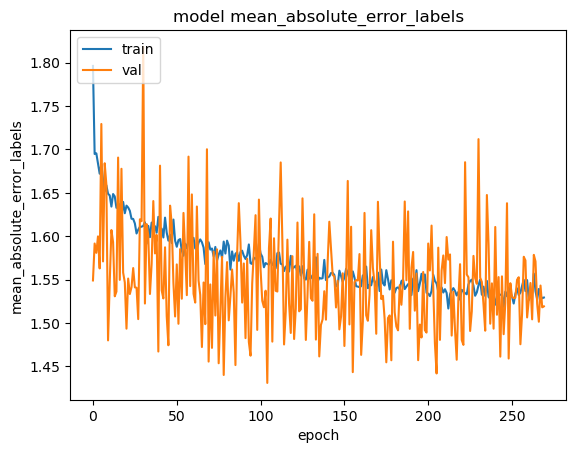

In [144]:
plt.plot(history_model_corn_do_01['mean_absolute_error_labels'])
plt.plot(history_model_corn_do_01['val_mean_absolute_error_labels'])
plt.title('model mean_absolute_error_labels')
plt.ylabel('mean_absolute_error_labels')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [145]:
print("Performance on datasets")

# Note that these are ordinal (cumulative) logits, not probabilities or regular logits.
do_ordinal_logits_train_01 = model_corn_do_01.predict(X_train_L1reg_np)
do_ordinal_logits_valid_01 = model_corn_do_01.predict(X_valid_L1reg_np)

# Convert from logits to label probabilities. This is initially a tensorflow tensor.
do_tensor_probs_train_01 = coral.corn_ordinal_softmax(do_ordinal_logits_train_01)
do_tensor_probs_valid_01 = coral.corn_ordinal_softmax(do_ordinal_logits_valid_01)

# Convert the tensor into a pandas dataframe.
do_labels_train_01 = coral.cumprobs_to_label(do_tensor_probs_train_01)
do_labels_valid_01 = coral.cumprobs_to_label(do_tensor_probs_valid_01)

Performance on datasets
372/372 [==============================] - 0s 878us/step


In [146]:
#In train
# monitor='loss', patience=20, Epochs= 118
print("Train evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_corn_do_01.evaluate(X_train_L1reg_np, y_train))
qwk_train_model_corn_do_01 = QuadraticWeightedKappa(y_train, do_tensor_probs_train_01).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_train_model_corn_do_01)

Train evaluation

1114/1114 [==============================] - 1s 1ms/step - loss: 0.1449 - mean_absolute_error_labels: 1.4574
[Loss, Mean Absolute Error Labels] : [0.14494802057743073, 1.4573888778686523]
Quadratic Weighted Kappa on training set: 0.63123035


In [147]:
#In validation
# monitor='loss', patience=20, Epochs= 118

print("Validation evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_corn_do_01.evaluate(X_valid_L1reg_np, y_valid))
qwk_valid_model_corn_do_01 = QuadraticWeightedKappa(y_valid, do_tensor_probs_valid_01).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_valid_model_corn_do_01)

Validation evaluation

372/372 [==============================] - 0s 1ms/step - loss: 0.1721 - mean_absolute_error_labels: 1.5458
[Loss, Mean Absolute Error Labels] : [0.1720687597990036, 1.5457829236984253]
Quadratic Weighted Kappa on training set: 0.5125713


This model has shown the best performance so far on the validation set. Next, we will try to further reduce bias by increasing the size of the network.

### Larger CORN + BN + 0.1 Dropout

In this iteration, we will keep all hyperparameters the same as the previous model, except for the number of hidden layers and units. The search space for hidden layers will be set between 6 and 8.

In [148]:
bigger_corn_hp = kt.HyperParameters()

# Fix

bigger_corn_hp.Int("hidden_layers", min_value = 6, max_value = 8)
bigger_corn_hp.Fixed("learning_rate", value = hyps_corn_do_01["learning_rate"])
bigger_corn_hp.Fixed("batch_size", value = hyps_corn_do_01["batch_size"])
bigger_corn_hp.Fixed("dropout_rate", value = 0.1)
bigger_corn_hp.Fixed("dropout", value = True)
bigger_corn_hp.Fixed("batch_norm", value = True)


tuner_bigger_corn = kt.Hyperband(
CornHyperModel(),
hyperparameters = bigger_corn_hp,
tune_new_entries = True,
objective = kt.Objective("val_mean_absolute_error_labels", "min"),
directory = "Tuners/Tuner_Big_Corn",
project_name = "Search_6To8",
seed = 5,
)

Reloading Tuner from Tuner_Big_Corn\Search_6To8\tuner0.json


In [149]:
tuner_bigger_corn.search_space_summary()

Search space summary
Default search space size: 14
hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 6, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
learning_rate (Fixed)
{'conditions': [], 'value': 0.04621726369179639}
batch_size (Fixed)
{'conditions': [], 'value': 64}
dropout_rate (Fixed)
{'conditions': [], 'value': 0.1}
dropout (Fixed)
{'conditions': [], 'value': True}
batch_norm (Fixed)
{'conditions': [], 'value': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 114, 'step': 32, 'sampling': 'linear'}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_v

In [150]:
tuner_bigger_corn.search(X_train_L1reg_np, y_train, validation_data=(X_valid_L1reg_np, y_valid), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights= True)])

In [151]:
tuner_bigger_corn.results_summary()

Results summary
Results in Tuner_Big_Corn\Search_6To8
Showing 10 best trials
Objective(name="val_mean_absolute_error_labels", direction="min")

Trial 0211 summary
Hyperparameters:
hidden_layers: 7
learning_rate: 0.04621726369179639
batch_size: 64
dropout_rate: 0.1
dropout: True
batch_norm: True
units_1: 80
units_2: 112
units_3: 80
units_4: 80
units_5: 48
units_6: 16
units_7: 16
units_8: 80
tuner/epochs: 12
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 1.3881235122680664

Trial 0205 summary
Hyperparameters:
hidden_layers: 7
learning_rate: 0.04621726369179639
batch_size: 64
dropout_rate: 0.1
dropout: True
batch_norm: True
units_1: 48
units_2: 80
units_3: 16
units_4: 112
units_5: 112
units_6: 16
units_7: 48
units_8: 112
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0191
Score: 1.3913156986236572

Trial 0155 summary
Hyperparameters:
hidden_layers: 6
learning_rate: 0.04621726369179639
batch_size: 64
dropout_rate: 0.1
dropout: True
b

In [152]:
# Get the optimal hyperparameters
hyps_bigger_corn = tuner_bigger_corn.get_best_hyperparameters(num_trials=1)[0]
model_bigger_corn = tuner_bigger_corn.hypermodel.build(hyps_bigger_corn)

print(hyps_bigger_corn.values)

{'hidden_layers': 7, 'learning_rate': 0.04621726369179639, 'batch_size': 64, 'dropout_rate': 0.1, 'dropout': True, 'batch_norm': True, 'units_1': 80, 'units_2': 112, 'units_3': 80, 'units_4': 80, 'units_5': 48, 'units_6': 16, 'units_7': 16, 'units_8': 80, 'tuner/epochs': 12, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


In [153]:
# monitor='loss', patience=20, epochs=57
history_model_bigger_corn=model_bigger_corn.fit(x=X_train_L1reg_np, y=y_train, epochs=300, validation_data=(X_valid_L1reg_np, y_valid), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights= True)])

Epoch 1/300
1114/1114 [==============================] - 7s 3ms/step - loss: 0.1995 - mean_absolute_error_labels: 1.8031 - val_loss: 0.2316 - val_mean_absolute_error_labels: 1.8400
Epoch 2/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1914 - mean_absolute_error_labels: 1.6978 - val_loss: 0.1830 - val_mean_absolute_error_labels: 1.5688
Epoch 3/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1902 - mean_absolute_error_labels: 1.6805 - val_loss: 0.2027 - val_mean_absolute_error_labels: 1.5370
Epoch 4/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1891 - mean_absolute_error_labels: 1.6877 - val_loss: 0.1918 - val_mean_absolute_error_labels: 1.5161
Epoch 5/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1882 - mean_absolute_error_labels: 1.6685 - val_loss: 0.1811 - val_mean_absolute_error_labels: 1.5421
Epoch 6/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1872 - mean_abso

1114/1114 [==============================] - 3s 3ms/step - loss: 0.1780 - mean_absolute_error_labels: 1.6099 - val_loss: 0.1713 - val_mean_absolute_error_labels: 1.5800
Epoch 47/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1781 - mean_absolute_error_labels: 1.6138 - val_loss: 0.1773 - val_mean_absolute_error_labels: 1.6066
Epoch 48/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1775 - mean_absolute_error_labels: 1.5926 - val_loss: 0.1715 - val_mean_absolute_error_labels: 1.5571
Epoch 49/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1789 - mean_absolute_error_labels: 1.6387 - val_loss: 0.1722 - val_mean_absolute_error_labels: 1.5386
Epoch 50/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1774 - mean_absolute_error_labels: 1.6077 - val_loss: 0.1719 - val_mean_absolute_error_labels: 1.6076
Epoch 51/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1772 - mean_absolute_er

Epoch 136/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1732 - mean_absolute_error_labels: 1.5897 - val_loss: 0.1707 - val_mean_absolute_error_labels: 1.4907
Epoch 137/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1735 - mean_absolute_error_labels: 1.5918 - val_loss: 0.1693 - val_mean_absolute_error_labels: 1.5206
Epoch 138/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1733 - mean_absolute_error_labels: 1.5790 - val_loss: 0.1719 - val_mean_absolute_error_labels: 1.5297
Epoch 139/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1736 - mean_absolute_error_labels: 1.5969 - val_loss: 0.1703 - val_mean_absolute_error_labels: 1.5034
Epoch 140/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1732 - mean_absolute_error_labels: 1.5837 - val_loss: 0.1694 - val_mean_absolute_error_labels: 1.5385
Epoch 141/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1736

Epoch 181/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1722 - mean_absolute_error_labels: 1.5755 - val_loss: 0.1685 - val_mean_absolute_error_labels: 1.5266
Epoch 182/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1727 - mean_absolute_error_labels: 1.5794 - val_loss: 0.1731 - val_mean_absolute_error_labels: 1.5512
Epoch 183/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1722 - mean_absolute_error_labels: 1.5730 - val_loss: 0.1700 - val_mean_absolute_error_labels: 1.4934
Epoch 184/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1719 - mean_absolute_error_labels: 1.5681 - val_loss: 0.1701 - val_mean_absolute_error_labels: 1.4970
Epoch 185/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1716 - mean_absolute_error_labels: 1.5732 - val_loss: 0.1727 - val_mean_absolute_error_labels: 1.5435
Epoch 186/300
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1720

In [154]:
history_model_bigger_corn=history_model_bigger_corn.history

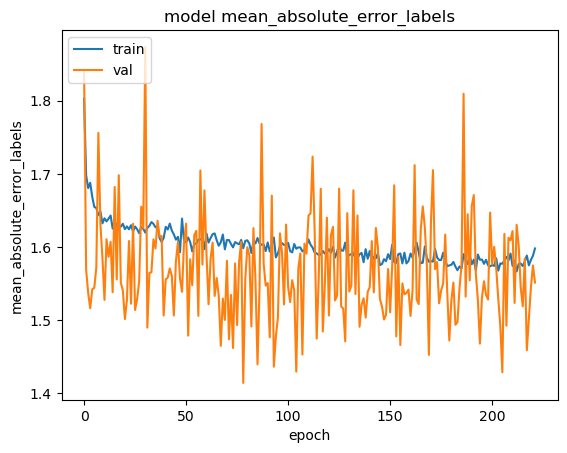

In [155]:
plt.plot(history_model_bigger_corn['mean_absolute_error_labels'])
plt.plot(history_model_bigger_corn['val_mean_absolute_error_labels'])
plt.title('model mean_absolute_error_labels')
plt.ylabel('mean_absolute_error_labels')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [156]:
print("Performance on datasets")

# Note that these are ordinal (cumulative) logits, not probabilities or regular logits.
bigger_do_ordinal_logits_train = model_bigger_corn.predict(X_train_L1reg_np)
bigger_do_ordinal_logits_valid = model_bigger_corn.predict(X_valid_L1reg_np)

# Convert from logits to label probabilities. This is initially a tensorflow tensor.
bigger_do_tensor_probs_train = coral.corn_ordinal_softmax(bigger_do_ordinal_logits_train)
bigger_do_tensor_probs_valid = coral.corn_ordinal_softmax(bigger_do_ordinal_logits_valid)

# Convert the tensor into a pandas dataframe.
bigger_do_labels_train = coral.cumprobs_to_label(bigger_do_tensor_probs_train)
bigger_do_labels_valid = coral.cumprobs_to_label(bigger_do_tensor_probs_valid)

Performance on datasets
372/372 [==============================] - 0s 881us/step


In [157]:
#In train
#0.419 monitor='loss', patience=20, epochs=57

print("Train evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_bigger_corn.evaluate(X_train_L1reg_np, y_train))
qwk_train_model_bigger_corn = QuadraticWeightedKappa(y_train, bigger_do_tensor_probs_train).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_train_model_bigger_corn)

Train evaluation

1114/1114 [==============================] - 1s 1ms/step - loss: 0.1576 - mean_absolute_error_labels: 1.5638
[Loss, Mean Absolute Error Labels] : [0.15759222209453583, 1.563846468925476]
Quadratic Weighted Kappa on training set: 0.46349424


In [158]:
#In validation
#0.411 monitor='loss', patience=20, epochs=57

print("Validation evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_bigger_corn.evaluate(X_valid_L1reg_np, y_valid))
qwk_valid_model_bigger_corn = QuadraticWeightedKappa(y_valid, bigger_do_tensor_probs_valid).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_valid_model_bigger_corn)


Validation evaluation

372/372 [==============================] - 0s 1ms/step - loss: 0.1715 - mean_absolute_error_labels: 1.6001
[Loss, Mean Absolute Error Labels] : [0.17146699130535126, 1.600050449371338]
Quadratic Weighted Kappa on training set: 0.42765832


In [159]:
model_bigger_corn_bias = baseline-qwk_train_model_bigger_corn
model_bigger_corn_var = qwk_train_model_bigger_corn-qwk_valid_model_bigger_corn
print("Bias / Variance of the model: ")
print(round(model_bigger_corn_bias,3),"/",round(model_bigger_corn_var,3))

Bias / Variance of the model: 
0.216 / 0.036


The bias increased significantly with this larger network. The best model for the validation set so far is the CORN model with batch normalization. Now, let's try the regular MLP model with a softmax layer at its output.

The model with the batch normalization layer has a slightly better performance than the one without them, although not very significant. Which means that its the best model of the tested regular MLPs.

### Early Stopping

#### MLP + Batch normalization

In [160]:
# Get the optimal hyperparameters
model_es_mlp_bn = tuner_mlp_2_bn.hypermodel.build(hyps_mlp_2_bn)

print(hyps_mlp_2_bn.values)

{'learning_rate': 0.01894635097944879, 'batch_size': 64, 'batch_norm': True, 'dropout': False, 'do_rate': 0.2, 'hidden_layers': 5, 'units_1': 16, 'units_2': 80, 'units_3': 16, 'units_4': 112, 'units_5': 16, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0240', 'dropout_rate': 0.2}


Now, we will train the model with the optimized hyperparameters.

In [161]:
# monitor='loss', patience=20, epochs=300
history_model_es_mlp_bn = model_es_mlp_bn.fit(x=X_train_L1reg_np, y=y_train, epochs=50, validation_data=(X_valid_L1reg_np, y_valid), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights= True)])
model_es_mlp_bn.save("Models/model_es_mlp_bn/model.keras")
with open('Models/model_es_mlp_bn/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history_model_es_mlp_bn.history, file_pi)

Epoch 1/50
1114/1114 [==============================] - 4s 2ms/step - loss: 1.5008 - accuracy: 0.4509 - QuadraticWeightedKappa: 0.4383 - val_loss: 1.4395 - val_accuracy: 0.4778 - val_QuadraticWeightedKappa: 0.4717
Epoch 2/50
1114/1114 [==============================] - 2s 2ms/step - loss: 1.4208 - accuracy: 0.4772 - QuadraticWeightedKappa: 0.4666 - val_loss: 1.3855 - val_accuracy: 0.4912 - val_QuadraticWeightedKappa: 0.4637
Epoch 3/50
1114/1114 [==============================] - 2s 2ms/step - loss: 1.4050 - accuracy: 0.4804 - QuadraticWeightedKappa: 0.4678 - val_loss: 1.3964 - val_accuracy: 0.5003 - val_QuadraticWeightedKappa: 0.4982
Epoch 4/50
1114/1114 [==============================] - 2s 2ms/step - loss: 1.3920 - accuracy: 0.4873 - QuadraticWeightedKappa: 0.4636 - val_loss: 1.5272 - val_accuracy: 0.4453 - val_QuadraticWeightedKappa: 0.5094
Epoch 5/50
1114/1114 [==============================] - 2s 2ms/step - loss: 1.3830 - accuracy: 0.4924 - QuadraticWeightedKappa: 0.4675 - val_los

In [162]:
model_es_mlp_bn = keras.models.load_model("Models/model_es_mlp_bn/model.keras")
with open('Models/model_es_mlp_bn/trainHistoryDict', "rb") as file_pi:
    history_model_es_mlp_bn = pickle.load(file_pi)

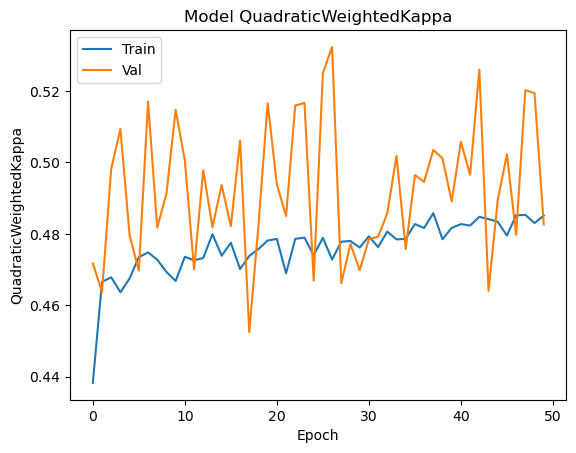

In [163]:
plt.plot(history_model_es_mlp_bn['QuadraticWeightedKappa'])
plt.plot(history_model_es_mlp_bn['val_QuadraticWeightedKappa'])
plt.title('Model QuadraticWeightedKappa')
plt.ylabel('QuadraticWeightedKappa')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [164]:
# Performance on training set
print("Train evaluation")
print()
print("[Loss, Accuracy, Average QWK] :", model_es_mlp_bn.evaluate(X_train_L1reg_np, y_train))
qwk_train_model_es_mlp_bn = QuadraticWeightedKappa(y_train, model_es_mlp_bn.predict(X_train_L1reg_np)).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_train_model_es_mlp_bn)

Train evaluation

1114/1114 [==============================] - 2s 943us/step - loss: 1.2778 - accuracy: 0.5359 - QuadraticWeightedKappa: 0.4756
[Loss, Accuracy, Average QWK] : [1.277774453163147, 0.5358706712722778, 0.4756240248680115]
1114/1114 [==============================] - 1s 778us/step
Quadratic Weighted Kappa on training set: 0.48602098


In [165]:
# Performance on validation set
print("Validation evaluation")
print()
print("[Loss, Accuracy, Average QWK]:",  model_es_mlp_bn.evaluate(X_valid_L1reg_np, y_valid))
qwk_valid_model_es_mlp_bn = QuadraticWeightedKappa(y_valid, model_es_mlp_bn.predict(X_valid_L1reg_np)).numpy()
print("Quadratic Weighted Kappa on validation set:", qwk_valid_model_es_mlp_bn)

Validation evaluation

372/372 [==============================] - 0s 978us/step - loss: 1.3277 - accuracy: 0.5186 - QuadraticWeightedKappa: 0.4827
[Loss, Accuracy, Average QWK]: [1.3277394771575928, 0.5186089873313904, 0.4826616644859314]
372/372 [==============================] - 0s 782us/step
Quadratic Weighted Kappa on validation set: 0.48866814


#### CORN

In [166]:
# Get the optimal hyperparameters
model_es_corn = tuner_corn_only_2.hypermodel.build(hyps_corn_only_2)
print(hyps_corn_only_2.values)

{'learning_rate': 0.0031089211420179527, 'batch_size': 32, 'batch_norm': False, 'dropout': False, 'dropout_rate': 0.2, 'hidden_layers': 2, 'units_1': 80, 'units_2': 16, 'units_3': 112, 'units_4': 16, 'units_5': 48, 'tuner/epochs': 34, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


The optimized model is now deeper and wider, with three hidden layers. Let's fit the fully optimized CORN MLP.

In [167]:
# monitor='loss', patience=20, Epochs: 300
history_model_es_corn = model_es_corn.fit(x=X_train_L1reg_np, y=y_train, epochs=70, validation_data=(X_valid_L1reg_np, y_valid), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25, restore_best_weights= True)])
# model_corn_only_2.save("Models/model_corn_only_2/model.keras")
# with open('Models/model_corn_only_2/trainHistoryDict', 'wb') as file_pi:
#     pickle.dump(history_model_corn_only_2.history, file_pi)

Epoch 1/70
1114/1114 [==============================] - 3s 1ms/step - loss: 0.1910 - mean_absolute_error_labels: 1.8098 - val_loss: 0.1789 - val_mean_absolute_error_labels: 1.7193
Epoch 2/70
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1750 - mean_absolute_error_labels: 1.5941 - val_loss: 0.1790 - val_mean_absolute_error_labels: 1.4882
Epoch 3/70
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1727 - mean_absolute_error_labels: 1.5811 - val_loss: 0.1749 - val_mean_absolute_error_labels: 1.7168
Epoch 4/70
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1710 - mean_absolute_error_labels: 1.5769 - val_loss: 0.1715 - val_mean_absolute_error_labels: 1.4992
Epoch 5/70
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1694 - mean_absolute_error_labels: 1.5688 - val_loss: 0.1721 - val_mean_absolute_error_labels: 1.5253
Epoch 6/70
1114/1114 [==============================] - 1s 1ms/step - loss: 0.1683 - mean_absolute_e

In [168]:
# model_corn_only_2 = keras.models.load_model("Models/model_corn_only_2/model.keras")
# with open('Models/model_corn_only_2/trainHistoryDict', "rb") as file_pi:
#     history_model_corn_only_2 = pickle.load(file_pi)
history_model_es_corn = history_model_es_corn.history

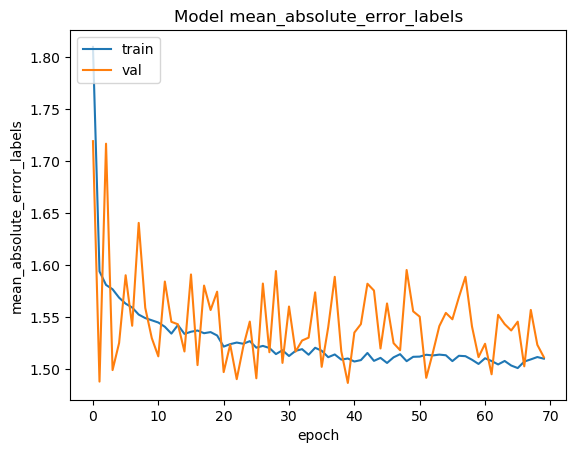

In [169]:
# monitor='loss', patience=20, Epochs: 300
plt.plot(history_model_es_corn['mean_absolute_error_labels'])
plt.plot(history_model_es_corn['val_mean_absolute_error_labels'])
plt.title('Model mean_absolute_error_labels')
plt.ylabel('mean_absolute_error_labels')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [170]:
# Note that these are ordinal (cumulative) logits, not probabilities or regular logits.
model_es_corn_ordinal_logits_train = model_es_corn.predict(X_train_L1reg_np)
model_es_corn_ordinal_logits_valid = model_es_corn.predict(X_valid_L1reg_np)

# Convert from logits to label probabilities. This is initially a tensorflow tensor.
model_es_corn_tensor_probs_train = coral.corn_ordinal_softmax(model_es_corn_ordinal_logits_train)
model_es_corn_tensor_probs_valid = coral.corn_ordinal_softmax(model_es_corn_ordinal_logits_valid)

# Obtain labels from probabilities
model_es_corn_labels_train = coral.cumprobs_to_label(model_es_corn_tensor_probs_train)
model_es_corn_labels_valid = coral.cumprobs_to_label(model_es_corn_tensor_probs_valid)

372/372 [==============================] - 0s 714us/step


In [171]:
# In train
# monitor='loss', patience=20, Took Epochs: 68
print("Train evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_es_corn.evaluate(X_train_L1reg_np, y_train))
qwk_train_model_es_corn=QuadraticWeightedKappa(y_train, model_es_corn_tensor_probs_train).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_train_model_es_corn)

Train evaluation

1114/1114 [==============================] - 1s 821us/step - loss: 0.1514 - mean_absolute_error_labels: 1.4701
[Loss, Mean Absolute Error Labels] : [0.15135325491428375, 1.470096468925476]
Quadratic Weighted Kappa on training set: 0.55647045


In [172]:
# In validation
# monitor='loss', patience=20, Took Epochs: 68

print("Validation evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_es_corn.evaluate(X_valid_L1reg_np, y_valid))
qwk_valid_model_es_corn = QuadraticWeightedKappa(y_valid, model_es_corn_tensor_probs_valid).numpy()
print("Quadratic Weighted Kappa on validation set:", qwk_valid_model_es_corn)

Validation evaluation

372/372 [==============================] - 0s 859us/step - loss: 0.1704 - mean_absolute_error_labels: 1.5116
[Loss, Mean Absolute Error Labels] : [0.17043925821781158, 1.5115927457809448]
Quadratic Weighted Kappa on validation set: 0.51552045


In [173]:
model_corn_only_2_bias = baseline-qwk_train_model_corn_only_2
model_corn_only_2_var = qwk_train_model_corn_only_2-qwk_valid_model_mlp_3_bn
print("Bias / Variance of the model: ")
print(round(model_corn_only_2_bias,3),"/",round(model_corn_only_2_var,3))

Bias / Variance of the model: 
0.143 / 0.036


#### CORN + BN

In [174]:
model_es_corn_bn = tuner_corn_2.hypermodel.build(hyps_corn_2)

In [175]:
# Fit with the entire dataset.
# Epochs= 22, monitor='val_loss', patience=20
history_model_es_corn_bn=model_es_corn_bn.fit(x=X_train_L1reg_np, y=y_train, epochs=100, validation_data=(X_valid_L1reg_np, y_valid), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights= True)])

Epoch 1/100
1114/1114 [==============================] - 5s 2ms/step - loss: 0.1924 - mean_absolute_error_labels: 1.7271 - val_loss: 0.1855 - val_mean_absolute_error_labels: 1.5693
Epoch 2/100
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1831 - mean_absolute_error_labels: 1.6530 - val_loss: 0.1757 - val_mean_absolute_error_labels: 1.6217
Epoch 3/100
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1811 - mean_absolute_error_labels: 1.6224 - val_loss: 0.1813 - val_mean_absolute_error_labels: 1.5395
Epoch 4/100
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1802 - mean_absolute_error_labels: 1.6135 - val_loss: 0.1908 - val_mean_absolute_error_labels: 1.4730
Epoch 5/100
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1784 - mean_absolute_error_labels: 1.5965 - val_loss: 0.1780 - val_mean_absolute_error_labels: 1.5440
Epoch 6/100
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1773 - mean_abso

1114/1114 [==============================] - 2s 2ms/step - loss: 0.1669 - mean_absolute_error_labels: 1.5576 - val_loss: 0.1724 - val_mean_absolute_error_labels: 1.5468
Epoch 47/100
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1663 - mean_absolute_error_labels: 1.5628 - val_loss: 0.1716 - val_mean_absolute_error_labels: 1.5605
Epoch 48/100
1114/1114 [==============================] - 2s 2ms/step - loss: 0.1666 - mean_absolute_error_labels: 1.5408 - val_loss: 0.1727 - val_mean_absolute_error_labels: 1.5612


In [176]:
# Note that these are ordinal (cumulative) logits, not probabilities or regular logits.
model_es_corn_bn_ordinal_logits_train = model_es_corn_bn.predict(X_train_L1reg_np)
model_es_corn_bn_ordinal_logits_valid = model_es_corn_bn.predict(X_valid_L1reg_np)

# Convert from logits to label probabilities. This is initially a tensorflow tensor.
model_es_corn_bn_tensor_probs_train = coral.corn_ordinal_softmax(model_es_corn_bn_ordinal_logits_train)
model_es_corn_bn_tensor_probs_valid = coral.corn_ordinal_softmax(model_es_corn_bn_ordinal_logits_valid)

# Obtain labels from probabilities
model_es_corn_bn_labels_train = coral.cumprobs_to_label(model_es_corn_bn_tensor_probs_train)
model_es_corn_bn_labels_valid = coral.cumprobs_to_label(model_es_corn_bn_tensor_probs_valid)

372/372 [==============================] - 0s 838us/step


In [177]:
#In train
# Epochs= 22, monitor='val_loss', patience=20
print("Train evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_es_corn_bn.evaluate(X_train_L1reg_np, y_train))
qwk_train_model_es_corn_bn = QuadraticWeightedKappa(y_train, model_es_corn_bn_tensor_probs_train).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_train_model_es_corn_bn)

Train evaluation

1114/1114 [==============================] - 1s 964us/step - loss: 0.1597 - mean_absolute_error_labels: 1.5574
[Loss, Mean Absolute Error Labels] : [0.15972940623760223, 1.5573571920394897]
Quadratic Weighted Kappa on training set: 0.5189632


In [178]:
#In validation
# Epochs= 22, monitor='val_loss', patience=30

print("Validation evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_corn_2.evaluate(X_valid_L1reg_np, y_valid))
qwk_valid_model_corn_2 = QuadraticWeightedKappa(y_valid, model_es_corn_bn_tensor_probs_valid).numpy()
print("Quadratic Weighted Kappa on validation set:", qwk_valid_model_corn_2)

Validation evaluation

372/372 [==============================] - 0s 1ms/step - loss: 0.1747 - mean_absolute_error_labels: 1.4772
[Loss, Mean Absolute Error Labels] : [0.17470628023147583, 1.4772346019744873]
Quadratic Weighted Kappa on validation set: 0.5075833


### CORN +BN +0.1 DO

In [179]:
# Get the optimal hyperparameters
model_corn_do_01_es = tuner_corn_do_01.hypermodel.build(hyps_corn_do_01)
print(hyps_corn_do_01.values)

{'batch_norm': True, 'hidden_layers': 5, 'units_1': 124, 'units_2': 124, 'units_3': 124, 'units_4': 17, 'units_5': 124, 'dropout': True, 'dropout_rate': 0.1, 'learning_rate': 0.04621726369179639, 'batch_size': 64, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0142'}


In [180]:
# monitor='loss', patience=20, Epochs= 118
history_model_corn_do_01_es=model_corn_do_01_es.fit(x=X_train_L1reg_np, y=y_train, epochs=100, validation_data=(X_valid_L1reg_np, y_valid), callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights= True)])

Epoch 1/100
1114/1114 [==============================] - 7s 3ms/step - loss: 0.1983 - mean_absolute_error_labels: 1.7824 - val_loss: 0.1861 - val_mean_absolute_error_labels: 1.5338
Epoch 2/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1876 - mean_absolute_error_labels: 1.7013 - val_loss: 0.1805 - val_mean_absolute_error_labels: 1.5853
Epoch 3/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1861 - mean_absolute_error_labels: 1.6826 - val_loss: 0.1820 - val_mean_absolute_error_labels: 1.6278
Epoch 4/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1850 - mean_absolute_error_labels: 1.6855 - val_loss: 0.1775 - val_mean_absolute_error_labels: 1.5204
Epoch 5/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1838 - mean_absolute_error_labels: 1.6613 - val_loss: 0.1758 - val_mean_absolute_error_labels: 1.5079
Epoch 6/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1832 - mean_abso

1114/1114 [==============================] - 3s 3ms/step - loss: 0.1735 - mean_absolute_error_labels: 1.5841 - val_loss: 0.1689 - val_mean_absolute_error_labels: 1.5610
Epoch 47/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1735 - mean_absolute_error_labels: 1.6001 - val_loss: 0.1730 - val_mean_absolute_error_labels: 1.5343
Epoch 48/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1726 - mean_absolute_error_labels: 1.5778 - val_loss: 0.1705 - val_mean_absolute_error_labels: 1.5738
Epoch 49/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1739 - mean_absolute_error_labels: 1.5967 - val_loss: 0.1693 - val_mean_absolute_error_labels: 1.5254
Epoch 50/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1722 - mean_absolute_error_labels: 1.5961 - val_loss: 0.1708 - val_mean_absolute_error_labels: 1.5745
Epoch 51/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1723 - mean_absolute_er

In [181]:
history_model_corn_do_01_es=history_model_corn_do_01_es.history

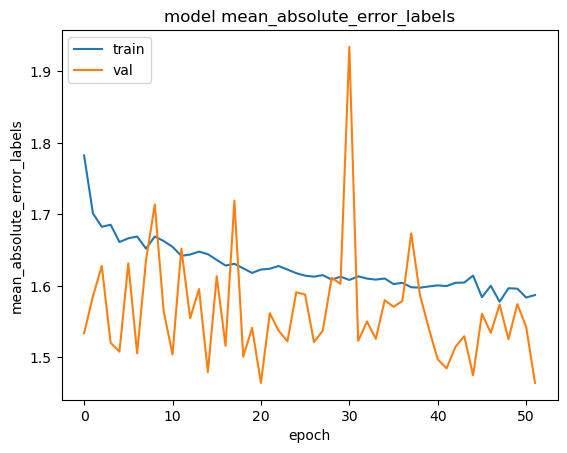

In [182]:
plt.plot(history_model_corn_do_01_es['mean_absolute_error_labels'])
plt.plot(history_model_corn_do_01_es['val_mean_absolute_error_labels'])
plt.title('model mean_absolute_error_labels')
plt.ylabel('mean_absolute_error_labels')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [183]:
print("Performance on datasets")

# Note that these are ordinal (cumulative) logits, not probabilities or regular logits.
model_corn_do_01_es_ordinal_logits_train = model_corn_do_01_es.predict(X_train_L1reg_np)
model_corn_do_01_es_ordinal_logits_valid = model_corn_do_01_es.predict(X_valid_L1reg_np)

# Convert from logits to label probabilities. This is initially a tensorflow tensor.
model_corn_do_01_es_tensor_probs_train = coral.corn_ordinal_softmax(model_corn_do_01_es_ordinal_logits_train)
model_corn_do_01_es_tensor_probs_valid = coral.corn_ordinal_softmax(model_corn_do_01_es_ordinal_logits_valid)

# Convert the tensor into a pandas dataframe.
model_corn_do_01_es_labels_train = coral.cumprobs_to_label(model_corn_do_01_es_tensor_probs_train)
model_corn_do_01_es_labels_valid = coral.cumprobs_to_label(model_corn_do_01_es_tensor_probs_valid)

Performance on datasets
372/372 [==============================] - 0s 853us/step


In [184]:
#In train
# monitor='loss', patience=20, Epochs= 118
print("Train evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_corn_do_01_es.evaluate(X_train_L1reg_np, y_train))
qwk_train_model_corn_do_01_es = QuadraticWeightedKappa(y_train, model_corn_do_01_es_tensor_probs_train).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_train_model_corn_do_01_es)

Train evaluation

1114/1114 [==============================] - 1s 1ms/step - loss: 0.1607 - mean_absolute_error_labels: 1.5031
[Loss, Mean Absolute Error Labels] : [0.16069923341274261, 1.5031137466430664]
Quadratic Weighted Kappa on training set: 0.5144448


In [185]:
#In validation
# monitor='loss', patience=20, Epochs= 118

print("Validation evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", model_corn_do_01_es.evaluate(X_valid_L1reg_np, y_valid))
qwk_valid_model_corn_do_01_es = QuadraticWeightedKappa(y_valid, model_corn_do_01_es_tensor_probs_valid).numpy()
print("Quadratic Weighted Kappa on training set:", qwk_valid_model_corn_do_01_es)

Validation evaluation

372/372 [==============================] - 0s 989us/step - loss: 0.1687 - mean_absolute_error_labels: 1.5213
[Loss, Mean Absolute Error Labels] : [0.16866078972816467, 1.5213373899459839]
Quadratic Weighted Kappa on training set: 0.50626636


<a name='3.3'></a>
## 3.3 Model Selection
From all models, we can observe that the best one turned out to be the CORN model with the batch normalzation. 

<a name='4'></a>
# 4. Evaluate the performance of the final model 

In this section, we will evaluate the performance of our selected model on the testing set, and also compare its performance on the QWK metric and additionaly, its balanced accuracy, with the machine learning models constructed and fitted at [[10]](#R-10) 
These models include Support Vector Machines with different kernels, decision trees, random forests, and Gradient Boosting Machines.

In this final section, we'll employ functions from both scikit-learn and scikit-plot libraries to visualize and evaluate the performance of our tuned model on the testing set. It's worth noting that, as mentioned earlier, all the following metrics except for the Quadratic Weighted Kappa (QWK) categorize predictions in a 'one-vs-rest' fashion, and therefore, they may not accurately reflect the difficulty level in correctly classifying each applicant with the exact rating they were given. Execute the next code cells to display the reports.


### Classification Reports (Loss/Mean Absolute Error Labels/QuadraticWeightedKappa/Accuracy)¶
In the following code, we will first see the loss and Mean absolute error labels on the test set, with which the hyperparameter optimization was performed.

In [186]:
# Use the best performing model to generate predictions (as probability estimates) on the test dataset.
best_model=model_es_corn

In [187]:
# Note that these are ordinal (cumulative) logits, not probabilities or regular logits.
best_model_ordinal_logits = best_model.predict(X_test_L1reg_np)

# Convert from logits to label probabilities. This is initially a tensorflow tensor.
best_model_tensor_probs = coral.corn_ordinal_softmax(best_model_ordinal_logits)

# Obtain labels from probabilities
best_model_labels = coral.cumprobs_to_label(best_model_tensor_probs)


372/372 [==============================] - 0s 718us/step


In [188]:
best_model_PredProbs = best_model_tensor_probs

# Convert the probability estimates into label-encoded predictions, then convert back to the original set of classes.
best_model_Preds = np.argmax(best_model_PredProbs, axis=1)

In [189]:
#In test
# Epochs= 22, monitor='val_loss', patience=20
print("Train evaluation")
print()
print("[Loss, Mean Absolute Error Labels] :", best_model.evaluate(X_train_L1reg_np, y_train))

Train evaluation

1114/1114 [==============================] - 1s 814us/step - loss: 0.1514 - mean_absolute_error_labels: 1.4701
[Loss, Mean Absolute Error Labels] : [0.15135325491428375, 1.470096468925476]


Now we'll evaluate the Quadratic Weighted Kappa Metric on the testing set of our best model.

In [190]:
qwk_best_model = QuadraticWeightedKappa(y_test, best_model_tensor_probs).numpy()
print("Quadratic Weighted Kappa on testing set:", qwk_best_model)

Quadratic Weighted Kappa on testing set: 0.5141014


Finally we'll calculate the accuracy of our model on the testing set.

In [201]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, best_model_Preds)

0.5139344952429065

We can note a small error discrepancy between the validation set and the test set.

## Performance Comparison with Other ML Models

The code below utilizes the accuracy and QWK scores imported from the machine learning models mentioned earlier, accessible from the link: https://colab.research.google.com/drive/1YX5K5EY3bL4R9UmahPVK_HEQm-m2AmVM#scrollTo=MOHu0CZWjDky . These scores are then compared to those obtained by the selected top-performing neural network.

In [192]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
#pip install xgboost

In [43]:
ML_PredProbs= pickle.load(open('ML_Results/ML_PredProbs', 'rb'))
ML_Preds= pickle.load(open('ML_Results/ML_Preds', 'rb'))

In [44]:
Model_Names ={
 "1": "LogisticRegression         ",
 "2": "GaussianNB                 ",
 "3": "SVC(kernel='linear')       ",
 "4": "LinearSVC                  ",
 "5": "SVC(kernel='poly')         ",
 "6": "SVC(kernel='rbf')          ",
 "7": "SVC(kernel='sigmoid')      ",
 "8": "DecisionTreeClassifier     ",
 "9": "RandomForestClassifier     ",
 "10":"AdaBoostClassifier         ",
 "11":"GradientBoostingClassifier ",
 "12":"XGBClassifier              ",
}

In [57]:
from sklearn.metrics import accuracy_score
print("Quadratic Weighted Kappa of fitted ML Models")
print()
# Print performance for models 1 to 10
for i in range(1, 13):
    print("QWK Model", i, Model_Names[str(i)],":", round(QuadraticWeightedKappa(y_test, ML_PredProbs[str(i)]).numpy(),3))
print_colored("QWK Model CORN", color ='purple')
print(round(0.5141014,3))

Quadratic Weighted Kappa of fitted ML Models

QWK Model 1 LogisticRegression          : 0.45
QWK Model 2 GaussianNB                  : 0.412
QWK Model 3 SVC(kernel='linear')        : 0.158
QWK Model 4 LinearSVC                   : 0.435
QWK Model 5 SVC(kernel='poly')          : 0.242
QWK Model 6 SVC(kernel='rbf')           : 0.275
QWK Model 7 SVC(kernel='sigmoid')       : 0.023
QWK Model 8 DecisionTreeClassifier      : 0.424
QWK Model 9 RandomForestClassifier      : 0.468
QWK Model 10 AdaBoostClassifier          : 0.47
QWK Model 11 GradientBoostingClassifier  : 0.51
QWK Model 12 XGBClassifier               : 0.492


0.514


In [60]:
y_valid = le.inverse_transform(y_valid)
y_test= le.inverse_transform(y_test)

In [65]:
from sklearn.metrics import accuracy_score
print_colored("Accuracy of fitted ML Models", color='purple')
print()
# Print performance for models 1 to 10
for i in range(1, 11):
    print("Accuracy Model", i, Model_Names[str(i)],":", round(accuracy_score(y_test, ML_Preds[str(i)]),3))

print("Accuracy Model", 12, Model_Names[str(12)],":", round(accuracy_score(y_test, ML_Preds[str(12)]),3))
print_colored("Accuracy Model CORN", color ='purple')
print(round(0.513934,3))


Accuracy Model 1 LogisticRegression          : 0.476
Accuracy Model 2 GaussianNB                  : 0.398
Accuracy Model 3 SVC(kernel='linear')        : 0.364
Accuracy Model 4 LinearSVC                   : 0.469
Accuracy Model 5 SVC(kernel='poly')          : 0.379
Accuracy Model 6 SVC(kernel='rbf')           : 0.408
Accuracy Model 7 SVC(kernel='sigmoid')       : 0.325
Accuracy Model 8 DecisionTreeClassifier      : 0.514
Accuracy Model 9 RandomForestClassifier      : 0.52
Accuracy Model 10 AdaBoostClassifier          : 0.498
Accuracy Model 12 XGBClassifier               : 0.527


0.514


## Other Classification Metrics

In [67]:
# Convert back to the original set of classes.
best_model_Preds = le.inverse_transform(best_model_Preds)

### Classification Reports (Precisions/Recalls/F1-Scores)


In [203]:
print(classification_report(y_test, best_model_Preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1241
           1       0.26      0.15      0.19      1310
           2       0.02      0.08      0.03       203
           3       0.07      0.02      0.03       286
           4       0.02      0.01      0.01      1086
           5       0.15      0.06      0.08      2247
           6       0.15      0.27      0.19      1606
           7       0.13      0.03      0.05      3898
           8       0.00      0.00      0.00         0

    accuracy                           0.08     11877
   macro avg       0.09      0.07      0.07     11877
weighted avg       0.12      0.08      0.08     11877



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_cla

### Confusion Matrix

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

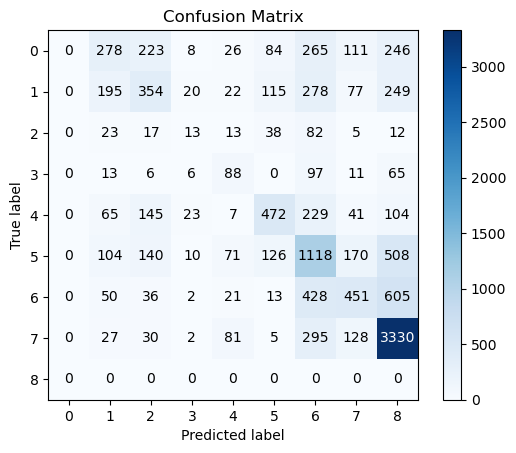

In [204]:
plot_confusion_matrix(y_test, best_model_Preds)

### ROC Curve
The plot below displays the ROC curves for our model. This curve is a graph of the true positive rate versus the false positive rate for each class.


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

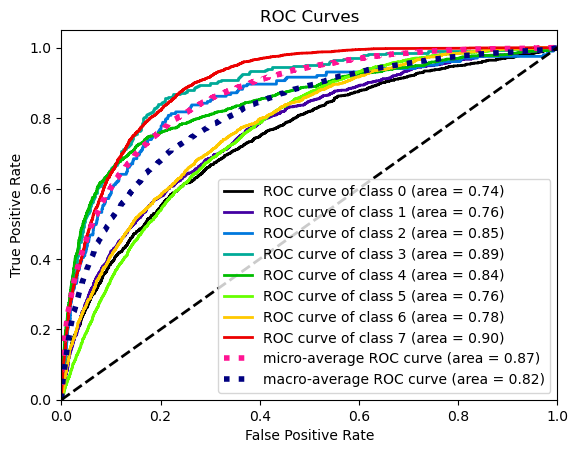

In [205]:
# Display ROC Curves
plot_roc(y_test, best_model_PredProbs)

<a name='6'></a>  
## 5 - Bibliography

<a name='R-1'></a>  
1. Kaggle. (n.d.). Prudential Life Insurance Assessment: Evaluation. Retrieved from https://www.kaggle.com/competitions/prudential-life-insurance-assessment/overview/evaluation.
<a name='R-2'></a>  
2. Keras Tuner documentation for tuners. (n.d.). Retrieved from https://keras.io/api/keras_tuner/tuners/.
<a name='R-3'></a>  
3. Keras API documentation for metrics. (n.d.). Retrieved from https://keras.io/api/metrics/.
<a name='R-4'></a>  
4. Keras API documentation for losses. (n.d.). Retrieved from https://keras.io/api/losses/.
<a name='R-5'></a>  
5. Keras Tuner documentation for objective. (n.d.). Retrieved from https://keras.io/api/keras_tuner/tuners/objective/.
<a name='R-6'></a>  
6. Keras: Creating custom metrics. (n.d.). Retrieved from https://keras.io/api/metrics/#creating-custom-metrics.
<a name='R-7'></a>  
7. Keras. (2021, October 27). Tailoring the search space. Retrieved from https://keras.io/guides/keras_tuner/tailor_the_search_space/.
<a name='R-8'></a>  
8. Keras API documentation for Activations. Retrieved from https://keras.io/api/layers/activations/.
<a name='R-9'></a>  
9. Keras API documentation for Hyperparameters. Retrieved from https://keras.io/api/keras_tuner/hyperparameters/.
<a name='R-10'></a>  
10. Kaggle. (n.d.). Machine Learning for Risk Classification. Retrieved from https://www.kaggle.com/code/karansarpal/machine-learning-for-risk-classification-ks.
<a name='R-11'></a>  
11. Balasubramanian, R., Libarikian, A., & McElhaney, D. (2021). Insurance 2030—The impact of AI on the future of insurance. McKinsey & Company website. Retrieved from https://www.mckinsey.com/industries/financial-services/our-insights/insurance-2030-the-impact-of-ai-on-the-future-of-insurance#